## PREPROCESSING
The raw data for this project is energy data from the University of Pennsylvania. This data was gathered by hand by graduate students at the Center for Environmental Building and Design for projects, research, and reporting to FRES on energy consumption in their building stock. The data could only be accessed by downloading excel files containing a single day of energy data in 15 minute increments. Each daily file contains the consumption data for one of Electricity, Steam, or Chilled Water for all the buildings on campus that receive those energy carriers along with a timestamp. Not all buildings have steam or chilled water and some buildings that have electricity, steam or chilled water may be serviced from another building and thus may not be metered for one but still report on others. 

These daily files were combined into monthly files, leaving in the headers for each daily segment and separated by an empty row. The preprocessing consists of taking this raw data and creating separate .csvs with the data for each building. Following that stage, the individual files are scanned for outliers, which are removed. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The final stage of the preprocessing process is to take the outlier_removed data and to join it with weather data using the timestamp. The weather data used was purchased by the Center for Environmental Building + Design to be used with the energy data. It is, however, in hourly increments, so prior to joining the energy data must be resampled to hourly means. 

Step 1: Import the necessary modules to pre-process the data

In [ ]:
import os, csv, datetime, matplotlib, copy
import numpy as np
import pandas as pd
import openpyxl as px
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import _pickle as pickle
from collections import defaultdict, OrderedDict
from dateutil import parser, rrule
from scipy import stats

Step 2: Access the raw data files from the google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Step 3: A few helper functions that will be useful for identifying the outlier data.

In [ ]:
def representFloat(self, string):
    try:
        float(string)
    except ValueError:
        return False
    else:
        return True

In [ ]:
def getOutlierIdx(x,thresh=5.0):
    TorF = doubleMADsfromMedian(x,thresh)
    false_idx = [i for i in range(len(x)) if TorF[i] == True]       
    return false_idx

In [ ]:
def doubleMADsfromMedian(y,thresh=2.8):
    b=len(y)
    nonzero_idx = np.where(y!=0)
    nonzeros = y[y != 0]
    m = np.median(nonzeros)
    abs_dev = np.abs(nonzeros - m)
    left_mad = np.median(abs_dev[nonzeros<=m])
    right_mad = np.median(abs_dev[nonzeros>=m])
    y_mad = np.zeros(len(nonzeros))
    y_mad[nonzeros < m] = left_mad
    y_mad[nonzeros > m] = right_mad
    modified_z_score = 0.6745 * abs_dev / y_mad
    modified_z_score[nonzeros == m] = 0
    d=np.zeros((len(y)),dtype=bool)
    d[nonzero_idx] = modified_z_score > thresh
    y=d 
    a=len(modified_z_score)
    print (a , b) 
    return y

Step 4: OmniEnergyPlot is a function that accepts a range of inputs to generate plots from the 15minute energy data.

In [ ]:
def omniEnergyPlot(plot_file_name, unit, df_list, **kwargs):
    style = ''
    if kwargs is not None:
        if 'style' in kwargs.keys():
            style = kwargs['style']
    if len(df_list) > 9:
        fig = plt.figure(figsize=(12, 8), dpi=300, facecolor='w', edgecolor='k')
    else:
        fig = plt.figure(figsize=(12, 2), dpi=300, facecolor='w', edgecolor='k')
    fig.text(0.5, 0.01, 'Time', ha='center', fontsize = 9)

    plot_dict = OrderedDict()
    color_list = ['k', 'r', 'b', 'y', 'g', 'm', 'c']
    for i in range(len(df_list)):
        plot_dict[i] = plt.subplot(1, 3, int(i+1))
        xy = df_list[i]
        x = xy.index
        if len(xy.shape) == 1:
            if style == 'no_mark':
                plot_dict[i].plot(x, xy, linewidth=0.5, color = color_list[0])
            elif style == 'histo':
                plot_dict[i].hist(xy, bins=50,  fc='k')
            elif style == 'bar':
                plot_dict[i].bar(x, xy.values)
            else:
                plot_dict[i].plot(x, xy, linewidth=0.5, linestyle = 'dotted', marker = 'x', markersize = 1, color = color_list[0]) 
        else:
            for j in range(xy.shape[1]):
                if j%2 == 0:
                    if style == 'scatter':
                        plot_dict[i].plot(x, xy[xy.columns[j]], color_list[j]+'x',label=(xy.columns)[j], markersize = 1) 
                    elif style == 'no_mark':
                        plot_dict[i].plot(x, xy[xy.columns[int(j)]], linewidth=1, label=(xy.columns)[int(j)], linestyle = 'dotted', color = color_list[int(j/2)])
                    elif style == 'bar':
                        plot_dict[i].bar(x, xy.values)
                    elif style == 'fill_between':
                        plot_dict[i].plot(x, xy[xy.columns[j]], linewidth=1, label=(xy.columns)[j], linestyle = 'dotted', marker = 'x', markersize = 1, color = color_list[int(j/2)])
                        if j != xy.shape[1]-1:
                            plot_dict[i].fill_between(x, xy[xy.columns[j]], xy[xy.columns[j+1]], where=xy[xy.columns[j]] > xy[xy.columns[j+1]], facecolor='green', interpolate=True)
                            plot_dict[i].fill_between(x, xy[xy.columns[j]], xy[xy.columns[j+1]], where=xy[xy.columns[j]] < xy[xy.columns[j+1]], facecolor='red', interpolate=True)
                    else:
                        plot_dict[i].plot(x, xy[xy.columns[j]], linewidth=1, label=(xy.columns)[j], linestyle = 'dotted', marker = 'x', markersize = 1, color = color_list[int(j/2)])    
                else:
                    if style == 'scatter':
                        plot_dict[i].plot(x, xy[xy.columns[j]], color_list[j-1]+'o', markersize = 4, label=(xy.columns)[j])
                    elif style == 'no_mark':
                        plot_dict[i].plot(x, xy[xy.columns[j]], linewidth=0.5, label=(xy.columns)[j], color = color_list[int((j+1)/2)-1])  
                    elif style == 'bar':
                        plot_dict[i].bar(x, xy)                          
                    elif style == 'fill_between':
                        print (i)
                        print (j)
                        print (xy.columns[j])
                        print (int(j+1)/2-1)
                        plot_dict[i].plot(x, xy[xy.columns[j]], linewidth=0.5, label=(xy.columns)[j], marker = 'o', markersize = 1, color = color_list[(int((j+1)/2)-1)])
                        if j != xy.shape[1]-1:
                            plot_dict[i].fill_between(x, xy[xy.columns[j]], xy[xy.columns[j+1]], where=xy[xy.columns[j]] > xy[xy.columns[j+1]], facecolor='green', interpolate=True)
                            plot_dict[i].fill_between(x, xy[xy.columns[j]], xy[xy.columns[j+1]], where=xy[xy.columns[j]] < xy[xy.columns[j+1]], facecolor='red', interpolate=True)
                    else:
                        plot_dict[i].plot(x, xy[xy.columns[j]], linewidth=0.5, label=(xy.columns)[j], marker = 'o', markersize = 1, color = color_list[int((j+1)/2)-1])                  
                if j == 0:
                    plt.ylabel(unit, multialignment='center', fontsize=7, labelpad=5)    
        plot_dict[i].autoscale(tight = True, axis = "x")
        plot_dict[i].yaxis.offsetText.set_fontsize(5)
        if len(df_list) == 1 and len(df_list[0].shape) == 1:
            plot_dict[i].legend(loc='upper center', ncol = 4, fontsize=6, bbox_to_anchor = (0.54,1.2))
        elif len(df_list) == 1 and df_list[0].shape[1]>5:
            plot_dict[i].legend(loc='upper center', ncol = 4, fontsize=6, bbox_to_anchor = (0.54,1.3))
        else: 
            plot_dict[i].legend(loc='upper center', ncol = 2, fontsize=6, bbox_to_anchor = (0.54,1.15))
        if type(x[0]) == pd.Timestamp and style != 'histo':
            plot_dict[i].xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
        plt.tick_params(axis='both', which='major', labelsize=5)
        plt.tick_params(axis='both', which='minor', labelsize=5)

    plt.subplots_adjust(hspace=0.1)
    if 'annot' in kwargs.keys():
        plt.annotate(kwargs['annot'], xy=(.12, .9), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=5)
        df = df_list[0] 
        row_labels=np.unique(df.index.year.values)[:-1]
        table_vals = []
        for i in range(len(row_labels)):
            if i == 0:
                table_vals.append(['baseline'])
            else:
                sums = df.loc[(df.index >= '%s-07-01'  % (row_labels[i])) & (df.index <= '%s-06-30' % (row_labels[i]+1)), :].sum(axis =0).values
                change = (sums[0] - sums[1])/sums[1]
                table_vals.append(["%0.2f percent" % (change*100.0)])
        the_table = plt.table(cellText=table_vals,colWidths = [0.1],rowLabels=row_labels,loc='upper right', bbox=[1.06, 0.7, 0.14, 0.3]) # x-axis shift, y-axis shift, box width, box height
        the_table.auto_set_font_size(False)
        the_table.set_fontsize(5)
    plt.tight_layout()
    plt.savefig(plot_file_name+'.png',dpi=300, bbox_inches='tight')
    plt.close()

Step 5: The Preprocess class. This allows a user to create an instance of a preprocess object that accepts a range of years as an input. It holds state for folder locations and a calender based on the date range inputs. It also defines the methods that will carry out each of the preprocess stages.

In [ ]:
class Preprocess():
    def __init__(self, start_year, end_year):

        # Sets the parent folder path
        self.parent_folder = "/content/gdrive/MyDrive/PennEnergyData/"

        # Sets the chw, stm, and elec folder path by appending 'CHW\\', 'STM\\', or 'ELC\\' to parent folder path
        self.CHW_folder = self.parent_folder + 'CHW/'
        self.STM_folder = self.parent_folder + 'STM/'
        self.ELC_folder = self.parent_folder + 'ELC/'

        self.bld_raw_folder = self.parent_folder + 'Buildings/raw_data/'
        self.fig_raw_folder = self.parent_folder + 'Figures/raw_data/'
        self.bld_out_folder = self.parent_folder + 'Buildings/raw_data_outliers_removed/'
        self.fig_out_folder = self.parent_folder + 'Figures/raw_data_outliers_removed/'

        # Creates a list of month name abbreviations to look for
        self.month_name = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

        # Sets the start and end year ranges based on the arguments passed into the constructor
        self.start_year = start_year
        self.end_year = end_year+1

        # Creates the calendar based on the energy files found within the range set by the user
        self.getFullCalendar()

    def getFullCalendar(self):

        # Initialize empty arrays to hold the potential starting and ending years/months
        start_month = []; start_year = []; end_month = []; end_year = []

        # Create a list of the 3 folder paths for the categories of 15-min raw energy data by month
        oslist = [self.ELC_folder, self.CHW_folder, self.STM_folder]

        # Look in each of the 3 folders of 15-min raw energy data by month
        for folder in oslist:

            # Get an array of the file paths in each folder sorted by Year-Month
            files = self.importFiles(folder)

            # For every month in the list of month names
            for month in self.month_name:

                # If the current month is the month of the first sorted filename then add it to the start_month array
                if month in os.path.basename(files[0]).lower():
                    start_month.append(self.month_name.index(month)+1)

                # If the current month is the month of the last sorted filename then add it to the end_month array
                if month in os.path.basename(files[-1]).lower():
                    end_month.append(self.month_name.index(month)+1)
                    
            # For every year in the range indicated by the user in the constructor        
            for year in range(self.start_year, self.end_year):

                # If the current year is the year of the first sorted filename then add it to the start_year array
                if str(year) in os.path.basename(files[0]).lower():
                    start_year.append(year)

                # If the current year is the year of the last sorted filename then add it to the end_year array
                if str(year) in os.path.basename(files[-1]).lower():
                    end_year.append(year)

        # Generate a full calendar based on the range of the earliest and latest month-year of the sorted file list
        self.full_calendar = self.generateFullYearCalendar([min(start_year), min(start_month)], [max(end_year), max(end_month)])

    def representFloat(self, string):
        try:
            float(string)
        except ValueError:
            return False
        else:
            return True 

    def generateFullYearCalendar(self, start_time, end_time):

        # Initializes an empty array to hold full set of date-times (15-min increments)
        full_sched_data = []

        # Fill the array based on 15 min increments between start_time and end_time
        print (start_time,end_time)
        for dt in rrule.rrule(rrule.MINUTELY, interval = 15, dtstart = datetime.datetime(start_time[0],start_time[1],1,0), until = datetime.datetime(end_time[0],end_time[1]+1,1,0)):
            full_sched_data.append(dt)

        # Ensure array is in proper datetime format and return it
        full_sched_data = np.array(full_sched_data).astype(datetime.datetime)[:-1]
        return full_sched_data

    def importFiles(self, folder):

        # Sets the folder being examined the the one passed in by the argument
        os.chdir(folder)

        # Creates an array of the all the file paths of the .xlsx files found in the folder
        unsorted_files = [os.path.abspath(f) for f in os.listdir(folder) if f.endswith('.xlsx')]

        # Initializes an empty array for the sorted file names
        sorted_files = []

        # For every year in the range set by the user during in the constructor
        for year in range(self.start_year, self.end_year):

            # And for every month in the lest of month abbreviations in the constructor
            for month_name in self.month_name:

                # Look at every file name in the list of unsorted file paths
                for f in unsorted_files:

                    # If the file name has the 2 digit year (17, 18, 19 etc) and month currently indicated by the
                    # above nested for-loops then append the file path to the sorted list. For-loops ensure order.
                    if str(year)[-2:] in os.path.basename(f).lower() and month_name in  os.path.basename(f).lower():
                        sorted_files.append(f)
                        break

        # Returns the sorted list of file paths        
        return sorted_files

    def dumpRawData(self):

        ### Set the three folders to look for energy data
        oslist = [self.ELC_folder, self.CHW_folder, self.STM_folder]

        ### For each of the three folders identified...
        for folder in oslist:

            ### Get the array of buildings names for which data was found in that folder, even if only available some times
            title = self.getBuildingsTitle(folder)

            ### Create a new OrderedDict()
            data_dict = OrderedDict()

            ### For every building name in the list of buildings create an entry in the OrderedDict() using the building name as the key
            print ("Adding building titles to data_dict")
            for t in title:
                data_dict[t] = []

            ### Creates an array containing the paths for all the files in the folder (monthly 15-min increment, all buildings)
            files = self.importFiles(folder)

            ### For every filepath in the folder
            for f in files:
                print ("\nStart converting at file:", os.path.basename(f))

                ### Load the workbook from the file and get the names of all the sheets. Create an empty array for data.
                W = px.load_workbook(f, read_only = True, data_only = True)
                ws = W.get_sheet_names()
                data = []

                ### Obtain the correct sheet containting data. If Combine or Sheet0 exists it will be in those preferentially, only in Sheet1 if they dont exist
                if 'Combine Sheet' in ws:
                    p = W.get_sheet_by_name(name = 'Combine Sheet')
                elif 'Sheet0' in ws:
                    p = W.get_sheet_by_name(name = 'Sheet0')
                else:
                    p = W.get_sheet_by_name(name = 'Sheet1')

                ### Initialize index_title array and iterate through the rows in the sheet identified
                index_title = ['Time', 'Total Use']
                for row in p.iter_rows():
                    
                    ### Find the rows that have data in column A (0) and nothing in column B (1), they are they ones with the building names
                    if row[0].value and row[1].value == None:
     
                        ### Chop off the first column in the row and look at each cell remaining
                        row = row[1:]
                        for cell in row:

                            ### If the cell has a value and that trimmed value is not already in the index_title array then add it to the array
                            if ((cell.value is not None) and (str(cell.value).replace(' (kW)', '').replace(' (kBTU/h)','').replace(' (BTU/h)', '').replace('/', '-') not in index_title)):
                                index_title.append(str(cell.value).replace(' (kW)', '').replace(' (kBTU/h)','').replace(' (BTU/h)', '').replace('/', '-')) 

                ### Iterate through the rows again and identify the rows thathave values in columns A and B (row[0] and row[1])
                for row in p.iter_rows():                    
                    if row[0].value and row[1].value:

                        ### Determine the data type of row[1] to see if it is full date-time or just time
                        ### If its just time then the value array can set its row[0] and row[1] to equal those of the data row and then row[2+] equal to the
                        ### energy meter readings. If it is date-time, then extract the time and use that for row[1] of the value array, otherwise as same.
                        ### The value array is added to the data array.
                        if type(row[1].value) == datetime.time:                          
                            value = [datetime.datetime.combine(row[0].value, row[1].value)]+\
                                    [cell.value for cell in row if cell.value is not None][2:]
                            data.append(value)
                        elif type(row[1].value) == datetime.datetime:
                            t = row[1].value.time()
                            value = [datetime.datetime.combine(row[0].value, t)]+\
                                [cell.value for cell in row if cell.value is not None][2:]
                            data.append(value)

                ### Looking at all the building name keys added to the data_dict
                for t in data_dict.keys():
                    
                    ### If the building name key is found in this month of data it will be in the index_title
                    if t in index_title:

                        ### Set the index position for data to equal the index of the building name in the file
                        idx = index_title.index(t)

                        ### Looks at all the value arrays in data and appends the value corrensponding to the index for the building to the data_dict
                        ### keyed by thst building name
                        print ("Adding data for: "+t)
                        data_dict[t]+=[d[idx] for d in data]

                    ### If the building name from the data_dict keys wasn't in the files index of buildings, then fill in a number of values '-' equal to length of data
                    else:
                        print ('missing:', t,",interpolating with zeros.")
                        data_dict[t]+=['-']*len(data)

                ### Prints the size of the 2-d array (columns and rows) of data found in the data_dict (all values for a month)
                print (np.array(list(data_dict.values())).transpose().shape)

            ### Creates a new array holding the transposed values from the data_dict for all the data                    
            data_arr = np.array(list(data_dict.values())).transpose()

            ### If folder is CHW converts CHW units to kBtu based on date ranges
            if folder == self.CHW_folder:
                for arr in data_arr:
                    if (arr[0].year == 2015):
                        if (arr[0].month >= 7):
                            for i in range(1, len(arr)):
                                if self.representFloat(arr[i]):
                                    arr[i] = arr[i] / 1000
                    elif (arr[0].year == 2016):
                        if (arr[0].month < 5):
                            for i in range(1, len(arr)):
                                if self.representFloat(arr[i]):
                                    arr[i] = arr[i] / 1000

            ### If folder is ELC converts ELC units to kBtu based on date ranges
            if folder == self.ELC_folder:
                for arr in data_arr:
                    # converting units for data with different units
                    if (arr[0].year == 2014):
                        for i in range(1, len(arr)):
                            if self.representFloat(arr[i]):
                                arr[i] = arr[i] / 0.293071039
                    elif (arr[0].year == 2015):
                        for i in range(1, len(arr)):
                            if self.representFloat(arr[i]):
                                arr[i] = arr[i] / 0.293071039
                    elif (arr[0].year == 2016):
                        if (arr[0].month == 8):
                            for i in range(1, len(arr)):
                                if self.representFloat(arr[i]):
                                    arr[i] = arr[i] / 1000
                        else: 
                            for i in range(1, len(arr)):
                                if self.representFloat(arr[i]):
                                    arr[i] = arr[i] / 0.293071039
                    elif (arr[0].year == 2017):
                        if (arr[0].month < 5):
                            for i in range(1, len(arr)):
                                if self.representFloat(arr[i]):
                                    arr[i] = arr[i] / 0.293071039
                        elif (arr[0].month >=7):
                            for i in range(1, len(arr)):
                                if self.representFloat(arr[i]):
                                    arr[i] = arr[i] / 1000
                    elif (arr[0].year == 2018):
                        if (arr[0].month < 7):
                            for i in range(1, len(arr)):
                                if self.representFloat(arr[i]):
                                    arr[i] = arr[i] / 1000

            ### If folder is STM converts STM units to kBtu based on date ranges
            elif folder == self.STM_folder:
                for arr in data_arr:
                    # converting units for data with different units
                    if (arr[0].year == 2015):
                        if (arr[0].month >= 7):
                            for i in range(1, len(arr)):
                                if self.representFloat(arr[i]):
                                    arr[i] = arr[i] / 0.293071039
                    elif (arr[0].year == 2016):
                        if (arr[0].month < 5):
                            for i in range(1, len(arr)):
                                if self.representFloat(arr[i]):
                                    arr[i] = arr[i] / 0.293071039
                        if (arr[0].month == 8):
                            for i in range(1, len(arr)):
                                if self.representFloat(arr[i]):
                                    arr[i] = arr[i] / 3412

            ### Opens and write the titles and data to the all.csv file
            with open(folder+'all.csv', 'w') as w:
                w = csv.writer(w)
                w.writerow(title)
                w.writerows(data_arr)
                print ("Done Dumping Raw Data")

    def getBuildingsTitle(self, folder):

        ### Get sorted array of strings  of pathnames for each file in folder, initialize two empty sets, and start array of building/column names
        files = self.importFiles(folder)
        hash_list = set()
        buildings = set()
        title = (['Time', 'Total Use'])

        ### For each file pointed to by a filepath
        for f in files:

            ### Print the filename in the filepath
            print (os.path.basename(f).lower())

            ### Loads the workbook from the 15-minute increment monthly data for all buildings .csv file 
            W = px.load_workbook(f, read_only = True, data_only = True)

            ### Get the names of the worksheets in the workbook
            ws = W.get_sheet_names()

            ### Looks for the 3 possible sheetnames for the relevant data, if it finds one then it sets p to be that sheet,
            ### there will only be one with relevant data but the order it searches ensures that the proper one is returned
            if 'Combine Sheet' in ws:
                p = W.get_sheet_by_name(name = 'Combine Sheet')
            elif 'Sheet0' in ws:
                p = W.get_sheet_by_name(name = 'Sheet0')
            elif 'Sheet1' in ws:
                p = W.get_sheet_by_name(name = 'Sheet1')

            ### Look at every row in the the worksheet of 15 minute data for one month for all buildings
            for row in p.iter_rows():

                #### If columns 1 and 2 of the row have no value               
                if row[1].value == None and row[2].value == None:

                    ### Remove the first three cells (date and two empty)
                    row = row[3:]

                    ### Hash the row and see if the hashcode is already in the hashList (ie that exact row has been seen before
                    ### and can thus be ignored. If not...
                    row_hash = hash(str(row))
                    if row_hash not in hash_list:

                        ### First add the hashcode to the hashList set
                        hash_list.add(row_hash)

                        ### Then look at every cell in the row and if its value is not None...
                        for cell in row:
                            if (cell.value is not None and str(cell.value) != " "):

                                ### Trim the units from the cell value to get the building name
                                building = str(cell.value).replace(' (kW)', '').replace(' (kBTU/h)','').replace(' (BTU/h)', '').replace('/', '-')
                                
                                ### If that building is not in the buildings set then add it to the set and append it to title
                                if building not in buildings:
                                    buildings.add(building)
                                    title.append(building)
                                    print ("Added and appended: " + building)        
        return title

    def getRawDataDict(self):
        print ("Getting raw data dictionary")
        ### Get a blank OrderedDict() and create an array of the category folders and an array of the category names
        data_dict = OrderedDict()
        oslist = [self.ELC_folder, self.CHW_folder, self.STM_folder]
        cat_list = ['ELC', 'CHW', 'STM']

        ### Iterate through 1-3
        for i in range(len(oslist)):

            ### Read the all.csv file in the folder indicated by i and get the dataframe
            df_cat = pd.read_csv(oslist[i] + 'all.csv')

            ### Convert the time column to date-time and then make that the index for the dataframe
            df_cat['Time'] = pd.to_datetime(df_cat['Time'])
            df_cat = df_cat.set_index('Time')

            ### Order it according the date-time column
            df_cat = df_cat.groupby(df_cat.index).first()

            ### Converts all values to numeric, converting non-numeric values to NaN
            print ('coercing to NaN...')
            df_cat = df_cat.apply(pd.to_numeric, errors = 'coerce')

            ### Takes the raw data and re-indexes it to a full calendar, filling in any missing dates (missing for all buildings) with NaN
            df_cat = df_cat.reindex(self.full_calendar)

            ### Saves the filled dataframe for the entire category to the data_dict
            data_dict[cat_list[i]] = df_cat

        ### Returns the data_dictionary after all three categories have been added                       
        return data_dict

    ###################################################################################################################
    ### Creates the 15-minute raw data files and plots charts for each building                                     ###
    ###################################################################################################################
    def dumpRawData_building(self):

        ### Sets relevant folder paths to export data and figures for raw data for each building 
        target_folder_csv = self.bld_raw_folder
        target_folder_figure = self.fig_raw_folder

        ### If either folder does not exist then create it in the appropriate locations within the parent dir
        if not os.path.exists(target_folder_figure):
            os.makedirs(target_folder_figure)  
        if not os.path.exists(target_folder_csv):
            os.makedirs(target_folder_csv)

        ### Obtains the full data dictionary for the raw data, with missing values and date coerced to NaN
        data_dict = self.getRawDataDict()

        ### Initialize a blank new_dict and an array with the Category names
        new_dict = {}
        cat_list = ['ELC', 'CHW', 'STM']

        ### Iterate through each of the categories identified in the cat_list array
        for cat in cat_list:

            ### For every building name found in the raw data columns
            for building in data_dict[cat].columns:

                ### If the building name is not one of the keys in the new_dict then add it as a key with no data
                if building not in new_dict.keys():
                    new_dict[building] = {}

                ### Add the data for that building and category but reverse the keys so the data is gouped by building as the primary key
                new_dict[building][cat] = data_dict[cat][building].to_frame()

        ### For every building in the new_dict (which now matches those in the data_dict)
        for building in new_dict.keys():

            ### Now iterate through the defined categories
            for cat in cat_list:

                ### If the building in new_dict does not have data for that category, create a key for it and fill with NaN
                if cat not in new_dict[building].keys():
                    new_dict[building][cat] = pd.Series(np.nan, index = self.full_calendar).to_frame()

                ### Check and see if the building in new_dict has a 'merged' key, if not create one and set it equal to the current category dataframe
                if 'merged' not in new_dict[building].keys():
                    new_dict[building]['merged'] = new_dict[building][cat]

                ### If it already has a 'merged' key, then merge the dataframe for the current cat into the 'merged' key.
                ### This combines all three categories for the building into a single dataframe with one date-time index
                else:
                    new_dict[building]['merged'] = pd.merge(new_dict[building]['merged'], new_dict[building][cat], how = 'outer', left_index = True, right_index = True)

            ### Set the column names for 'merged' category fr this building to equal the category list
            new_dict[building]['merged'].columns = cat_list

            ### Replace all the data for the building with just the 'merged' dataframe (eliminates individual categories)
            new_dict[building] = new_dict[building]['merged']

            ### Rename the index column as 'Time'
            new_dict[building].index.names = ['Time']

            ### Print the raw, merged category data for that building to 'building_name'.csv in the raw_data folder
            new_dict[building].to_csv(target_folder_csv + building + '.csv')
            print (building + ".csv raw data saved")

            ### Plot the raw data and save it to the appropriate folder
            omniEnergyPlot(target_folder_figure+building, 'kWh', [new_dict[building]['ELC'].fillna(value = 0.0), new_dict[building]['CHW'].fillna(value = 0.0),
                new_dict[building]['STM'].fillna(value = 0.0)], style = 'no_mark')

        ### Save and return the raw data dictinary
        pickle.dump(new_dict, open(self.parent_folder + 'raw_data_dict.save', 'wb'), protocol=-1)
        return new_dict  

    def getWeather(self):
        df = pd.read_csv(self.parent_folder+"Weather/weather.csv")[['time_valid_lcl', 'temperature_air_2m_f', 'humidity_relative_2m_pct', 'pressure_2m_mb', 'wind_speed_10m_kts', 'precipitation_in', 'cloud_cover_pct', 'radiation_solar_total_wpm2', 'snowfall_estimated_in']]
        df.columns = ['datetime', 'temperature', 'rh', 'pressure', 'wind speed', 'precipitation', 'cloud cover', 'irradiation', 'snow fall']
        df.set_index('datetime', inplace = True)
        df.index = pd.to_datetime(df.index)
        df[['temperature']] = ((df[['temperature']] - 32)*(5.0/9)).round(2)
        df = df.apply(pd.to_numeric, args=('coerce',))
        return df 

    ##################################################################################################################
    ### Creates the 15-minute raw data files with outlier removed for each building                                 ###
    ###################################################################################################################
    def dumpOutlierRemoved_building(self):
        print ("Dumping outliers...")
        
        ### Retrieve the save raw data dictionary generated by the dump_raw_data function
        dct = pickle.load(open(self.parent_folder + 'raw_data_dict.save', 'rb'))

        ### Set the target folders for saving the outlier free data and the charts for it. If they don't already exist, create them
        target_folder_csv = self.bld_out_folder
        target_folder_figure = self.fig_out_folder
        if not os.path.exists(target_folder_figure):
            os.makedirs(target_folder_figure)  
        if not os.path.exists(target_folder_csv):
            os.makedirs(target_folder_csv) 

        ### Get weather data
        wea_data = self.getWeather()

        ### Create arrays containing the years, months, days, and hours for all the index values
        month = np.array([d.month for d in wea_data.index])
        hour = np.array([d.hour for d in wea_data.index])

        ### Add the Month and Hour columns to the weather dataframe
        df_wea = pd.DataFrame({'month':month, 'hour': hour}, index = wea_data.index)

        ### Remove the Pressure column from the weather dataframe
        df_wea = df_wea.join(wea_data.drop('pressure', axis = 1))

        ### Label the weather dataframe columns
        df_wea.columns = ['month', 'hour', 'temp', 'rh', 'wind', 'precipitation', 'cloud', 'irr', 'snow']

        ### Orders the weather dataframe according to the DateTime index
        df_wea = df_wea.groupby(df_wea.index).first()

        ### Removes all rows or columns that contain NA / Null values and returns the means for the hours by thetime index
        df_wea = df_wea.resample('H').mean().dropna(how = 'any')

        ### For every building set as a key in the raw_data_dict...
        for building in dct.keys():

            ### Relace all NaN and - with 0.0
            dct[building] = dct[building].fillna(value = 0.0)
            print ('\n',building)

            ### For each column in the building (ELC, STM, CHW)
            for cat in dct[building].columns:

                ### Grab the data values for that category
                values = dct[building][cat].values

                ### Create a new dataframe from that building/category
                df = dct[building][cat].to_frame()

                ### Removes date-time as index and returns it as a column, new numbered index replaces them,order is retained.
                df.reset_index(inplace=True)

                ### Returns a list of the index positions of the data points identified as outliers in the data, print the category and the number of outliers removed
                outlier_idx = getOutlierIdx(values)
                print ("Outliers removed of Total: " + cat + ", " + str(len(outlier_idx))+ ", " + str(len(values)))

                ### Set the identified outlier in that category to 0.0 in the dataframe and return the index to be the Time column
                df.loc[outlier_idx, cat] = 0.0
                df = df.set_index('Time')

                ### Save the outlier removed dataframe back into the dictionatry
                dct[building][cat] = df.values

            ### Write the data dictionary for that building to .csv and plot the outlier removed data
            dct[building].to_csv(target_folder_csv + building + '.csv')
            omniEnergyPlot(target_folder_figure+building, 'kWh', [dct[building]['ELC'], dct[building]['CHW'], dct[building]['STM']], style = 'no_mark')

            ### Resample the 15-minute energy data into hourly means
            print (building)
            if dct[building].empty:
                print('No info for:' + building)
                continue
            dct[building] = dct[building].resample('H').mean()
            dct[building].to_csv(target_folder_csv + building + '_hourly.csv')

            ### Join weather data to energy data
            dct[building] = pd.concat([df_wea[['month', 'hour', 'temp', 'rh', 'wind', 'precipitation', 'cloud', 'irr', 'snow']], dct[building]], axis=1, join='inner').dropna(how='any')            
            dct[building].to_csv(target_folder_csv + building + '_hourly_weather.csv')

        ### Save the data_no_outliers data dictionary and then return it
        pickle.dump(dct, open(self.parent_folder + 'data_no_outliers.save', 'wb'), protocol=-1) 
        return dct

This is the intial step that parses all the individual monthly files and generates the individual building .csvs

In [ ]:
prepro = Preprocess(2015, 2019)

[2015, 1] [2019, 6]


In [ ]:
prepro.dumpRawData()

[2015, 1] [2019, 6]
elc - jan2015.xlsx
Added and appended: Annenberg Center
Added and appended: Anatomy-Chemistry
Added and appended: APPC
Added and appended: Blockley Hall
Added and appended: BRB I Stellar Chance
Added and appended: BRB II
Added and appended: Carriage House
Added and appended: Caster Bldg (Social Work)
Added and appended: Charles Addams
Added and appended: Chem 58
Added and appended: Chem 73
Added and appended: CRB
Added and appended: Cohen (Logan) Hall
Added and appended: College Hall
Added and appended: Cyclotron
Added and appended: Dietrich Grad Library
Added and appended: Dietrich Hall (Steinberg-Dietrich)
Added and appended: DRL
Added and appended: English House
Added and appended: Evans
Added and appended: Fagin Hall Nurses Ed (Trineb)
Added and appended: Fels
Added and appended: Fisher Bennett Hall
Added and appended: Franklin Annex
Added and appended: Franklin Building
Added and appended: Goddard Labs
Added and appended: GSE
Added and appended: Hayden Hall
Add

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - feb2015.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - mar2015.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - apr2015.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - may2015.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - jun2015.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - jul2015.xlsx
Added and appended: Dunning Coaches Center
Added and appended: Lewis Hall
Added and appended: Sansom Place West
Added and appended: White Training House
Added and appended: Sansom Commons


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - aug2015.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:306: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - sep2015.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:306: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - oct2015.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:306: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - nov2015.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:306: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - dec2015.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:306: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - jan2016.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:306: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - feb2016.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:306: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - mar2016.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:306: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - apr2016.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:306: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - may2016.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:306: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - jun2016.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:306: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - jul2016.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:306: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - aug2016.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - sep2016.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - oct2016.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - nov2016.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - dec2016.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - jan2017.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - feb2017.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - mar2017.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - apr2017.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - may2017.xlsx
Added and appended: Moore GRW
Added and appended: MOD 6
Added and appended: Rosenthal Hall


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - jun2017.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - jul2017.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - aug2017.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - sep2017.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - oct2017.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - nov2017.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - dec2017.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - jan2018.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - feb2018.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - mar2018.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - apr2018.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - may2018.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - jun2018.xlsx
Added and appended: Levin, NBS
Added and appended: Perelman Center PSE


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - jul2018.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - aug2018.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - sep2018.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - oct2018.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - nov2018.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - dec2018.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - jan2019.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - feb2019.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - mar2019.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - apr2019.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - may2019.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


elc - jun2019.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding building titles to data_dict

Start converting at file: ELC - jan2015.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding data for: Hayden Hall
Adding data for: Hill Pavilion
Adding data for: Houston Hall
Adding data for:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Added and appended: Annenberg Center
Added and appended: Anatomy-Chemistry
Added and appended: APPC
Added and appended: Blockley Hall
Added and appended: BRB I Stellar Chance
Added and appended: BRB II
Added and appended: Carriage House
Added and appended: Caster Bldg (Social Work)
Added and appended: Charles Addams
Added and appended: Chem 58
Added and appended: Chem 73
Added and appended: CRB
Added and appended: Cohen (Logan) Hall
Added and appended: College Hall
Added and appended: Cyclotron
Added and appended: Dietrich Grad Library
Added and appended: Dietrich Hall (Steinberg-Dietrich)
Added and appended: DRL
Added and appended: Dunning Coaches Center
Added and appended: Eisenlohr Annex (and Presidents House)
Added and appended: English House
Added and appended: Evans
Added and appended: Fagin Hall Nurses Ed (Trineb)
Added and appended: Fels
Added and appended: Fisher Bennett Hall
Added and appended: Franklin Annex
Added and appended: Franklin Building
Added and appended: Goddard L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - mar2015.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - apr2015.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - may2015.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - jun2015.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - jul2015.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Added and appended: Sansom Place West
chw - aug2015.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - sep2015.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - oct2015.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - nov2015.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:306: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - dec2015.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - jan2016.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - feb2016.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - mar2016.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - apr2016.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - may2016.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - jun2016.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - jul2016.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - aug2016.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - sep2016.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - oct2016.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - nov2016.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - dec2016.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - jan2017.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - feb2017.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - mar2017.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - apr2017.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Added and appended: Rosenthal Hall
chw - may2017.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - jun2017.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - jul2017.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - aug2017.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - sep2017.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - oct2017.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - nov2017.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - dec2017.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - jan2018.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - feb2018.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - mar2018.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - apr2018.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - may2018.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - jun2018.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - jul2018.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Added and appended: Levin, NBS
chw - aug2018.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - sep2018.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - oct2018.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - nov2018.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - dec2018.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - jan2019.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - feb2019.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - mar2019.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - apr2019.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - may2019.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


chw - jun2019.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding building titles to data_dict

Start converting at file: CHW - jan2015.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
missing: Carriage House ,interpolating with zeros.
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
missing: Eisenlohr Annex (and Presidents House) ,interpolating with zeros.
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
missing: Franklin Annex ,interpolating with zeros.
Adding data for: Franklin Building
Addi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
missing: Carriage House ,interpolating with zeros.
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
missing: Eisenlohr Annex (and Presidents House) ,interpolating with zeros.
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
missing: Franklin Annex ,interpolating with zeros.
Adding data for: Franklin Building
Addi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
missing: Carriage House ,interpolating with zeros.
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
missing: Eisenlohr Annex (and Presidents House) ,interpolating with zeros.
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
missing: Franklin Annex ,interpolating with zeros.
Adding data for: Franklin Building
Addi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
missing: Carriage House ,interpolating with zeros.
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
missing: Eisenlohr Annex (and Presidents House) ,interpolating with zeros.
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
missing: Franklin Annex ,interpolating with zeros.
Adding data for: Franklin Building
Addi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
missing: Carriage House ,interpolating with zeros.
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
missing: Eisenlohr Annex (and Presidents House) ,interpolating with zeros.
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
missing: Franklin Annex ,interpolating with zeros.
Adding data for: Franklin Building
Addi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
missing: Carriage House ,interpolating with zeros.
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
missing: Eisenlohr Annex (and Presidents House) ,interpolating with zeros.
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
missing: Franklin Annex ,interpolating with zeros.
Adding data for: Franklin Building
Addi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
missing: Carriage House ,interpolating with zeros.
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
missing: Eisenlohr Annex (and Presidents House) ,interpolating with zeros.
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
missing: Franklin Annex ,interpolating with zeros.
Adding data for: Franklin Building
Addi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
missing: Carriage House ,interpolating with zeros.
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
missing: Eisenlohr Annex (and Presidents House) ,interpolating with zeros.
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
missing: Franklin Annex ,interpolating with zeros.
Adding data for: Franklin Building
Addi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
missing: Carriage House ,interpolating with zeros.
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
missing: Eisenlohr Annex (and Presidents House) ,interpolating with zeros.
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
missing: Franklin Annex ,interpolating with zeros.
Adding data for: Franklin Building
Addi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
missing: Carriage House ,interpolating with zeros.
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
missing: Eisenlohr Annex (and Presidents House) ,interpolating with zeros.
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
missing: Franklin Annex ,interpolating with zeros.
Adding data for: Franklin Building
Addi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
missing: Carriage House ,interpolating with zeros.
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
missing: Eisenlohr Annex (and Presidents House) ,interpolating with zeros.
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
missing: Franklin Annex ,interpolating with zeros.
Adding data for: Franklin Building
Addi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
missing: Carriage House ,interpolating with zeros.
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
missing: Eisenlohr Annex (and Presidents House) ,interpolating with zeros.
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
missing: Franklin Annex ,interpolating with zeros.
Adding data for: Franklin Building
Addi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Added and appended: Annenberg Center
Added and appended: Anatomy-Chemistry
Added and appended: APPC
Added and appended: Blockley Hall
Added and appended: BRB I Stellar Chance
Added and appended: BRB II
Added and appended: Carriage House
Added and appended: Caster Bldg (Social Work)
Added and appended: Charles Addams
Added and appended: Chem 58
Added and appended: Chem 73
Added and appended: CRB
Added and appended: Cohen (Logan) Hall
Added and appended: College Hall
Added and appended: Cyclotron
Added and appended: Dietrich Grad Library
Added and appended: Dietrich Hall (Steinberg-Dietrich)
Added and appended: DRL
Added and appended: Dunning Coaches Center
Added and appended: Eisenlohr Annex (and Presidents House)
Added and appended: English House
Added and appended: Evans
Added and appended: Fagin Hall Nurses Ed (Trineb)
Added and appended: Fels
Added and appended: Fisher Bennett Hall
Added and appended: Franklin Annex
Added and appended: Franklin Building
Added and appended: Goddard L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - mar2015.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - apr2015.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - may2015.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - jun2015.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - jul2015.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:306: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Added and appended: Sansom Place West
stm - aug2015.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:306: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - sep2015.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:306: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - oct2015.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:306: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - nov2015.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:306: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - dec2015.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:306: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - jan2016.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:306: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - feb2016.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:306: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - mar2016.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:306: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - apr2016.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:306: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - may2016.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:306: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - jun2016.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:306: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - jul2016.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:306: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - aug2016.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - sep2016.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - oct2016.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - nov2016.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - dec2016.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - jan2017.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - feb2017.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - mar2017.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - apr2017.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - may2017.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - jun2017.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Added and appended: Ice Rink
stm - jul2017.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - aug2017.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - sep2017.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - oct2017.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - nov2017.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - dec2017.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - jan2018.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - feb2018.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - mar2018.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - apr2018.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - may2018.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - jun2018.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - jul2018.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Added and appended: Levin, NBS
stm - aug2018.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - sep2018.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - oct2018.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - nov2018.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - dec2018.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - jan2019.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - feb2019.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - mar2019.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - apr2019.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - may2019.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


stm - jun2019.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding building titles to data_dict

Start converting at file: STM - jan2015.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


Adding data for: Time
Adding data for: Total Use
Adding data for: Annenberg Center
Adding data for: Anatomy-Chemistry
Adding data for: APPC
Adding data for: Blockley Hall
Adding data for: BRB I Stellar Chance
Adding data for: BRB II
Adding data for: Carriage House
Adding data for: Caster Bldg (Social Work)
Adding data for: Charles Addams
Adding data for: Chem 58
Adding data for: Chem 73
Adding data for: CRB
Adding data for: Cohen (Logan) Hall
Adding data for: College Hall
Adding data for: Cyclotron
Adding data for: Dietrich Grad Library
Adding data for: Dietrich Hall (Steinberg-Dietrich)
Adding data for: DRL
Adding data for: Dunning Coaches Center
Adding data for: Eisenlohr Annex (and Presidents House)
Adding data for: English House
Adding data for: Evans
Adding data for: Fagin Hall Nurses Ed (Trineb)
Adding data for: Fels
Adding data for: Fisher Bennett Hall
Adding data for: Franklin Annex
Adding data for: Franklin Building
Adding data for: Goddard Labs
Adding data for: GSE
Adding dat

The next step is to generate individual csvs for each building merging the three energy types into different columns of the same file

In [ ]:
prepro = Preprocess(2015, 2019)
prepro.dumpRawData_building()

[2015, 1] [2019, 6]
Getting raw data dictionary


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,125,126,127,128,129,130) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


coercing to NaN...


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2,3,4,5,6,7,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,25,26,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,76,77,79,80,81,82,83,84,85,86,88,89,90,91,93,94,95,97,98,99,100,101,104) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


coercing to NaN...


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,109) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


coercing to NaN...


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Total Use.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Annenberg Center.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Anatomy-Chemistry.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


APPC.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Blockley Hall.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


BRB I Stellar Chance.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.


BRB II.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Carriage House.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Caster Bldg (Social Work).csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Charles Addams.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Chem 58.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Chem 73.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.


CRB.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Cohen (Logan) Hall.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


College Hall.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Cyclotron.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Dietrich Grad Library.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Dietrich Hall (Steinberg-Dietrich).csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


DRL.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


English House.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Evans.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Fagin Hall Nurses Ed (Trineb).csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Fels.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Fisher Bennett Hall.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Franklin Annex.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Franklin Building.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Goddard Labs.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


GSE.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Hayden Hall.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Hill Pavilion.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Houston Hall.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Huntsman Hall.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Hutchinson Gym.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


HUP.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Institute of Contemporary Art (ICA).csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Irvine Auditorium.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Jaffe.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


John Morgan Med Sch Med Labs.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Johnson Pavillion.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Lauder Fisher Institute.csv raw data saved
Leidy Labs.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Levine Hall.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Levy Dental.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


LRSM.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Lynch Life Sciences.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


McNeil Building.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Meyerson Hall.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Moore School.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Morgan Arts.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Museum.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Music Building.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Old Vet Quad (Rosenthal).csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Palestra.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Pottruck Gym.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Psychology Bldg (Solomon).csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Richards Building.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Ryan.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Schattner Center.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Silverman Hall.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Singh Nano Bldg.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Skirkanich Hall.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Steinberg Conference Center.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Stiteler Hall.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Stemmler (Med Ed Bldg).csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Tanenbaum Hall (New Law Library).csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Towne School.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Vagelos Labs (IAST).csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Van Pelt Library.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Vance Hall.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Weightman.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Williams Hall.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Weiss Pavilion.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Class of 1925 (LowRise West).csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Hill Hall.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Kings Court.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Mayer Dorms.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Stouffer Triangle.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Van Pelt Res (Low South).csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


3537 Locust Walk.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Fisher and Duhring Wing.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Grad Towers A (Nichols House).csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Grad Towers B (West).csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Annenberg School.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Class of 1920 Dining Commons.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Sweeten Alum (3533 Locust).csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Golkin Hall.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


ARCH.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Civic House.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


3401 Walnut.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


3615 Locust GSC.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


3808-10 Walnut Street.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Gittis Hall.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Harnwell College House.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Harrison House.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Hillel.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Hollenbach.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Ice Rink.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Kelly Writers House.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Levy Tennis.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Parking Garage #14.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Parking Garage #26.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Parking Garage #30.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Philadelphia Trust (Mellon Building).csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Quadrangle.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Rodin College House.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Tandem.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Wayne Hall.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Dubois College House.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Chemistry CRET.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


3637 Locust Delta Psi.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


3643 Locust Womens Center.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


McNeil EAS.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Colonial Penn Center.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Rowhouse (3611 Locust).csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Penn Park.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


NBS.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


President's House.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Museum Garage.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Perry World House.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


New College House.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Dunning Coaches Center.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Lewis Hall.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Sansom Place West.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


White Training House.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Sansom Commons.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Moore GRW.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


MOD 6.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Rosenthal Hall.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Levin, NBS.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Perelman Center PSE.csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Eisenlohr Annex (and Presidents House).csv raw data saved


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Fisher Fine Arts.csv raw data saved


{'3401 Walnut':                              ELC  CHW  STM
 Time                                      
 2015-01-01 00:00:00  2537.507638  NaN  NaN
 2015-01-01 00:15:00  2529.523226  NaN  NaN
 2015-01-01 00:30:00  2597.766066  NaN  NaN
 2015-01-01 00:45:00  2489.737650  NaN  NaN
 2015-01-01 01:00:00  2477.215089  NaN  NaN
 ...                          ...  ...  ...
 2019-06-30 22:45:00  1132.800000  NaN  NaN
 2019-06-30 23:00:00  1093.190000  NaN  NaN
 2019-06-30 23:15:00  1128.110000  NaN  NaN
 2019-06-30 23:30:00  1134.710000  NaN  NaN
 2019-06-30 23:45:00  1095.690000  NaN  NaN
 
 [157632 rows x 3 columns],
 '3537 Locust Walk':                        ELC    CHW     STM
 Time                                     
 2015-01-01 00:00:00   0.00   0.00  179.98
 2015-01-01 00:15:00   0.00   0.00    0.00
 2015-01-01 00:30:00   0.00   0.00    0.00
 2015-01-01 00:45:00   0.00   0.00    0.00
 2015-01-01 01:00:00   0.00   0.00    0.00
 ...                    ...    ...     ...
 2019-06-30 22:45:0

In the final preprocessing step, the outliers are identified and removed from each raw data file. These results are then aggregated to be in hourly rather than 15min increments and then each joined with the weather data to create a data dict for each building that can be split to create training, validation, and testing sets for ML.

In [ ]:
!pip3 install pickle5
import pickle5 as pickle
prepro.dumpOutlierRemoved_building()

[2015, 1] [2019, 6]
Dumping outliers...


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (22,24,25) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)



 Total Use
156361 157632
Outliers removed of Total: ELC, 1307, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


156341 157632
Outliers removed of Total: CHW, 328, 157632
156266 157632
Outliers removed of Total: STM, 331, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Total Use

 Annenberg Center
155957 157632
Outliers removed of Total: ELC, 453, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


149333 157632
Outliers removed of Total: CHW, 279, 157632
145253 157632
Outliers removed of Total: STM, 68, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Annenberg Center

 Anatomy-Chemistry
111432 157632
Outliers removed of Total: ELC, 94, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


150700 157632
Outliers removed of Total: CHW, 0, 157632
154148 157632
Outliers removed of Total: STM, 22, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Anatomy-Chemistry

 APPC
153206 157632
Outliers removed of Total: ELC, 35, 157632
56379 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 0, 157632
96478 157632
Outliers removed of Total: STM, 324, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


APPC

 Blockley Hall
148603 157632
Outliers removed of Total: ELC, 3788, 157632
154897 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 1, 157632
152998 157632
Outliers removed of Total: STM, 20133, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Blockley Hall

 BRB I Stellar Chance
155739 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: ELC, 601, 157632
154035 157632
Outliers removed of Total: CHW, 0, 157632
154586 157632
Outliers removed of Total: STM, 34, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


BRB I Stellar Chance

 BRB II
154601 157632
Outliers removed of Total: ELC, 22624, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


154129 157632
Outliers removed of Total: CHW, 0, 157632
154662 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


BRB II

 Carriage House
155614 157632
Outliers removed of Total: ELC, 125, 157632
0 157632


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Outliers removed of Total: CHW, 0, 157632
123326 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: STM, 34, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Carriage House

 Caster Bldg (Social Work)
156043 157632
Outliers removed of Total: ELC, 32, 157632
138709 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 30, 157632
0 157632
Outliers removed of Total: STM, 0, 157632


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Caster Bldg (Social Work)

 Charles Addams
155756 157632
Outliers removed of Total: ELC, 11, 157632
133435 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 0, 157632
154622 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Charles Addams

 Chem 58
146690 157632
Outliers removed of Total: ELC, 113, 157632
125186 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 0, 157632
153365 157632
Outliers removed of Total: STM, 70, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Chem 58

 Chem 73
148516 157632
Outliers removed of Total: ELC, 1544, 157632
126746 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 0, 157632
150231 157632
Outliers removed of Total: STM, 53, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Chem 73

 CRB
156105 157632
Outliers removed of Total: ELC, 3634, 157632
133394 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 0, 157632
154968 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


CRB

 Cohen (Logan) Hall
141665 157632
Outliers removed of Total: ELC, 0, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


151021 157632
Outliers removed of Total: CHW, 1, 157632
135638 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Cohen (Logan) Hall

 College Hall
155439 157632
Outliers removed of Total: ELC, 18, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


152756 157632
Outliers removed of Total: CHW, 18, 157632
139813 157632
Outliers removed of Total: STM, 1, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


College Hall

 Cyclotron
139911 157632
Outliers removed of Total: ELC, 10623, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


154807 157632
Outliers removed of Total: CHW, 0, 157632
34338 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Cyclotron

 Dietrich Grad Library
83846 157632
Outliers removed of Total: ELC, 48, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


73409 157632
Outliers removed of Total: CHW, 60, 157632
112136 157632
Outliers removed of Total: STM, 1614, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Dietrich Grad Library

 Dietrich Hall (Steinberg-Dietrich)
155789 157632
Outliers removed of Total: ELC, 8, 157632
147846 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 55, 157632
154855 157632
Outliers removed of Total: STM, 32, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Dietrich Hall (Steinberg-Dietrich)

 DRL
91313 157632
Outliers removed of Total: ELC, 397, 157632
151755 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 1, 157632
151920 157632
Outliers removed of Total: STM, 212, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


DRL

 English House
145546 157632
Outliers removed of Total: ELC, 0, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 157632
Outliers removed of Total: CHW, 0, 157632
151566 157632
Outliers removed of Total: STM, 3082, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


English House

 Evans
149658 157632
Outliers removed of Total: ELC, 0, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


151668 157632
Outliers removed of Total: CHW, 0, 157632
147498 157632
Outliers removed of Total: STM, 170, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Evans

 Fagin Hall Nurses Ed (Trineb)
84244 157632
Outliers removed of Total: ELC, 76, 157632
154664 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 0, 157632
126801 157632
Outliers removed of Total: STM, 20, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Fagin Hall Nurses Ed (Trineb)

 Fels
155509 157632
Outliers removed of Total: ELC, 1014, 157632
101722 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 3, 157632
50549 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Fels

 Fisher Bennett Hall
139128 157632
Outliers removed of Total: ELC, 0, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


151889 157632
Outliers removed of Total: CHW, 1, 157632
149934 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Fisher Bennett Hall

 Franklin Annex
141628 157632
Outliers removed of Total: ELC, 0, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 157632
Outliers removed of Total: CHW, 0, 157632
88022 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Franklin Annex

 Franklin Building
139382 157632
Outliers removed of Total: ELC, 2, 157632
134617 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 205, 157632
145523 157632
Outliers removed of Total: STM, 83, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Franklin Building

 Goddard Labs
146038 157632
Outliers removed of Total: ELC, 67, 157632
147962 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 0, 157632
131723 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Goddard Labs

 GSE
155914 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: ELC, 0, 157632
91161 157632
Outliers removed of Total: CHW, 136, 157632
110646 157632
Outliers removed of Total: STM, 3, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


GSE

 Hayden Hall
134918 157632
Outliers removed of Total: ELC, 42, 157632
146228 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 0, 157632
102958 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Hayden Hall

 Hill Pavilion
154287 157632
Outliers removed of Total: ELC, 14, 157632
143978

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


 157632
Outliers removed of Total: CHW, 0, 157632
154114 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Hill Pavilion

 Houston Hall
125352 157632
Outliers removed of Total: ELC, 0, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


122881 157632
Outliers removed of Total: CHW, 325, 157632
133789 157632
Outliers removed of Total: STM, 1, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Houston Hall

 Huntsman Hall
154800 157632
Outliers removed of Total: ELC, 139, 157632
146932 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 0, 157632
153605 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Huntsman Hall

 Hutchinson Gym
150023 157632
Outliers removed of Total: ELC, 0, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


126677 157632
Outliers removed of Total: CHW, 0, 157632
113478 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Hutchinson Gym

 HUP
126777 157632
Outliers removed of Total: ELC, 17, 157632
7 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 0, 157632
155385 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


HUP

 Institute of Contemporary Art (ICA)
150237 157632
Outliers removed of Total: ELC, 4, 157632
133847 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 0, 157632
79941 157632
Outliers removed of Total: STM, 1087, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Institute of Contemporary Art (ICA)

 Irvine Auditorium
23983 157632
Outliers removed of Total: ELC, 162, 157632
153134 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 0, 157632
148443 157632
Outliers removed of Total: STM, 153, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Irvine Auditorium

 Jaffe
114223 157632
Outliers removed of Total: ELC, 224, 157632
123569 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 128, 157632
96202 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Jaffe

 John Morgan Med Sch Med Labs
110777 157632
Outliers removed of Total: ELC, 0, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


152433 157632
Outliers removed of Total: CHW, 0, 157632
151521 157632
Outliers removed of Total: STM, 59, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


John Morgan Med Sch Med Labs

 Johnson Pavillion
142082 157632
Outliers removed of Total: ELC, 642, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


155084 157632
Outliers removed of Total: CHW, 0, 157632
149703 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Johnson Pavillion

 Lauder Fisher Institute
155927 157632
Outliers removed of Total: ELC, 2431, 157632
129236 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 34, 157632
64087 157632
Outliers removed of Total: STM, 421, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Lauder Fisher Institute

 Leidy Labs
147902 157632
Outliers removed of Total: ELC, 66, 157632
95949 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 52, 157632
55885 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Leidy Labs

 Levine Hall
146282 157632
Outliers removed of Total: ELC, 29, 157632
123117 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 12, 157632
145379 157632
Outliers removed of Total: STM, 1811, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Levine Hall

 Levy Dental
145538 157632
Outliers removed of Total: ELC, 100, 157632
146434 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 0, 157632
154958 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Levy Dental

 LRSM
146281 157632
Outliers removed of Total: ELC, 151, 157632
154985 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 0, 157632
154509 157632
Outliers removed of Total: STM, 204, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


LRSM

 Lynch Life Sciences
53480 157632
Outliers removed of Total: ELC, 20, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


98619 157632
Outliers removed of Total: CHW, 0, 157632
151710 157632
Outliers removed of Total: STM, 25, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Lynch Life Sciences

 McNeil Building
150278 157632
Outliers removed of Total: ELC, 58, 157632
137026 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 1, 157632
151308 157632
Outliers removed of Total: STM, 18, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


McNeil Building

 Meyerson Hall
152411 157632
Outliers removed of Total: ELC, 402, 157632
131713 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 70, 157632
117311 157632
Outliers removed of Total: STM, 4, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Meyerson Hall

 Moore School
155916 157632
Outliers removed of Total: ELC, 1, 157632
148658 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 2, 157632
118696 157632
Outliers removed of Total: STM, 1, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Moore School

 Morgan Arts
150394 157632
Outliers removed of Total: ELC, 147, 157632
151461 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 1, 157632
51770 157632
Outliers removed of Total: STM, 7, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Morgan Arts

 Museum
155920 157632
Outliers removed of Total: ELC, 2154, 157632
154882 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 15, 157632
151045 157632
Outliers removed of Total: STM, 3454, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Museum

 Music Building
154524 157632
Outliers removed of Total: ELC, 48, 157632
152523 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 4, 157632
127542 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Music Building

 Old Vet Quad (Rosenthal)
51281 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: ELC, 41, 157632
147984 157632
Outliers removed of Total: CHW, 39, 157632
140336 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Old Vet Quad (Rosenthal)

 Palestra
149129 157632
Outliers removed of Total: ELC, 278, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 157632
Outliers removed of Total: CHW, 0, 157632
0 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Palestra

 Pottruck Gym
31 157632
Outliers removed of Total: ELC, 0, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


149218 157632
Outliers removed of Total: CHW, 0, 157632
137850 157632
Outliers removed of Total: STM, 1, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Pottruck Gym

 Psychology Bldg (Solomon)
144588 157632
Outliers removed of Total: ELC, 227, 157632
153677 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 0, 157632
108981 157632
Outliers removed of Total: STM, 561, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Psychology Bldg (Solomon)

 Richards Building
121554 157632
Outliers removed of Total: ELC, 8086, 157632
110128 157632
Outliers removed of Total: CHW, 108, 157632
41414 157632
Outliers removed of Total: STM, 11, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Richards Building

 Ryan
127924 157632
Outliers removed of Total: ELC, 19, 157632
80471 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 48, 157632
155288 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Ryan

 Schattner Center
155683 157632
Outliers removed of Total: ELC, 14730, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


120910 157632
Outliers removed of Total: CHW, 23, 157632
155745 157632
Outliers removed of Total: STM, 6703, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Schattner Center

 Silverman Hall
100601 157632
Outliers removed of Total: ELC, 32, 157632
151976 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 4, 157632
142260 157632
Outliers removed of Total: STM, 103, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Silverman Hall

 Singh Nano Bldg
148450 157632
Outliers removed of Total: ELC, 168, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


153729 157632
Outliers removed of Total: CHW, 24, 157632
104269 157632
Outliers removed of Total: STM, 35, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Singh Nano Bldg

 Skirkanich Hall
149241 157632
Outliers removed of Total: ELC, 175, 157632
147586 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 0, 157632
147588 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Skirkanich Hall

 Steinberg Conference Center
136917 157632
Outliers removed of Total: ELC, 56, 157632
145122

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


 157632
Outliers removed of Total: CHW, 0, 157632
92623 157632
Outliers removed of Total: STM, 30, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Steinberg Conference Center

 Stiteler Hall
152598 157632
Outliers removed of Total: ELC, 0, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


148289 157632
Outliers removed of Total: CHW, 2, 157632
89818 157632
Outliers removed of Total: STM, 145, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Stiteler Hall

 Stemmler (Med Ed Bldg)
148264 157632
Outliers removed of Total: ELC, 1076, 157632
148866 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 51, 157632
94782 157632
Outliers removed of Total: STM, 467, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Stemmler (Med Ed Bldg)

 Tanenbaum Hall (New Law Library)
134181 157632
Outliers removed of Total: ELC, 0, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


150456 157632
Outliers removed of Total: CHW, 0, 157632
59498 157632
Outliers removed of Total: STM, 40, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Tanenbaum Hall (New Law Library)

 Towne School
148684 157632
Outliers removed of Total: ELC, 7997, 157632
139440 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 4, 157632
137587 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Towne School

 Vagelos Labs (IAST)
155755 157632
Outliers removed of Total: ELC, 244, 157632
139619 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 2, 157632
138907 157632
Outliers removed of Total: STM, 1554, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Vagelos Labs (IAST)

 Van Pelt Library
0 157632
Outliers removed of Total: ELC, 0, 157632


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


149385 157632
Outliers removed of Total: CHW, 345, 157632
126151 157632
Outliers removed of Total: STM, 33, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Van Pelt Library

 Vance Hall
153327 157632
Outliers removed of Total: ELC, 83, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


153782 157632
Outliers removed of Total: CHW, 0, 157632
117208 157632
Outliers removed of Total: STM, 7, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Vance Hall

 Weightman
155175 157632
Outliers removed of Total: ELC, 11458, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


110295 157632
Outliers removed of Total: CHW, 34, 157632
103357 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Weightman

 Williams Hall
140147 157632
Outliers removed of Total: ELC, 93, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


148746 157632
Outliers removed of Total: CHW, 89, 157632
138769 157632
Outliers removed of Total: STM, 4, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Williams Hall

 Weiss Pavilion
132186 157632
Outliers removed of Total: ELC, 75, 157632
99006

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


 157632
Outliers removed of Total: CHW, 2, 157632
152550 157632
Outliers removed of Total: STM, 11237, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Weiss Pavilion

 Class of 1925 (LowRise West)
155462 157632
Outliers removed of Total: ELC, 98, 157632
0 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Outliers removed of Total: CHW, 0, 157632
155617 157632
Outliers removed of Total: STM, 28368, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Class of 1925 (LowRise West)

 Hill Hall
106324 157632
Outliers removed of Total: ELC, 102, 157632
0 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Outliers removed of Total: CHW, 0, 157632
57377 157632
Outliers removed of Total: STM, 25, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Hill Hall

 Kings Court
152231 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: ELC, 17, 157632
0 157632
Outliers removed of Total: CHW, 0, 157632


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


68536 157632
Outliers removed of Total: STM, 286, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Kings Court

 Mayer Dorms
150450 157632
Outliers removed of Total: ELC, 0, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


61941 157632
Outliers removed of Total: CHW, 1865, 157632
42351 157632
Outliers removed of Total: STM, 116, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Mayer Dorms

 Stouffer Triangle
129639 157632
Outliers removed of Total: ELC, 118, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


149942 157632
Outliers removed of Total: CHW, 75, 157632
119460 157632
Outliers removed of Total: STM, 49, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Stouffer Triangle

 Van Pelt Res (Low South)
155175 157632
Outliers removed of Total: ELC, 155, 157632
0 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Outliers removed of Total: CHW, 0, 157632
112520 157632
Outliers removed of Total: STM, 19, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Van Pelt Res (Low South)

 3537 Locust Walk
33781 157632
Outliers removed of Total: ELC, 220, 157632
49659 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 129, 157632
18071 157632
Outliers removed of Total: STM, 6, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


3537 Locust Walk

 Fisher and Duhring Wing
155143 157632
Outliers removed of Total: ELC, 142, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


153616 157632
Outliers removed of Total: CHW, 1, 157632
153624 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Fisher and Duhring Wing

 Grad Towers A (Nichols House)
152975 157632
Outliers removed of Total: ELC, 3661, 157632
79081 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 11631, 157632
152705 157632
Outliers removed of Total: STM, 49, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Grad Towers A (Nichols House)

 Grad Towers B (West)
155600 157632
Outliers removed of Total: ELC, 72, 157632
68811 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 113, 157632
128779 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Grad Towers B (West)

 Annenberg School
154227 157632
Outliers removed of Total: ELC, 0, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


143926 157632
Outliers removed of Total: CHW, 58, 157632
85262 157632
Outliers removed of Total: STM, 3, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Annenberg School

 Class of 1920 Dining Commons
155654 157632
Outliers removed of Total: ELC, 26, 157632
152712 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 146, 157632
99151 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Outliers removed of Total: STM, 59, 157632
Class of 1920 Dining Commons

 Sweeten Alum (3533 Locust)
39248 157632
Outliers removed of Total: ELC, 62, 157632
0 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Outliers removed of Total: CHW, 0, 157632
51384 157632
Outliers removed of Total: STM, 1, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Sweeten Alum (3533 Locust)

 Golkin Hall
0 157632
Outliers removed of Total: ELC, 0, 157632
107352

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


 157632
Outliers removed of Total: CHW, 78, 157632
154285 157632
Outliers removed of Total: STM, 3384, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Golkin Hall

 ARCH
140436 157632
Outliers removed of Total: ELC, 34, 157632
100779 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 44, 157632
108644 157632
Outliers removed of Total: STM, 48, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


ARCH

 Civic House
155233 157632
Outliers removed of Total: ELC, 442, 157632
0 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Outliers removed of Total: CHW, 0, 157632
0 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Civic House

 3401 Walnut
155502 157632
Outliers removed of Total: ELC, 82, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 157632
Outliers removed of Total: CHW, 0, 157632
0 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


3401 Walnut

 3615 Locust GSC
39507 157632
Outliers removed of Total: ELC, 25, 157632
0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 157632
Outliers removed of Total: CHW, 0, 157632
68247 157632
Outliers removed of Total: STM, 36, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


3615 Locust GSC

 3808-10 Walnut Street
154577 157632
Outliers removed of Total: ELC, 8, 157632
0 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Outliers removed of Total: CHW, 0, 157632
0 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


3808-10 Walnut Street

 Gittis Hall
39983 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: ELC, 1, 157632
112601 157632
Outliers removed of Total: CHW, 218, 157632
0 157632
Outliers removed of Total: STM, 0, 157632


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Gittis Hall

 Harnwell College House
102225 157632
Outliers removed of Total: ELC, 0, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


101074 157632
Outliers removed of Total: CHW, 3, 157632
74729 157632
Outliers removed of Total: STM, 8, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Harnwell College House

 Harrison House
103256 157632
Outliers removed of Total: ELC, 6, 157632
150387 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 213, 157632
102372 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Harrison House

 Hillel
155510 157632
Outliers removed of Total: ELC, 55, 157632
65899 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 18, 157632
30292 157632
Outliers removed of Total: STM, 6, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Hillel

 Hollenbach
152851 157632
Outliers removed of Total: ELC, 0, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 157632
Outliers removed of Total: CHW, 0, 157632
0 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Hollenbach

 Ice Rink
152534 157632
Outliers removed of Total: ELC, 60, 157632
0 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Outliers removed of Total: CHW, 0, 157632
0 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Ice Rink

 Kelly Writers House
142657 157632
Outliers removed of Total: ELC, 581, 157632
83435 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 4253, 157632
0 157632
Outliers removed of Total: STM, 0, 157632


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Kelly Writers House

 Levy Tennis
145293 157632
Outliers removed of Total: ELC, 36, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 157632
Outliers removed of Total: CHW, 0, 157632
0 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Levy Tennis

 Parking Garage #14
155663 157632
Outliers removed of Total: ELC, 1392, 157632
0 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Outliers removed of Total: CHW, 0, 157632
0 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Parking Garage #14

 Parking Garage #26
132233 157632
Outliers removed of Total: ELC, 119, 157632
0 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Outliers removed of Total: CHW, 0, 157632
0 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Parking Garage #26

 Parking Garage #30
155747 157632
Outliers removed of Total: ELC, 185, 157632
0 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Outliers removed of Total: CHW, 0, 157632
0 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Parking Garage #30

 Philadelphia Trust (Mellon Building)
25926 157632
Outliers removed of Total: ELC, 0, 157632
0 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Outliers removed of Total: CHW, 0, 157632
0 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Philadelphia Trust (Mellon Building)

 Quadrangle
155765 157632
Outliers removed of Total: ELC, 104, 157632
91057 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 778, 157632
154852 157632
Outliers removed of Total: STM, 308, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Quadrangle

 Rodin College House
145010 157632
Outliers removed of Total: ELC, 82, 157632
100494 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 4, 157632
155062 157632
Outliers removed of Total: STM, 3826, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Rodin College House

 Tandem
145131 157632
Outliers removed of Total: ELC, 2006, 157632
0 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Outliers removed of Total: CHW, 0, 157632
124388 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Tandem

 Wayne Hall
155183 157632
Outliers removed of Total: ELC, 2, 157632
0 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Outliers removed of Total: CHW, 0, 157632
0 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Wayne Hall

 Dubois College House
144880 157632
Outliers removed of Total: ELC, 28, 157632
0 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Outliers removed of Total: CHW, 0, 157632
130083 157632
Outliers removed of Total: STM, 39, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Dubois College House

 Chemistry CRET
147091 157632
Outliers removed of Total: ELC, 127, 157632
0 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Outliers removed of Total: CHW, 0, 157632
51677 157632
Outliers removed of Total: STM, 214, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Chemistry CRET

 3637 Locust Delta Psi
32964 157632
Outliers removed of Total: ELC, 176, 157632
0 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Outliers removed of Total: CHW, 0, 157632
0 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


3637 Locust Delta Psi

 3643 Locust Womens Center
38100 157632
Outliers removed of Total: ELC, 32, 157632
0 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Outliers removed of Total: CHW, 0, 157632
0 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


3643 Locust Womens Center

 McNeil EAS
137307 157632
Outliers removed of Total: ELC, 0, 157632
0 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Outliers removed of Total: CHW, 0, 157632
0 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


McNeil EAS

 Colonial Penn Center
33581 157632
Outliers removed of Total: ELC, 96, 157632
0 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Outliers removed of Total: CHW, 0, 157632
0 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Colonial Penn Center

 Rowhouse (3611 Locust)
39310 157632
Outliers removed of Total: ELC, 0, 157632
0 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Outliers removed of Total: CHW, 0, 157632
0 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Rowhouse (3611 Locust)

 Penn Park
117746 157632
Outliers removed of Total: ELC, 61, 157632
0 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Outliers removed of Total: CHW, 0, 157632
0 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Penn Park

 NBS
64132 157632
Outliers removed of Total: ELC, 713, 157632
73172 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 8, 157632
80223 157632
Outliers removed of Total: STM, 3628, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


NBS

 President's House
114747 157632
Outliers removed of Total: ELC, 53, 157632
0 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Outliers removed of Total: CHW, 0, 157632
0 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


President's House

 Museum Garage
37612 157632
Outliers removed of Total: ELC, 103, 157632
0 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Outliers removed of Total: CHW, 0, 157632
0 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Museum Garage

 Perry World House
83387 157632
Outliers removed of Total: ELC, 165, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


71552 157632
Outliers removed of Total: CHW, 12420, 157632
74822 157632
Outliers removed of Total: STM, 6, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Perry World House

 New College House
100838 157632
Outliers removed of Total: ELC, 0, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


60190 157632
Outliers removed of Total: CHW, 0, 157632
96916 157632
Outliers removed of Total: STM, 2852, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


New College House

 Dunning Coaches Center
0 157632
Outliers removed of Total: ELC, 0, 157632
151965 157632


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 28, 157632
143552 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Dunning Coaches Center

 Lewis Hall
0 157632
Outliers removed of Total: ELC, 0, 157632
0 157632


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Outliers removed of Total: CHW, 0, 157632
0 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Lewis Hall

 Sansom Place West
0 157632
Outliers removed of Total: ELC, 0, 157632
0 157632


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Outliers removed of Total: CHW, 0, 157632
0 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Sansom Place West

 White Training House
0 157632
Outliers removed of Total: ELC, 0, 157632
0 157632


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Outliers removed of Total: CHW, 0, 157632
0 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


White Training House

 Sansom Commons
0 157632
Outliers removed of Total: ELC, 0, 157632


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


152710 157632
Outliers removed of Total: CHW, 0, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


152303 157632
Outliers removed of Total: STM, 82, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Sansom Commons

 Moore GRW
80246 157632
Outliers removed of Total: ELC, 147, 157632
143451 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 2, 157632
149389 157632
Outliers removed of Total: STM, 41, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Moore GRW

 MOD 6
87871 157632
Outliers removed of Total: ELC, 44, 157632
0 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Outliers removed of Total: CHW, 0, 157632
0 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


MOD 6

 Rosenthal Hall
100381 157632
Outliers removed of Total: ELC, 125, 157632
3686 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 0, 157632
0 157632
Outliers removed of Total: STM, 0, 157632


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Rosenthal Hall

 Levin, NBS
39738 157632
Outliers removed of Total: ELC, 6, 157632
31061 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: CHW, 0, 157632
34324 157632
Outliers removed of Total: STM, 388, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Levin, NBS

 Perelman Center PSE
26806 157632
Outliers removed of Total: ELC, 1, 157632
0 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Outliers removed of Total: CHW, 0, 157632
0 157632
Outliers removed of Total: STM, 0, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Perelman Center PSE

 Eisenlohr Annex (and Presidents House)
0 157632
Outliers removed of Total: ELC, 0, 157632
0 157632


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Outliers removed of Total: CHW, 0, 157632
86620 157632
Outliers removed of Total: STM, 6162, 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Eisenlohr Annex (and Presidents House)

 Fisher Fine Arts
0 157632
Outliers removed of Total: ELC, 0, 157632
0 157632


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Outliers removed of Total: CHW, 0, 157632
55883 157632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Outliers removed of Total: STM, 10, 157632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Fisher Fine Arts


{'3401 Walnut':                      month  hour   temp    rh  ...  snow          ELC  CHW  STM
 2015-01-01 00:00:00    1.0   0.0  -2.56  56.1  ...   0.0  2538.633645  0.0  0.0
 2015-01-01 01:00:00    1.0   1.0  -2.33  50.1  ...   0.0   619.303772  0.0  0.0
 2015-01-01 02:00:00    1.0   2.0  -2.33  49.9  ...   0.0     0.000000  0.0  0.0
 2015-01-01 03:00:00    1.0   3.0  -1.72  44.4  ...   0.0     0.000000  0.0  0.0
 2015-01-01 04:00:00    1.0   4.0  -1.56  43.6  ...   0.0     0.000000  0.0  0.0
 ...                    ...   ...    ...   ...  ...   ...          ...  ...  ...
 2019-06-30 19:00:00    6.0  19.0  28.33  37.6  ...   0.0  1231.685000  0.0  0.0
 2019-06-30 20:00:00    6.0  20.0  26.44  38.7  ...   0.0  1203.972500  0.0  0.0
 2019-06-30 21:00:00    6.0  21.0  24.83  43.4  ...   0.0  1170.085000  0.0  0.0
 2019-06-30 22:00:00    6.0  22.0  23.50  48.1  ...   0.0  1147.940000  0.0  0.0
 2019-06-30 23:00:00    6.0  23.0  22.39  52.3  ...   0.0  1112.925000  0.0  0.0
 
 [39387 row

## EDA: Exploratory Data Analysis

Now that the data has been preprocessed, some exploration of the data can take place. This section will examine both the energy data and the weather data individually, as well as combined.

The energy data consists of over 100 buildings and even after preprocessing, not all of the buildings are suitable. The primary reason encountered is missing data. The meters at Penn are imperfect and, especially in early years, could be missing weeks or months of data at a time. Further, the naming convention of the meters changes over time, as buildings are renamed or repurposed leaving some meters missing years of data. In some instances, one meter of the three may be identified by a different building name than the others, so that the data was not joined. Finally, in some cases where one building recieves its energy through a parent building, the child buildings energy was not metered until part way through the timespan, causeing a sudden drop when it is removed. Because of this we have chosen to identify 10 buildings with excellent data quality to develop our models.  

Charts were generated during the preprocess stages that show the energy data for each building as a line chart, both with and without outliers. This was used to evaluate the effectiveness of the outlier removal protocols as well as to gauge the overall quality of the data resulting. 

Below we see charts for 3 buildings. The first column has electric data, the second has chilled water data, and the thrd has steam data. The first row shows energy data for a building with high quality raw data, even before preprocessing. The second row shows an example of a building dominated by a few outliers. And the final row shows a building with significant missing data. 

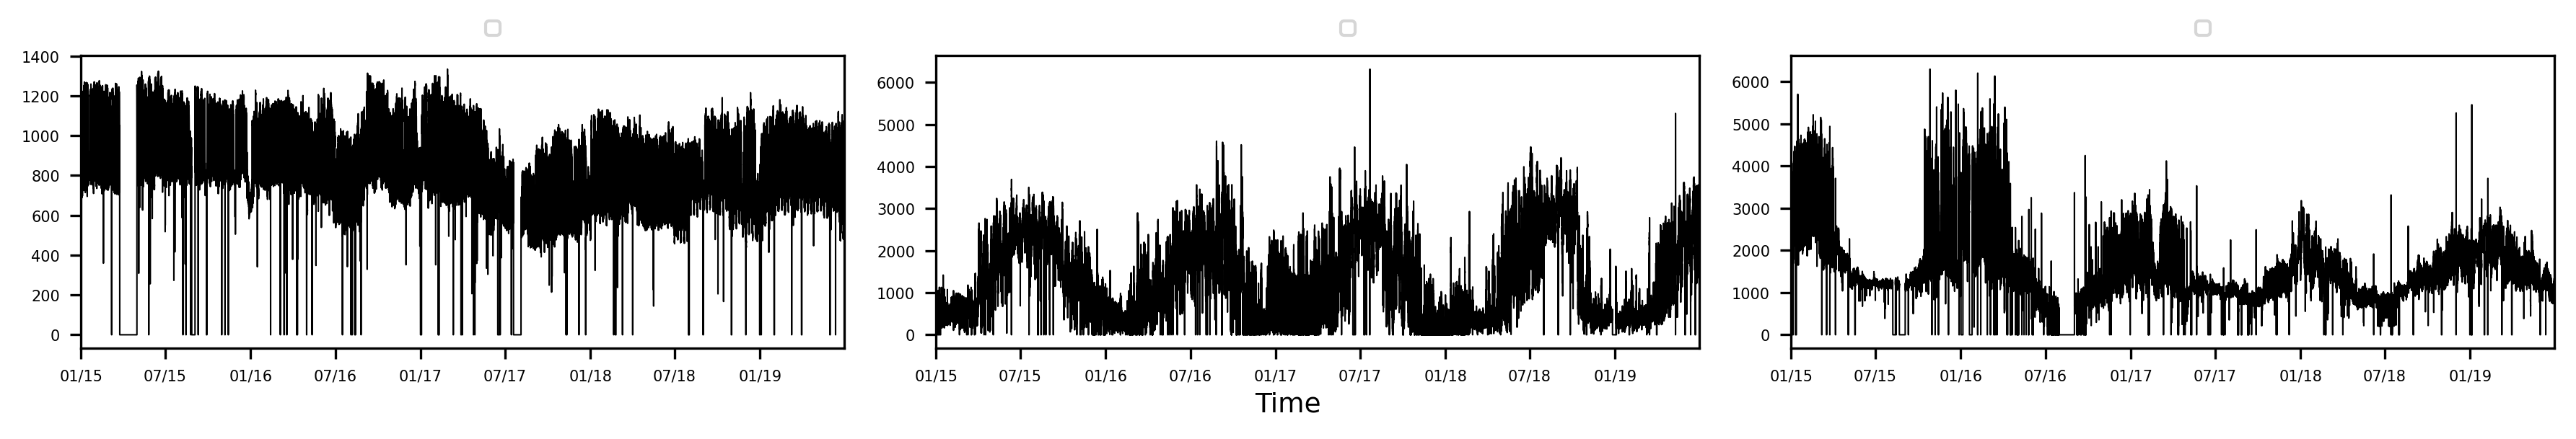

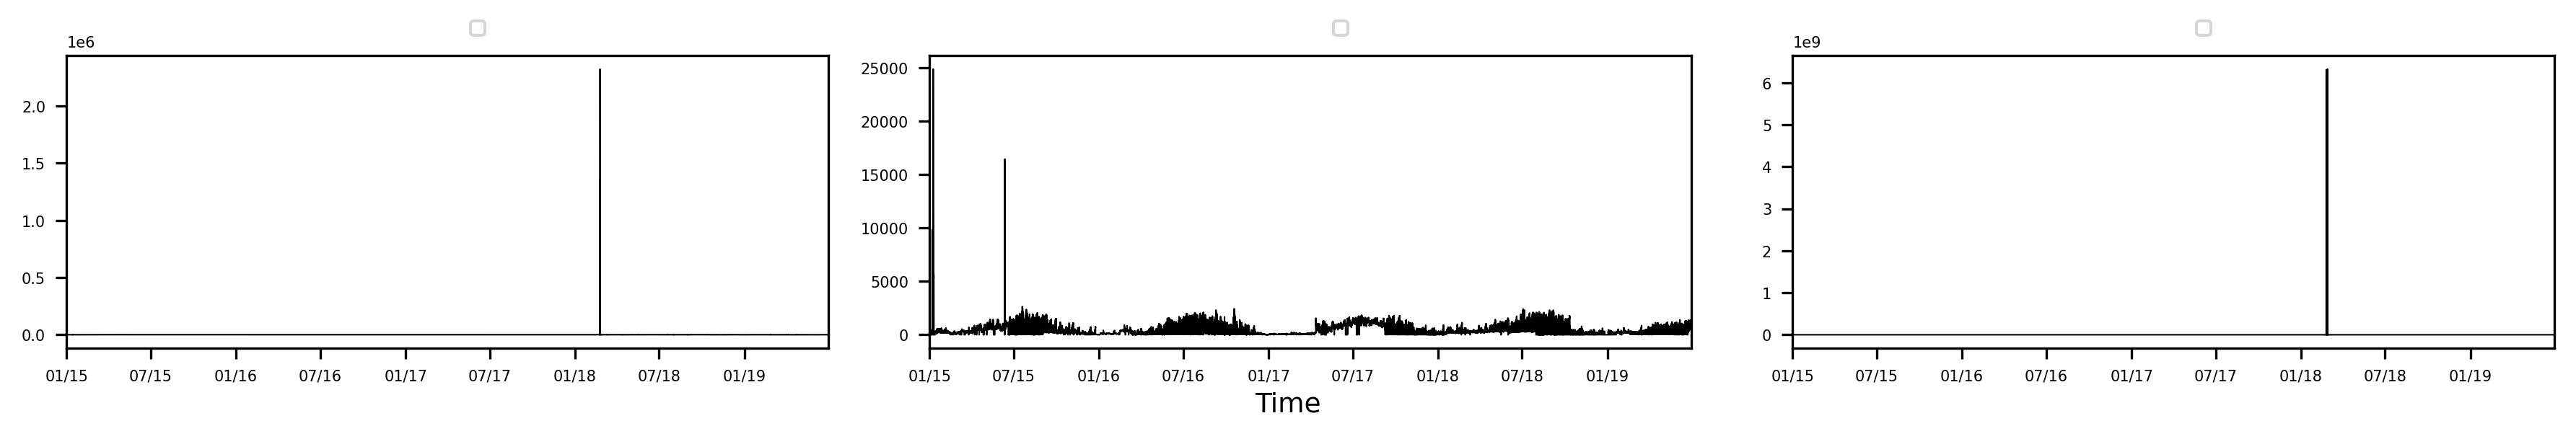

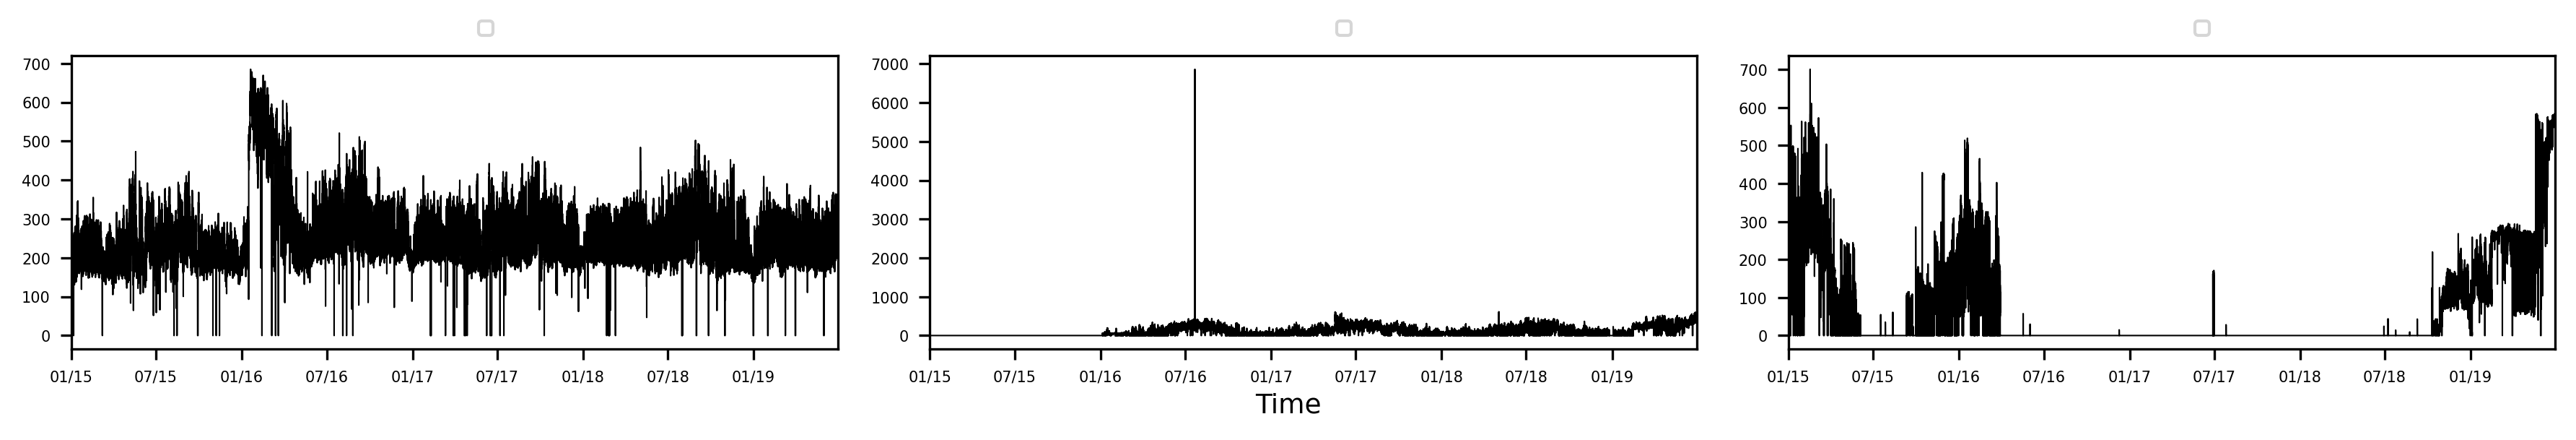

In [ ]:
from IPython.display import Image, display
display(Image('/content/gdrive/MyDrive/PennEnergyData/Figures/raw_data/Evans.png'))
display(Image('/content/gdrive/MyDrive/PennEnergyData/Figures/raw_data/Class of 1920 Dining Commons.png'))
display(Image('/content/gdrive/MyDrive/PennEnergyData/Figures/raw_data/Fels.png'))

The charts below show the same 3 buildings after the outliers have been removed. As can be seen, the second building looks much better after outlier removal, while the third building is still missing too much data to be useful, although it is improved.

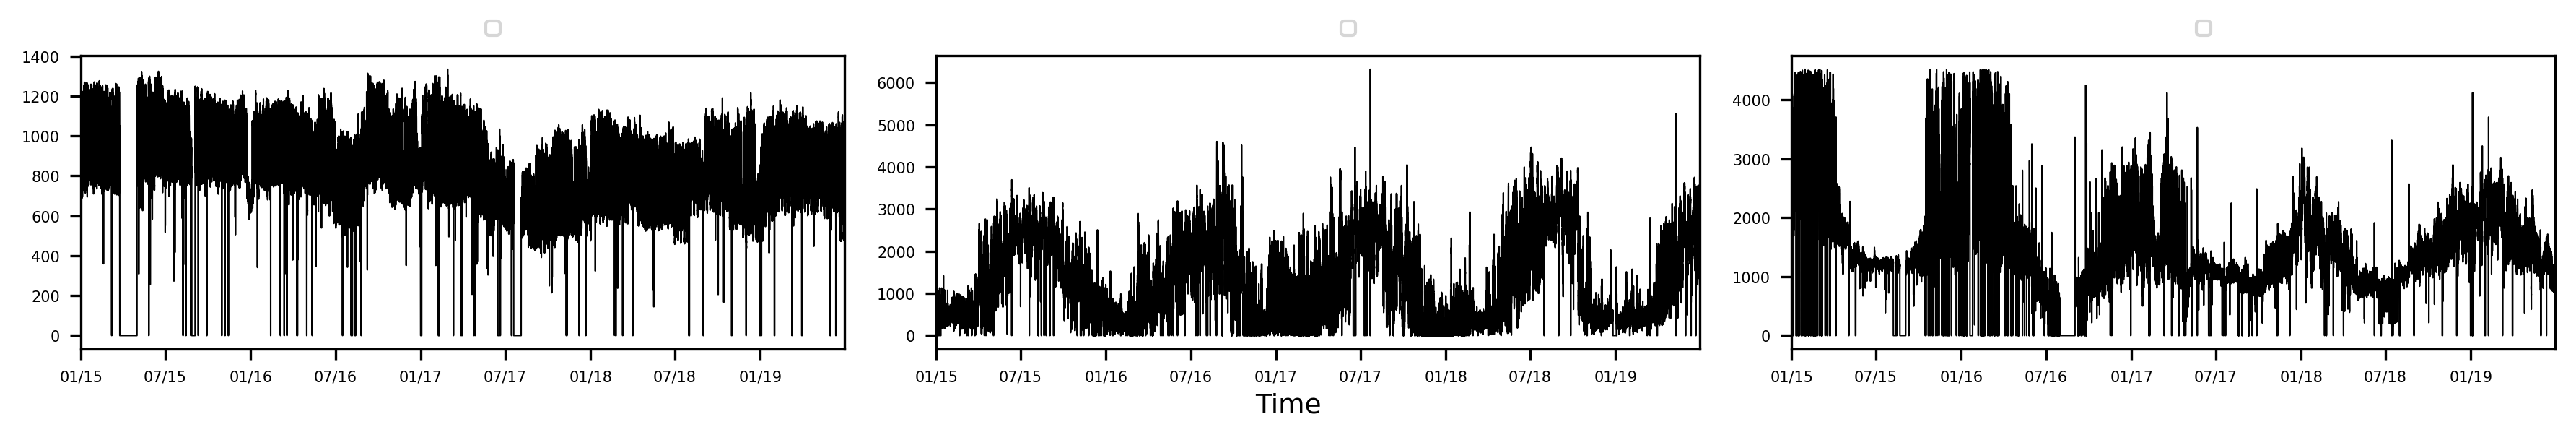

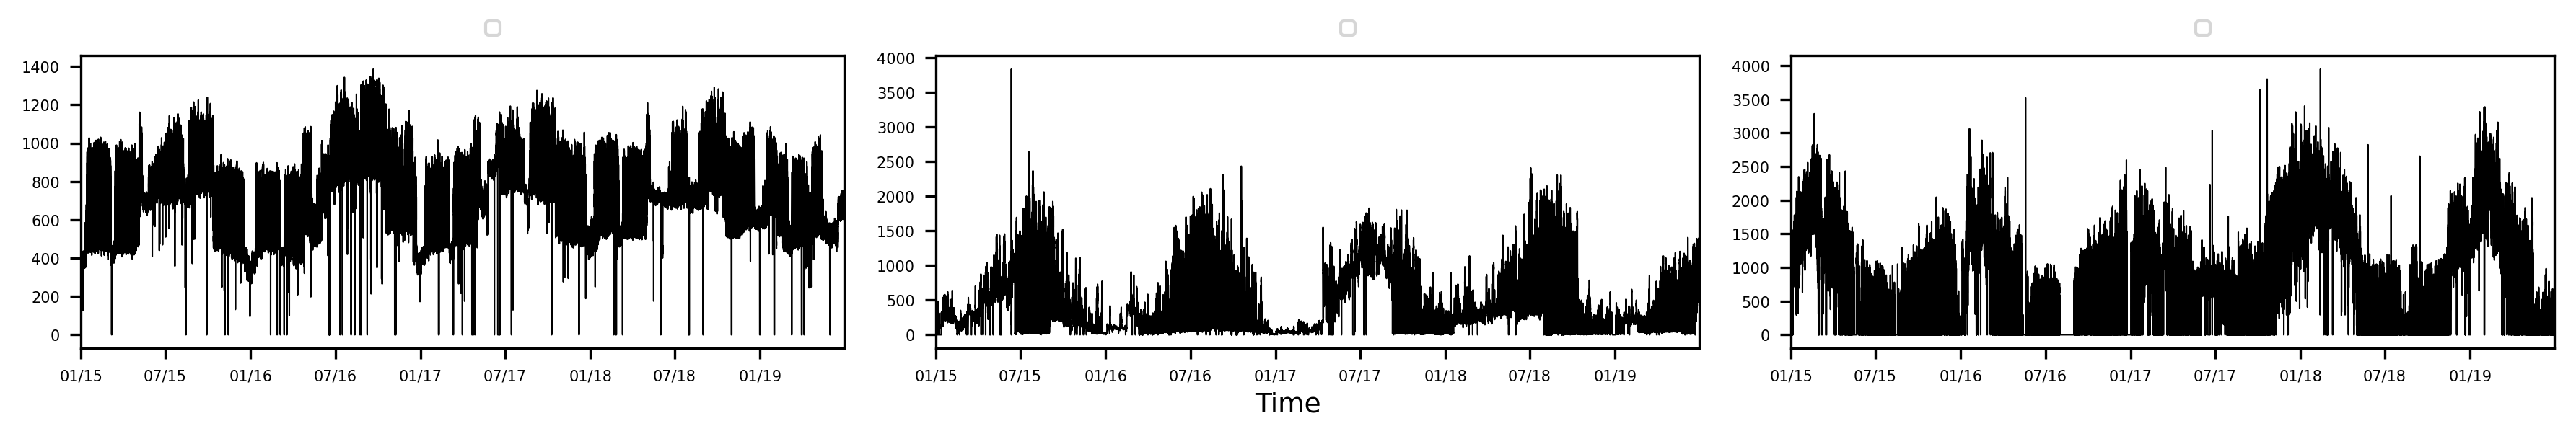

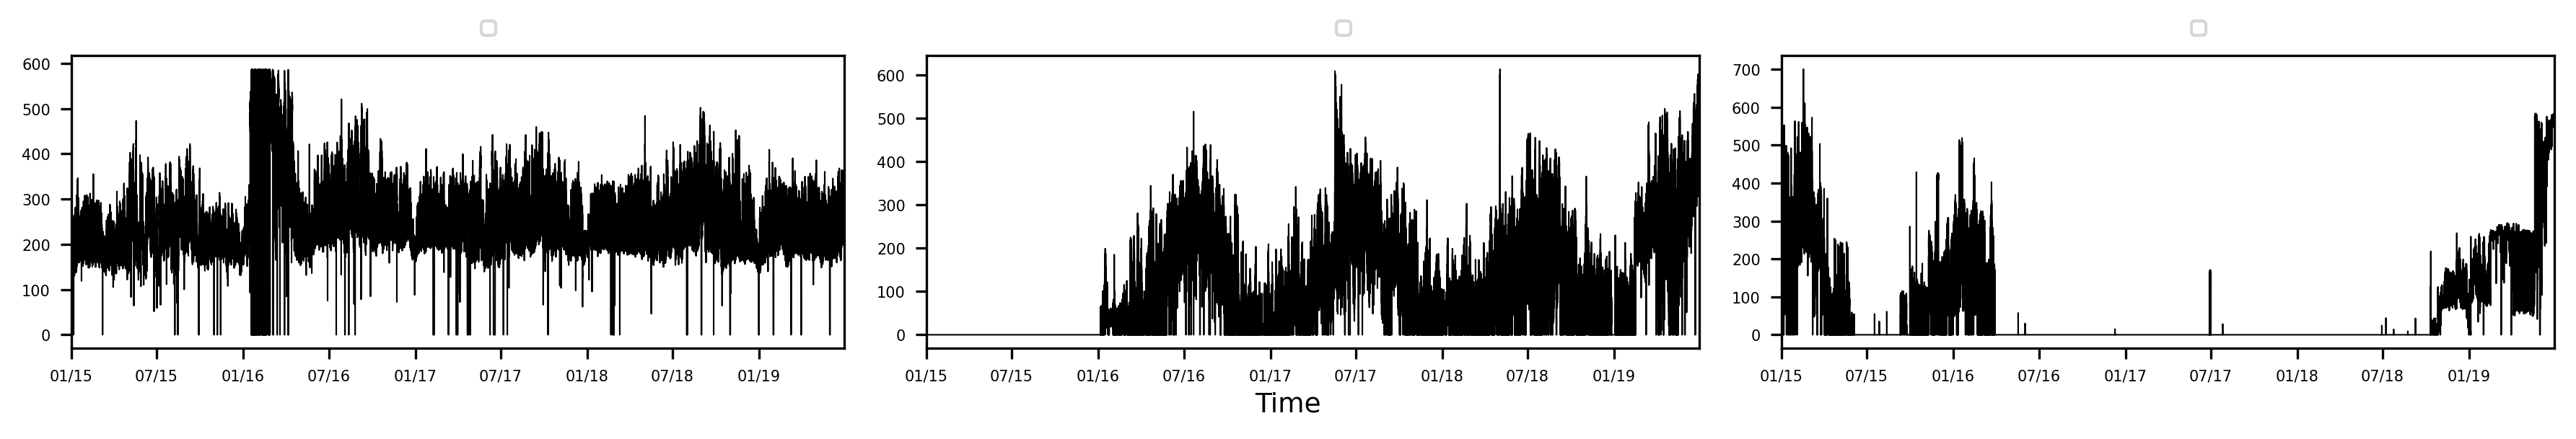

In [ ]:
display(Image('/content/gdrive/MyDrive/PennEnergyData/Figures/raw_data_outliers_removed/Evans.png'))
display(Image('/content/gdrive/MyDrive/PennEnergyData/Figures/raw_data_outliers_removed/Class of 1920 Dining Commons.png'))
display(Image('/content/gdrive/MyDrive/PennEnergyData/Figures/raw_data_outliers_removed/Fels.png'))

In [ ]:
def displayEnergySummary(file):
  building_year_month_df, building_year_df, building_month_df = energyDataSummary(file)

  fig, axes = plt.subplots(nrows=1, ncols=3)
  fig.set_size_inches(15,2)
  building_year_month_df[['max_elc', 'ave_elc', 'min_elc']].plot(ax=axes[0])
  building_year_month_df[['max_chw', 'ave_chw', 'min_chw']].plot(ax=axes[1])
  building_year_month_df[['max_stm', 'ave_stm', 'min_stm']].plot(ax=axes[2])

  fig, axes = plt.subplots(nrows=1, ncols=3)
  fig.set_size_inches(15,2)
  building_month_df[['max_elc', 'ave_elc', 'min_elc']].plot(ax=axes[0])
  building_month_df[['max_chw', 'ave_chw', 'min_chw']].plot(ax=axes[1])
  building_month_df[['max_stm', 'ave_stm', 'min_stm']].plot(ax=axes[2])

  fig, axes = plt.subplots(nrows=1, ncols=3)
  fig.set_size_inches(15,2)
  building_year_df[['max_elc', 'ave_elc', 'min_elc']].plot(ax=axes[0])
  building_year_df[['max_chw', 'ave_chw', 'min_chw']].plot(ax=axes[1])
  building_year_df[['max_stm', 'ave_stm', 'min_stm']].plot(ax=axes[2])

In [ ]:
def joinEnergySummary(df, joinon):
  print(df)
  mean_df = df[[joinon, 'ELC', 'CHW', 'STM']].groupby(joinon).mean()
  mean_df.columns = ['ave_elc', 'ave_chw', 'ave_stm']
  max_df = df[[joinon, 'ELC', 'CHW', 'STM']].groupby(joinon).max()
  max_df.columns = ['max_elc', 'max_chw', 'max_stm']
  min_df = df[[joinon, 'ELC', 'CHW', 'STM']].groupby(joinon).min()
  min_df.columns = ['min_elc', 'min_chw', 'min_stm']
  ret_df = min_df.merge(mean_df, on=joinon, how='inner').merge(max_df, on=joinon, how='inner')
  return ret_df

In [ ]:
def energyDataSummary(file):
  building_df = pd.read_csv('/content/gdrive/MyDrive/PennEnergyData/Buildings/raw_data_outliers_removed/'+file)
  building_df['Time'].astype('datetime64')
  building_df['date'] = building_df['Time'].map(lambda x: x.split(' ')[0])
  building_df['year_month'] = building_df['Time'].map(lambda x: x.split('-')[0]+' '+x.split('-')[1])
  building_df['year'] = building_df['Time'].map(lambda x: x.split('-')[0])
  building_df['month'] = building_df['Time'].map(lambda x: x.split('-')[1])

  building_year_month_df = joinEnergySummary(building_df, 'year_month')
  building_year_df = joinEnergySummary(building_df, 'year')
  building_month_df = joinEnergySummary(building_df, 'month')
  
  return building_year_month_df, building_year_df, building_month_df

The following shows the outlier removed energy charts for the 10 buildings that were chosen. They are:

1.    The Annenberg Center

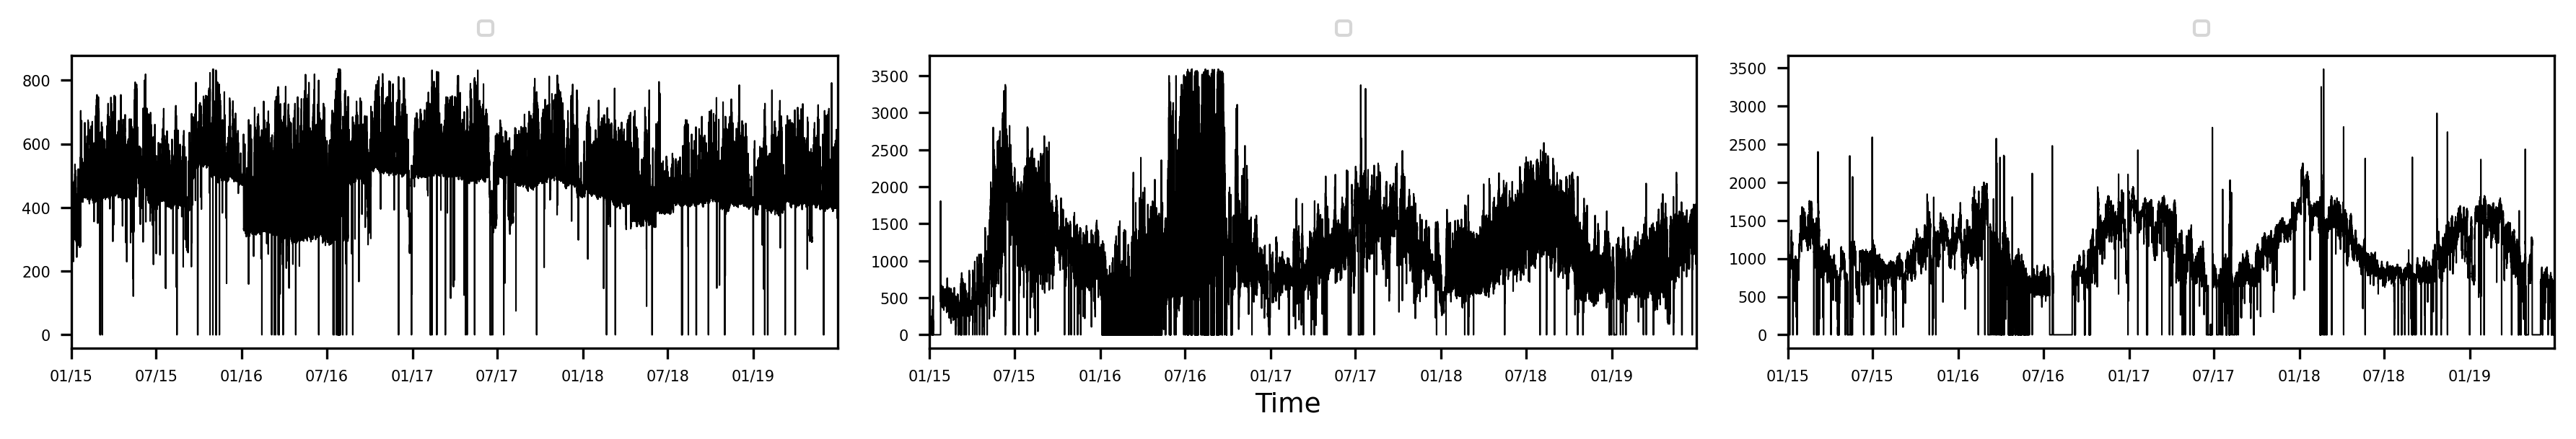

                       Time         ELC      CHW  ...  year_month  year month
0       2015-01-01 00:00:00  271.845353     0.00  ...     2015 01  2015    01
1       2015-01-01 00:15:00  269.559218     0.00  ...     2015 01  2015    01
2       2015-01-01 00:30:00  276.383502     0.00  ...     2015 01  2015    01
3       2015-01-01 00:45:00  277.509509     0.00  ...     2015 01  2015    01
4       2015-01-01 01:00:00  267.853147     0.00  ...     2015 01  2015    01
...                     ...         ...      ...  ...         ...   ...   ...
157627  2019-06-30 22:45:00  408.320000  1057.59  ...     2019 06  2019    06
157628  2019-06-30 23:00:00  395.810000  1070.79  ...     2019 06  2019    06
157629  2019-06-30 23:15:00  402.630000  1238.58  ...     2019 06  2019    06
157630  2019-06-30 23:30:00  398.080000  1101.45  ...     2019 06  2019    06
157631  2019-06-30 23:45:00  390.120000  1177.01  ...     2019 06  2019    06

[157632 rows x 8 columns]
                       Time         E

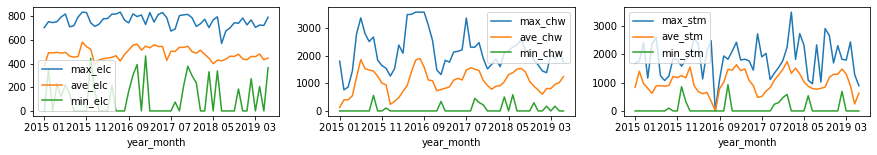

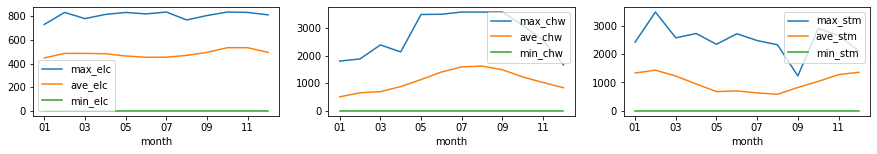

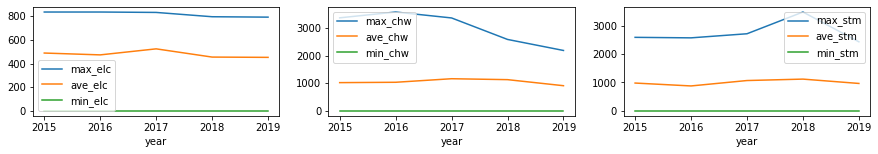

In [ ]:
display(Image('/content/gdrive/MyDrive/PennEnergyData/Figures/raw_data_outliers_removed/Annenberg Center.png'))
displayEnergySummary('Annenberg Center.csv')

2.    Blockley Hall

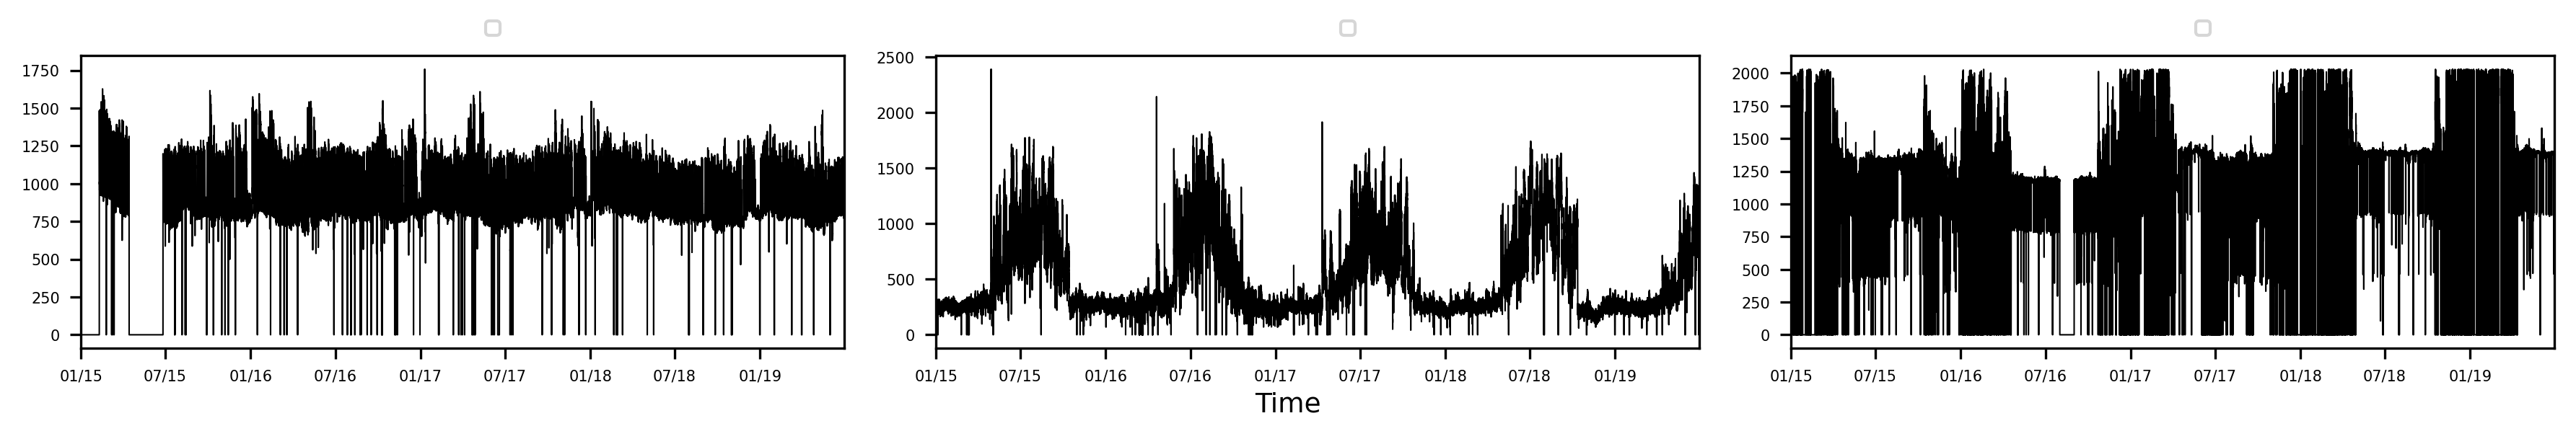

                       Time     ELC     CHW  ...  year_month  year month
0       2015-01-01 00:00:00    0.00    0.00  ...     2015 01  2015    01
1       2015-01-01 00:15:00    0.00    0.00  ...     2015 01  2015    01
2       2015-01-01 00:30:00    0.00    0.00  ...     2015 01  2015    01
3       2015-01-01 00:45:00    0.00    0.00  ...     2015 01  2015    01
4       2015-01-01 01:00:00    0.00    0.00  ...     2015 01  2015    01
...                     ...     ...     ...  ...         ...   ...   ...
157627  2019-06-30 22:45:00  814.36  686.28  ...     2019 06  2019    06
157628  2019-06-30 23:00:00  812.09  697.28  ...     2019 06  2019    06
157629  2019-06-30 23:15:00  807.54  664.44  ...     2019 06  2019    06
157630  2019-06-30 23:30:00  807.54  645.55  ...     2019 06  2019    06
157631  2019-06-30 23:45:00  817.78  639.68  ...     2019 06  2019    06

[157632 rows x 8 columns]
                       Time     ELC     CHW  ...  year_month  year month
0       2015-01-01 00:00

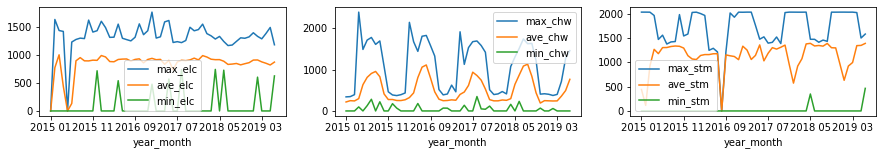

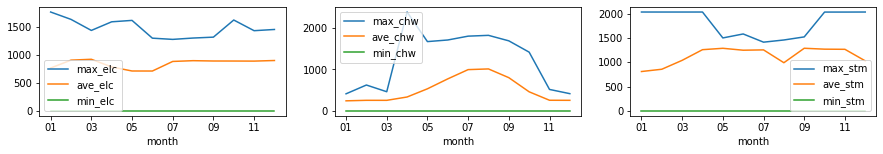

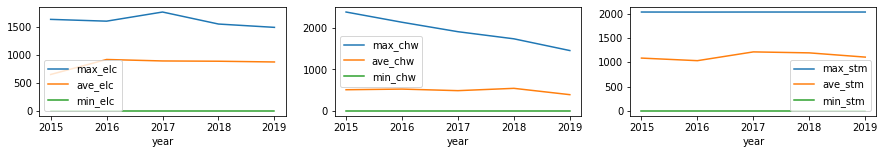

In [ ]:
display(Image('/content/gdrive/MyDrive/PennEnergyData/Figures/raw_data_outliers_removed/Blockley Hall.png'))
displayEnergySummary('Blockley Hall.csv')

3.    BRB1-Stellar Chance

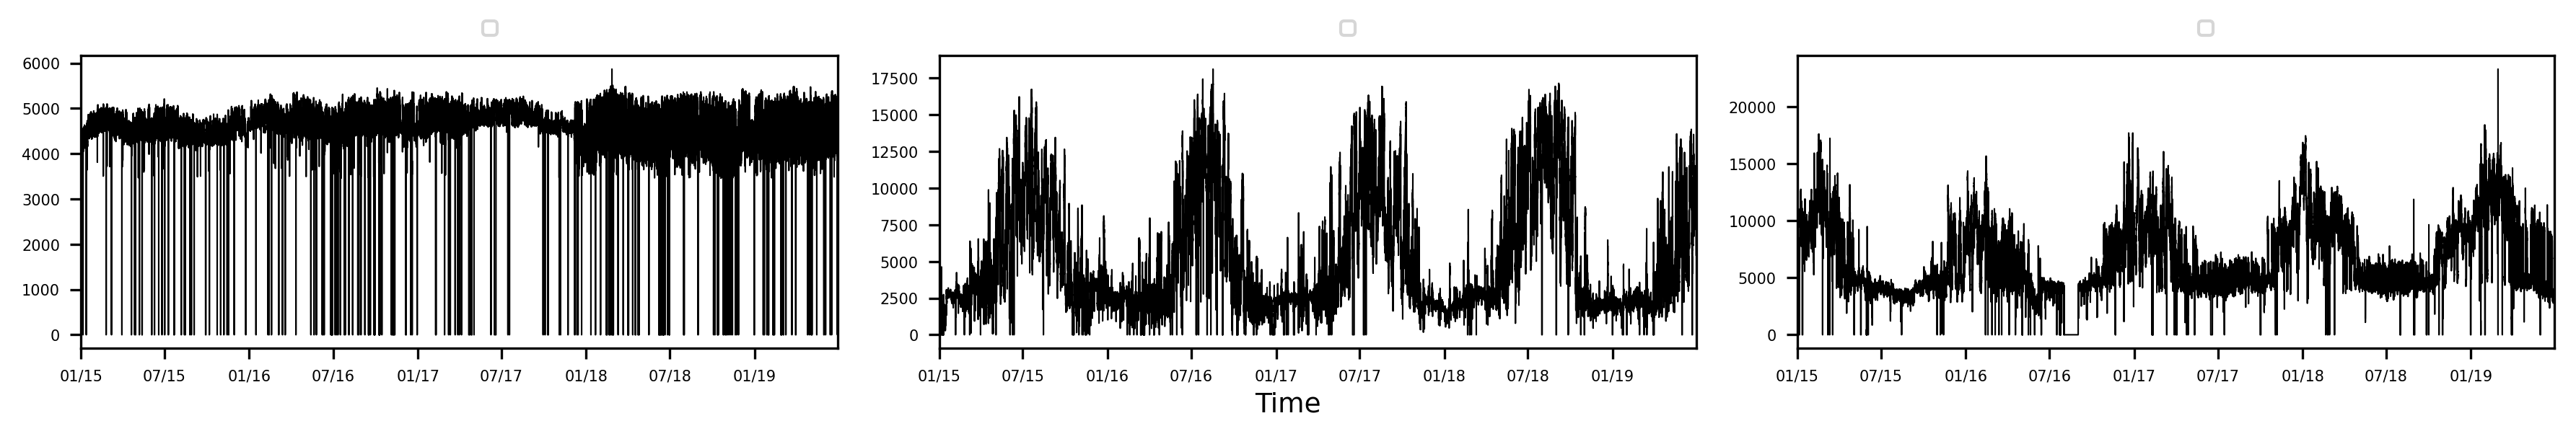

                       Time          ELC      CHW  ...  year_month  year month
0       2015-01-01 00:00:00  4128.691815     0.00  ...     2015 01  2015    01
1       2015-01-01 00:15:00  4122.993538     0.00  ...     2015 01  2015    01
2       2015-01-01 00:30:00  4111.631105     0.00  ...     2015 01  2015    01
3       2015-01-01 00:45:00  4087.746111     0.00  ...     2015 01  2015    01
4       2015-01-01 01:00:00  4075.803614     0.00  ...     2015 01  2015    01
...                     ...          ...      ...  ...         ...   ...   ...
157627  2019-06-30 22:45:00  3828.460000  6009.32  ...     2019 06  2019    06
157628  2019-06-30 23:00:00  3794.880000  6004.03  ...     2019 06  2019    06
157629  2019-06-30 23:15:00  3835.040000  5788.33  ...     2019 06  2019    06
157630  2019-06-30 23:30:00  3841.020000  5608.11  ...     2019 06  2019    06
157631  2019-06-30 23:45:00  3781.590000  5435.99  ...     2019 06  2019    06

[157632 rows x 8 columns]
                       Ti

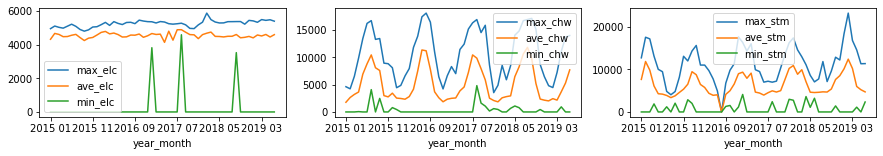

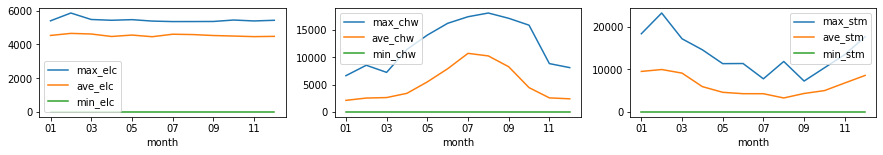

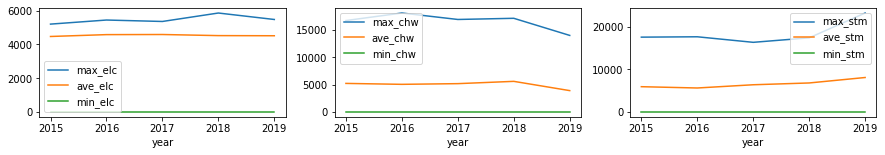

In [ ]:
display(Image('/content/gdrive/MyDrive/PennEnergyData/Figures/raw_data_outliers_removed/BRB I Stellar Chance.png'))
displayEnergySummary('BRB I Stellar Chance.csv')

4.    Charles Addams Hall

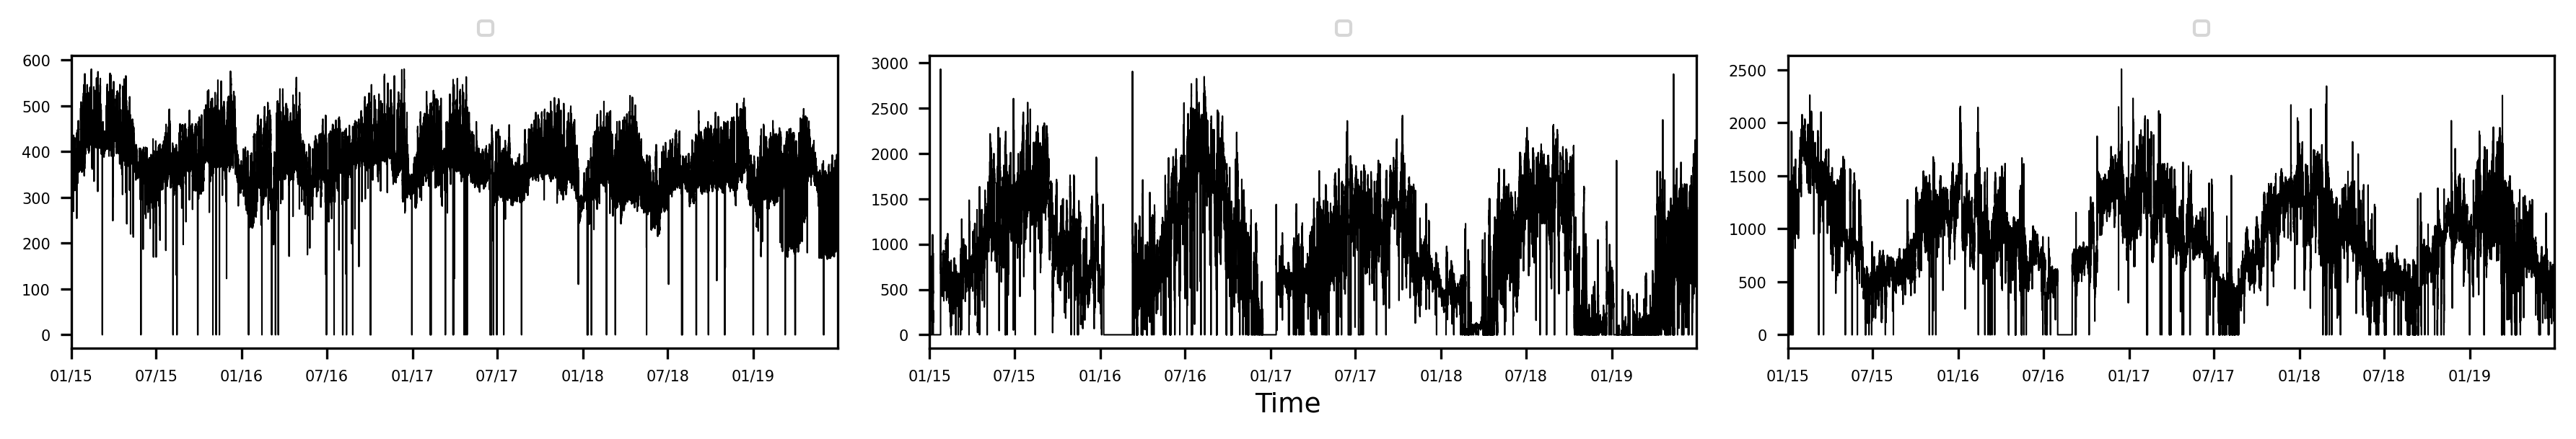

                       Time         ELC      CHW  ...  year_month  year month
0       2015-01-01 00:00:00  341.214200     0.00  ...     2015 01  2015    01
1       2015-01-01 00:15:00  342.340206     0.00  ...     2015 01  2015    01
2       2015-01-01 00:30:00  346.912477     0.00  ...     2015 01  2015    01
3       2015-01-01 00:45:00  345.752348     0.00  ...     2015 01  2015    01
4       2015-01-01 01:00:00  341.214200     0.00  ...     2015 01  2015    01
...                     ...         ...      ...  ...         ...   ...   ...
157627  2019-06-30 22:45:00  337.800000  1349.12  ...     2019 06  2019    06
157628  2019-06-30 23:00:00  327.570000  1377.98  ...     2019 06  2019    06
157629  2019-06-30 23:15:00  333.250000  1351.91  ...     2019 06  2019    06
157630  2019-06-30 23:30:00  328.700000  1331.81  ...     2019 06  2019    06
157631  2019-06-30 23:45:00  337.800000  1322.77  ...     2019 06  2019    06

[157632 rows x 8 columns]
                       Time         E

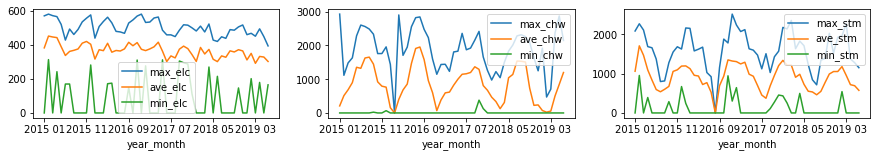

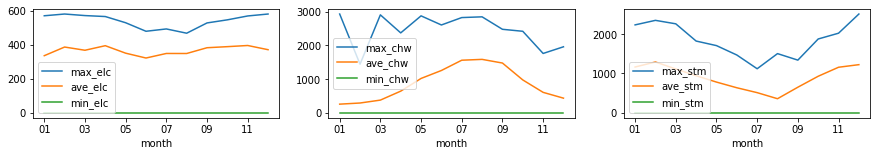

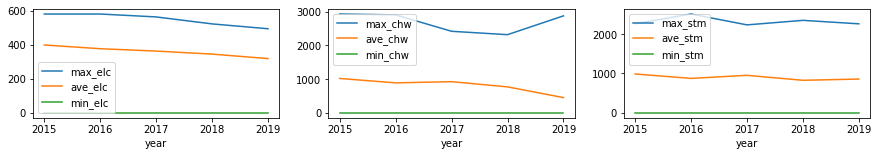

In [ ]:
display(Image('/content/gdrive/MyDrive/PennEnergyData/Figures/raw_data_outliers_removed/Charles Addams.png'))
displayEnergySummary('Charles Addams.csv')

5.    Fisher Fine Arts and Duhring Wing

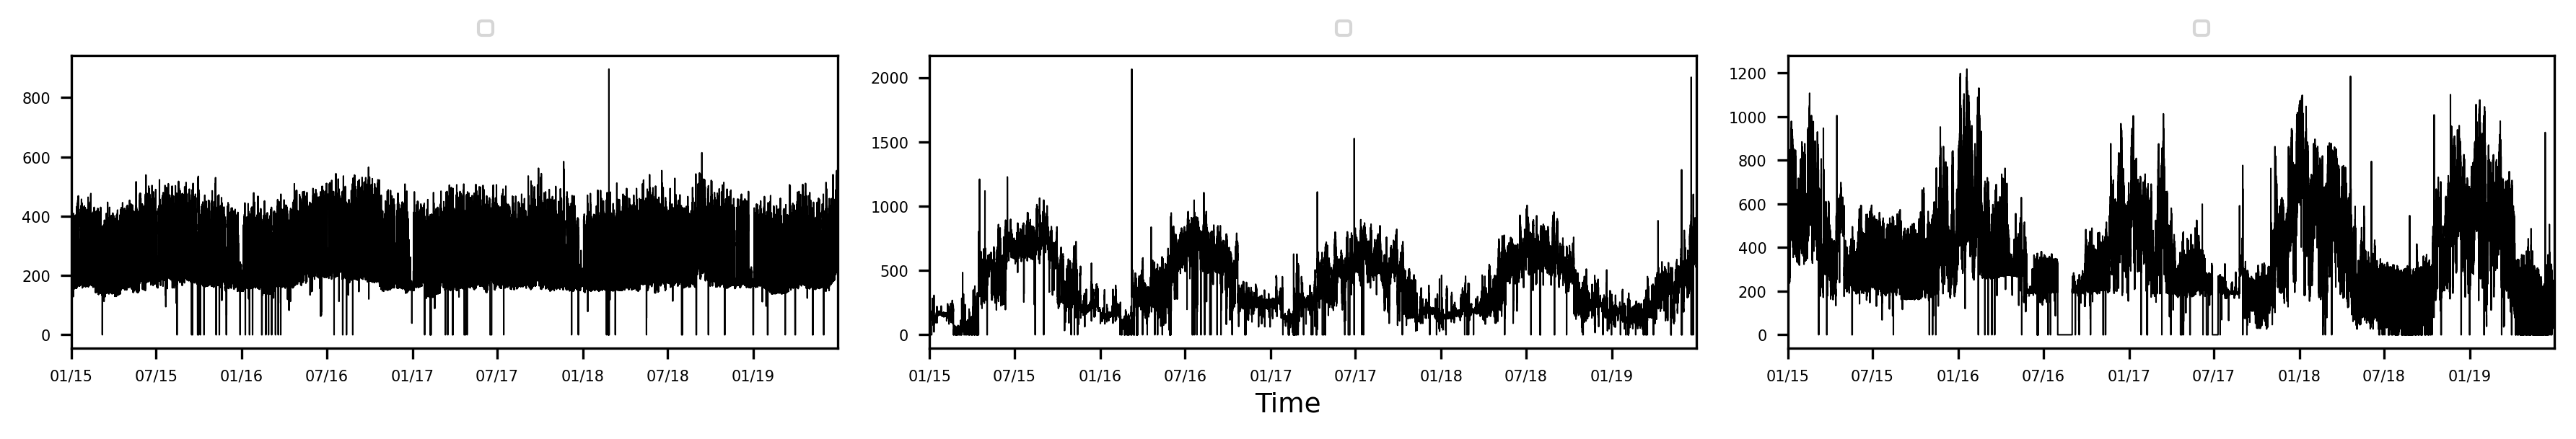

                       Time     ELC     CHW  ...  year_month  year month
0       2015-01-01 00:00:00    0.00    0.00  ...     2015 01  2015    01
1       2015-01-01 00:15:00    0.00    0.00  ...     2015 01  2015    01
2       2015-01-01 00:30:00    0.00    0.00  ...     2015 01  2015    01
3       2015-01-01 00:45:00    0.00    0.00  ...     2015 01  2015    01
4       2015-01-01 01:00:00    0.00    0.00  ...     2015 01  2015    01
...                     ...     ...     ...  ...         ...   ...   ...
157627  2019-06-30 22:45:00  216.10  587.21  ...     2019 06  2019    06
157628  2019-06-30 23:00:00  219.51  577.65  ...     2019 06  2019    06
157629  2019-06-30 23:15:00  226.34  561.85  ...     2019 06  2019    06
157630  2019-06-30 23:30:00  239.99  529.29  ...     2019 06  2019    06
157631  2019-06-30 23:45:00  241.12  538.64  ...     2019 06  2019    06

[157632 rows x 8 columns]
                       Time     ELC     CHW  ...  year_month  year month
0       2015-01-01 00:00

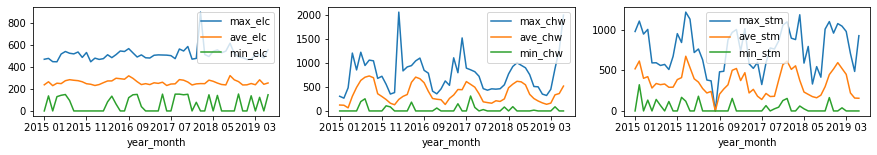

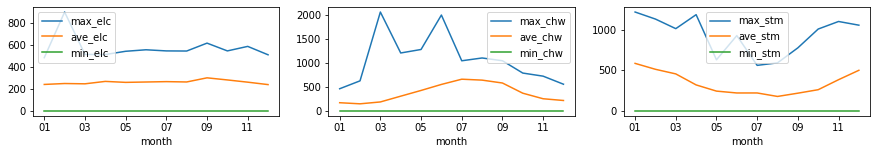

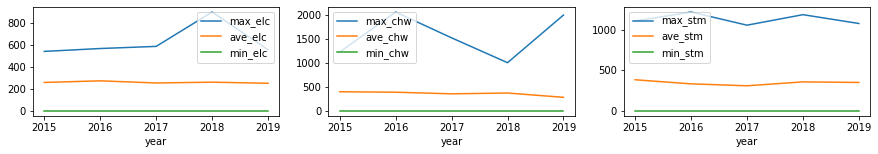

In [ ]:
display(Image('/content/gdrive/MyDrive/PennEnergyData/Figures/raw_data_outliers_removed/Fisher and Duhring Wing.png'))
displayEnergySummary('Fisher and Duhring Wing.csv')

6.    Grad Towers B- Sansom West

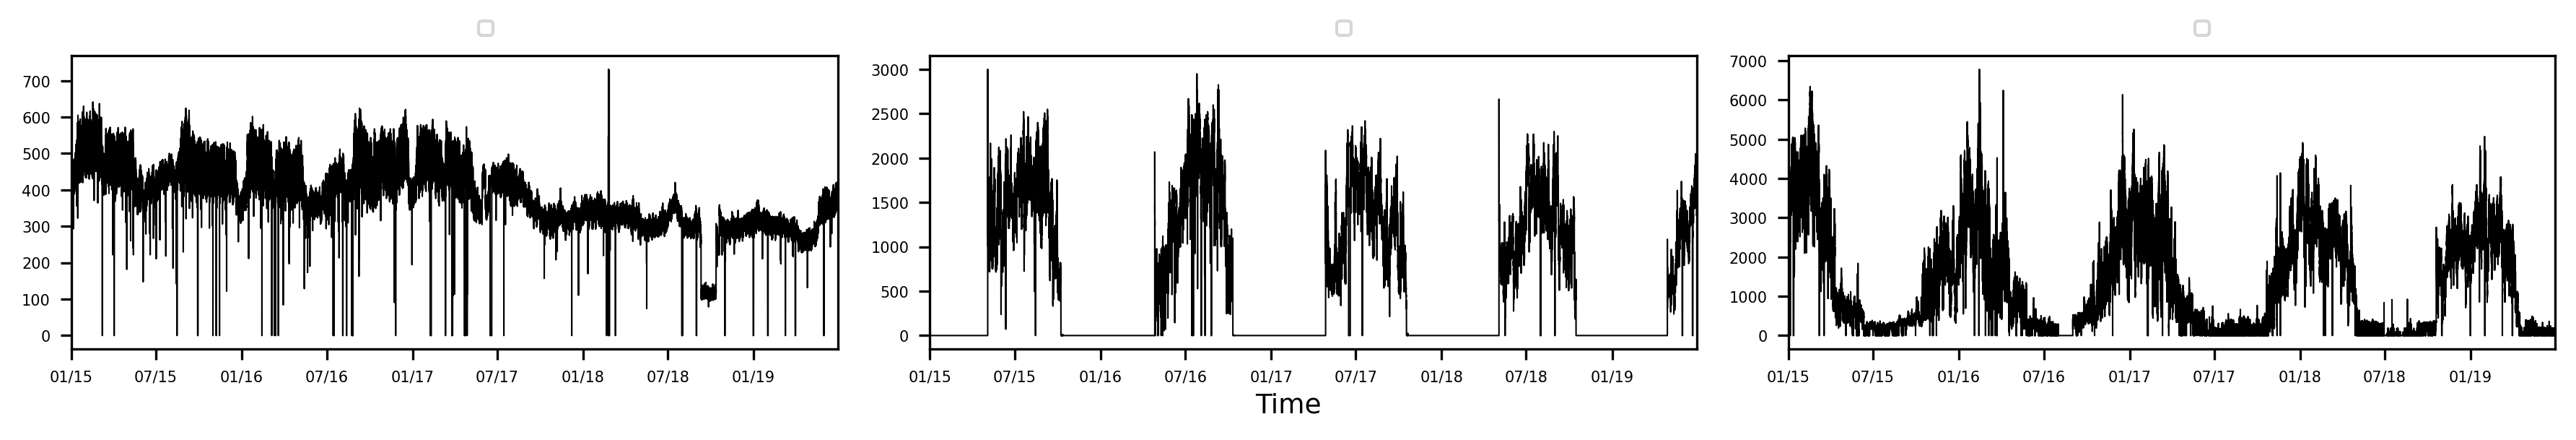

                       Time         ELC      CHW  ...  year_month  year month
0       2015-01-01 00:00:00  416.281324     0.00  ...     2015 01  2015    01
1       2015-01-01 00:15:00  416.281324     0.00  ...     2015 01  2015    01
2       2015-01-01 00:30:00  408.331033     0.00  ...     2015 01  2015    01
3       2015-01-01 00:45:00  399.220614     0.00  ...     2015 01  2015    01
4       2015-01-01 01:00:00  414.575253     0.00  ...     2015 01  2015    01
...                     ...         ...      ...  ...         ...   ...   ...
157627  2019-06-30 22:45:00  383.790000  1382.04  ...     2019 06  2019    06
157628  2019-06-30 23:00:00  385.700000  1386.47  ...     2019 06  2019    06
157629  2019-06-30 23:15:00  389.110000  1355.31  ...     2019 06  2019    06
157630  2019-06-30 23:30:00  390.220000  1369.76  ...     2019 06  2019    06
157631  2019-06-30 23:45:00  393.050000  1365.10  ...     2019 06  2019    06

[157632 rows x 8 columns]
                       Time         E

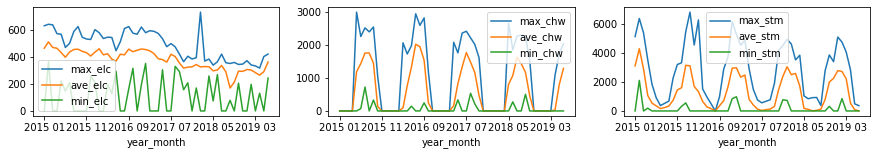

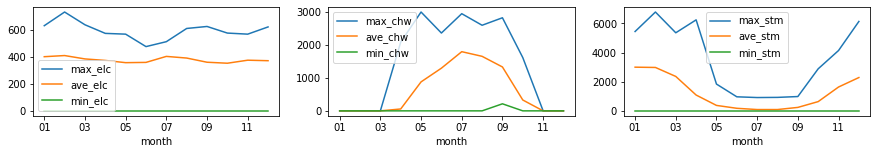

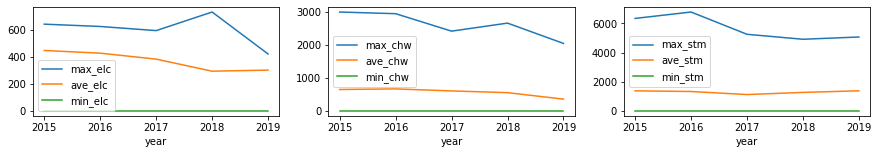

In [ ]:
display(Image('/content/gdrive/MyDrive/PennEnergyData/Figures/raw_data_outliers_removed/Grad Towers B (West).png'))
displayEnergySummary('Grad Towers B (West).csv')

7.    Johnson Pavilion

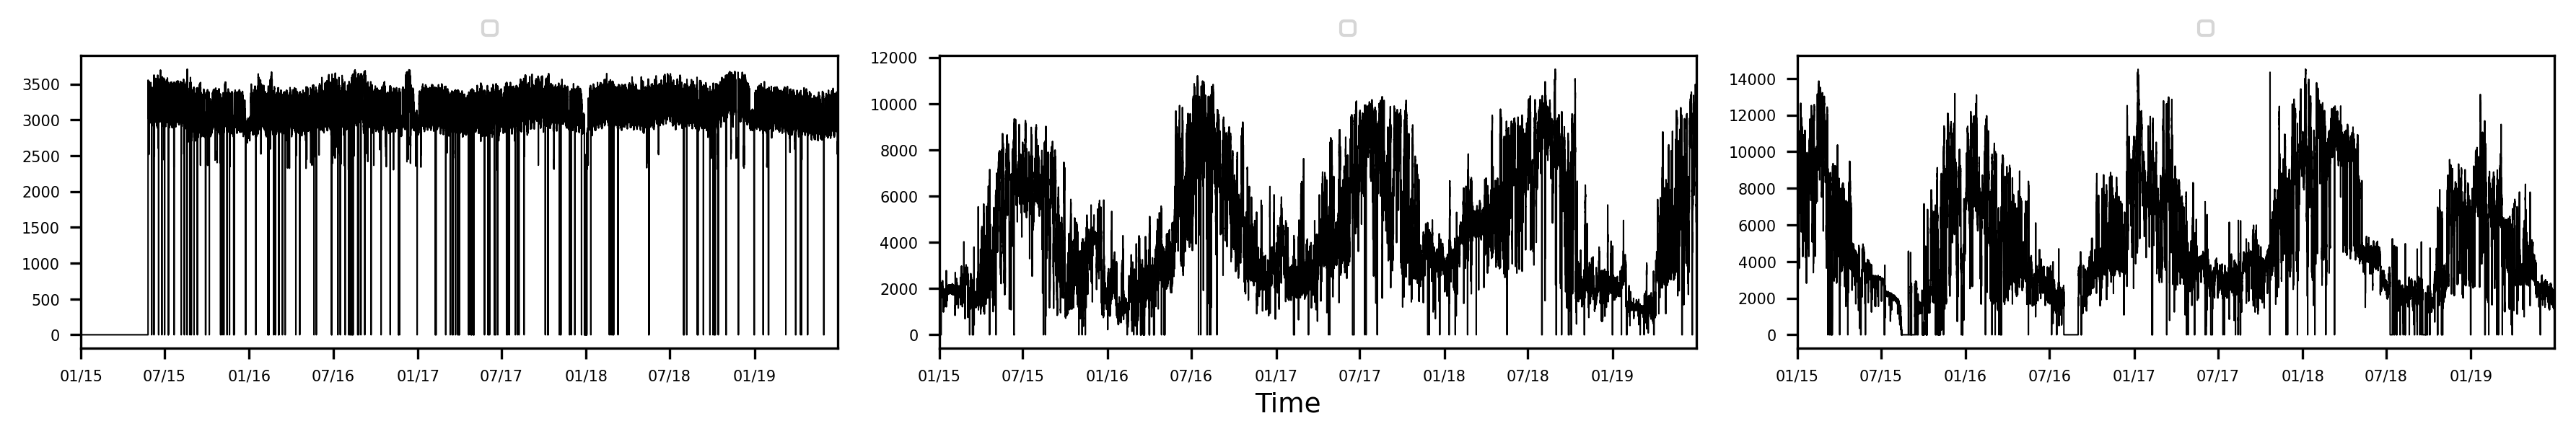

                       Time      ELC      CHW  ...  year_month  year month
0       2015-01-01 00:00:00     0.00     0.00  ...     2015 01  2015    01
1       2015-01-01 00:15:00     0.00     0.00  ...     2015 01  2015    01
2       2015-01-01 00:30:00     0.00     0.00  ...     2015 01  2015    01
3       2015-01-01 00:45:00     0.00     0.00  ...     2015 01  2015    01
4       2015-01-01 01:00:00     0.00     0.00  ...     2015 01  2015    01
...                     ...      ...      ...  ...         ...   ...   ...
157627  2019-06-30 22:45:00  2552.28  5227.43  ...     2019 06  2019    06
157628  2019-06-30 23:00:00  2571.62  5179.68  ...     2019 06  2019    06
157629  2019-06-30 23:15:00  2580.72  5279.45  ...     2019 06  2019    06
157630  2019-06-30 23:30:00  2529.53  5076.40  ...     2019 06  2019    06
157631  2019-06-30 23:45:00  2580.72  4892.78  ...     2019 06  2019    06

[157632 rows x 8 columns]
                       Time      ELC      CHW  ...  year_month  year mont

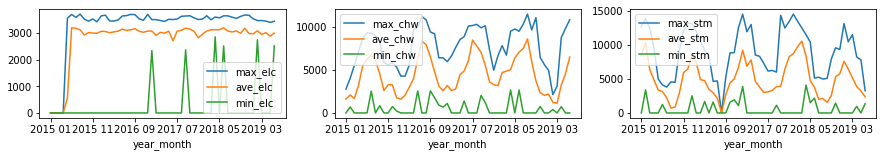

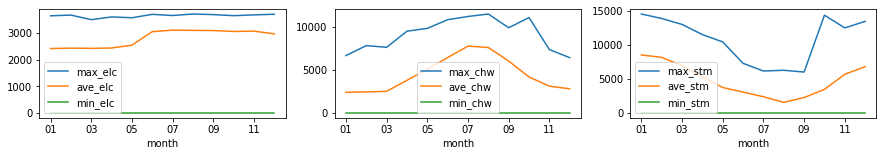

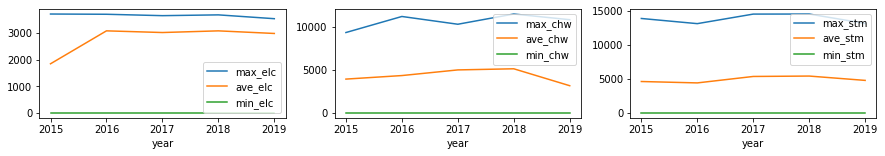

In [ ]:
display(Image('/content/gdrive/MyDrive/PennEnergyData/Figures/raw_data_outliers_removed/Johnson Pavillion.png'))
displayEnergySummary('Johnson Pavillion.csv')

8.    The Penn Museum

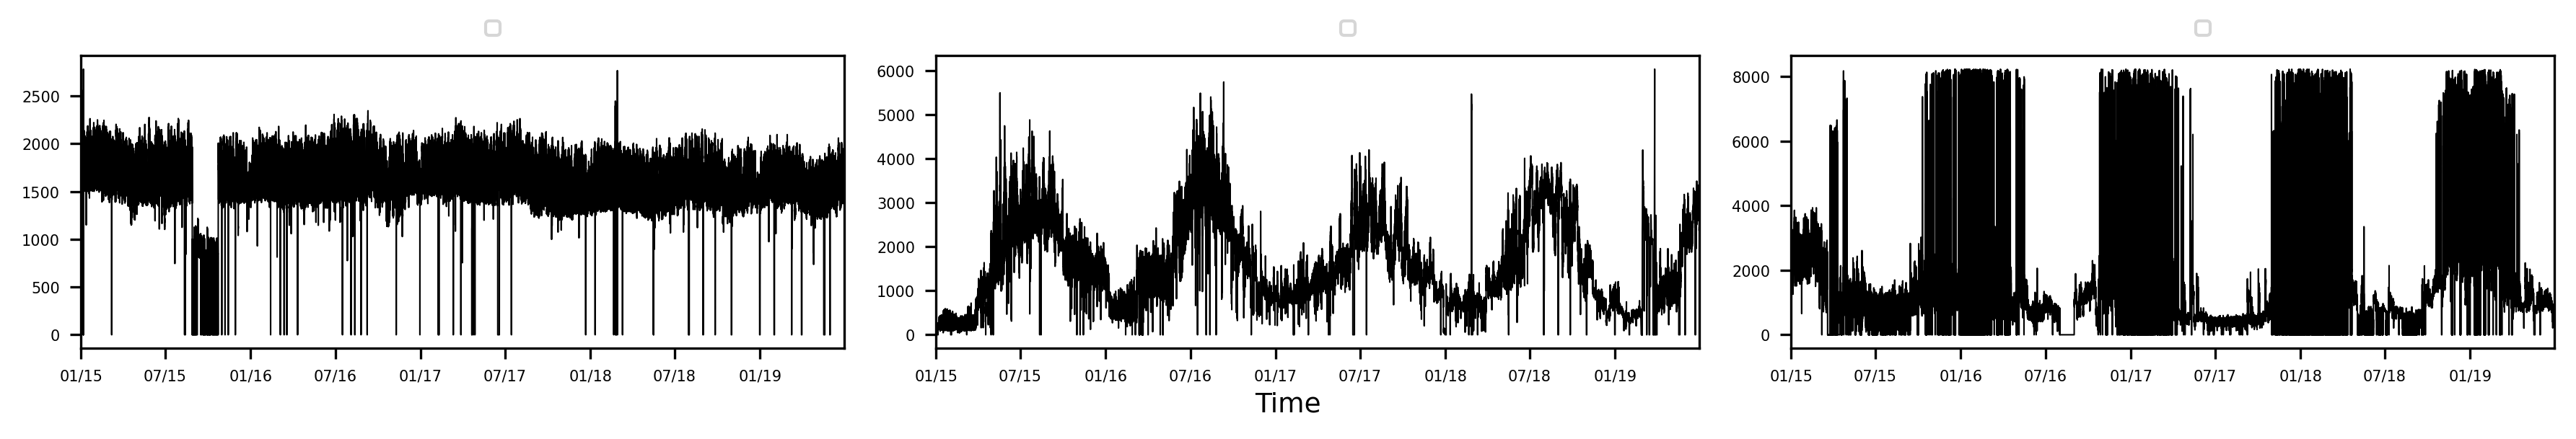

                       Time          ELC      CHW  ...  year_month  year month
0       2015-01-01 00:00:00  1582.995036     0.00  ...     2015 01  2015    01
1       2015-01-01 00:15:00  1540.684475     0.00  ...     2015 01  2015    01
2       2015-01-01 00:30:00  1520.006895     0.00  ...     2015 01  2015    01
3       2015-01-01 00:45:00  1509.531619     0.00  ...     2015 01  2015    01
4       2015-01-01 01:00:00  1523.180187     0.00  ...     2015 01  2015    01
...                     ...          ...      ...  ...         ...   ...   ...
157627  2019-06-30 22:45:00  1456.980000  2400.93  ...     2019 06  2019    06
157628  2019-06-30 23:00:00  1443.560000  2395.92  ...     2019 06  2019    06
157629  2019-06-30 23:15:00  1446.290000  2442.13  ...     2019 06  2019    06
157630  2019-06-30 23:30:00  1451.070000  2359.41  ...     2019 06  2019    06
157631  2019-06-30 23:45:00  1424.230000  2378.61  ...     2019 06  2019    06

[157632 rows x 8 columns]
                       Ti

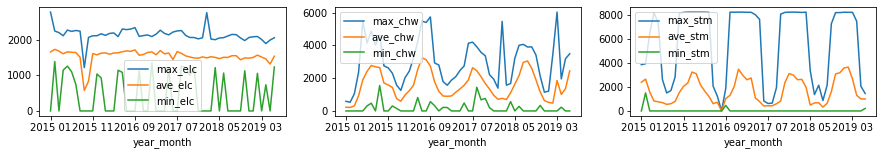

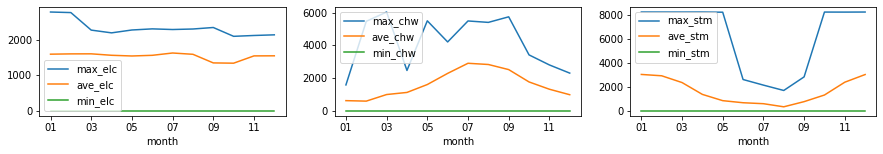

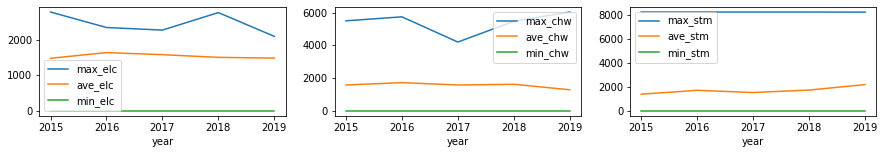

In [ ]:
display(Image('/content/gdrive/MyDrive/PennEnergyData/Figures/raw_data_outliers_removed/Museum.png'))
displayEnergySummary('Museum.csv')

9.    Singh Nanotechnology

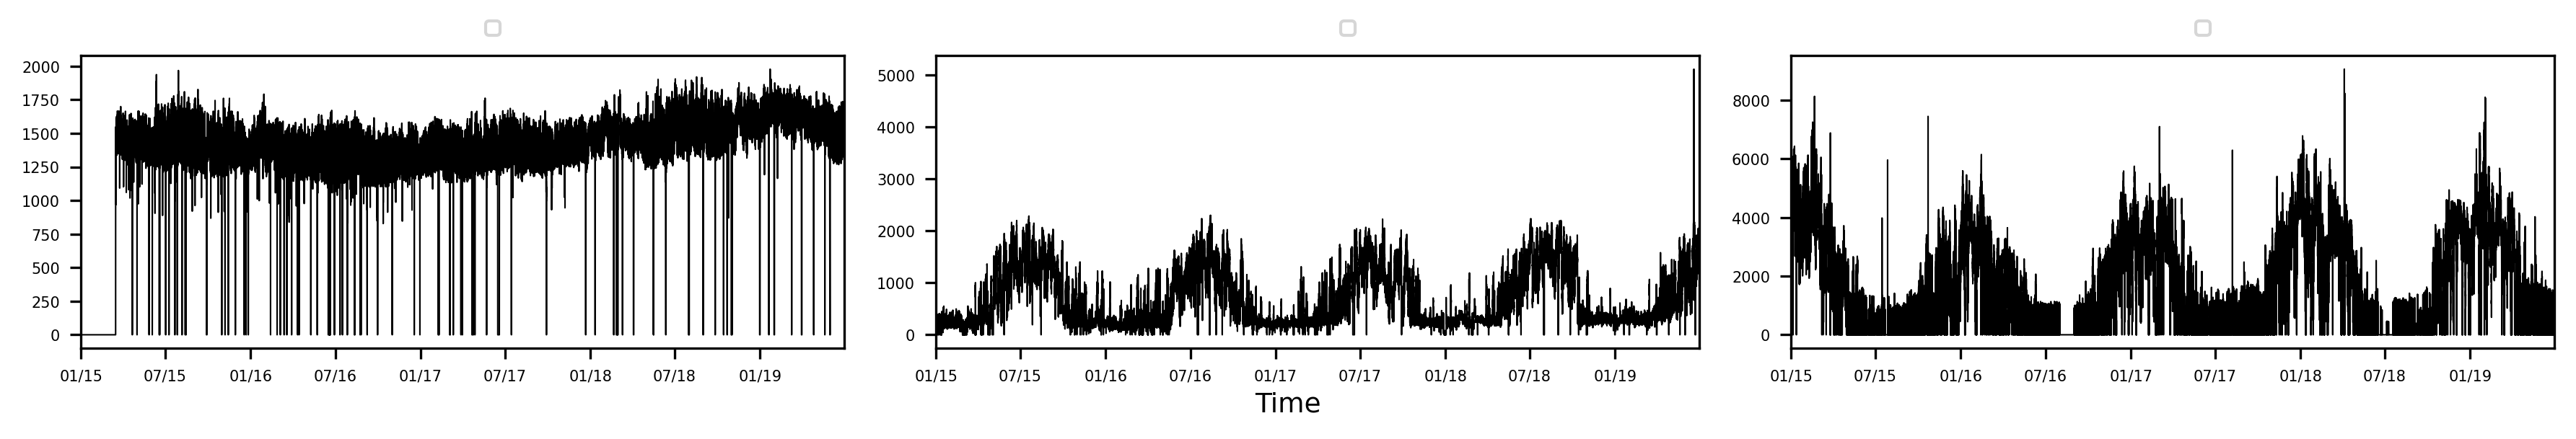

                       Time      ELC      CHW  ...  year_month  year month
0       2015-01-01 00:00:00     0.00     0.00  ...     2015 01  2015    01
1       2015-01-01 00:15:00     0.00     0.00  ...     2015 01  2015    01
2       2015-01-01 00:30:00     0.00     0.00  ...     2015 01  2015    01
3       2015-01-01 00:45:00     0.00     0.00  ...     2015 01  2015    01
4       2015-01-01 01:00:00     0.00     0.00  ...     2015 01  2015    01
...                     ...      ...      ...  ...         ...   ...   ...
157627  2019-06-30 22:45:00  1380.78  1010.50  ...     2019 06  2019    06
157628  2019-06-30 23:00:00  1369.41  1020.83  ...     2019 06  2019    06
157629  2019-06-30 23:15:00  1410.35   986.98  ...     2019 06  2019    06
157630  2019-06-30 23:30:00  1372.82   932.91  ...     2019 06  2019    06
157631  2019-06-30 23:45:00  1304.58   952.62  ...     2019 06  2019    06

[157632 rows x 8 columns]
                       Time      ELC      CHW  ...  year_month  year mont

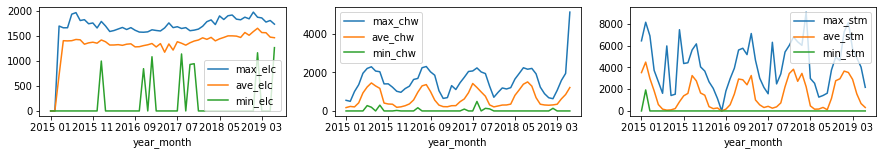

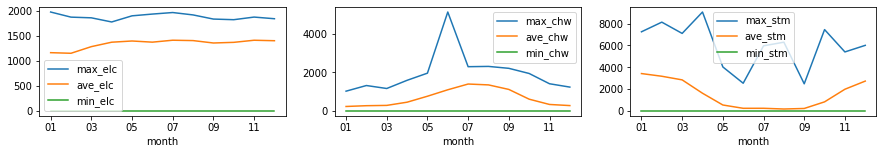

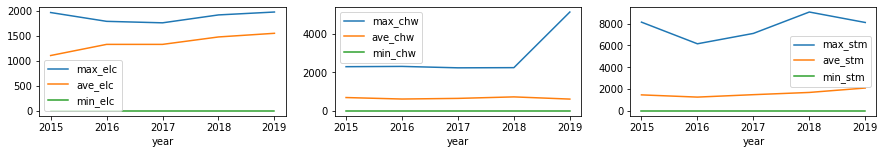

In [ ]:
display(Image('/content/gdrive/MyDrive/PennEnergyData/Figures/raw_data_outliers_removed/Singh Nano Bldg.png'))
displayEnergySummary('Singh Nano Bldg.csv')

10.   Vagelos Labs

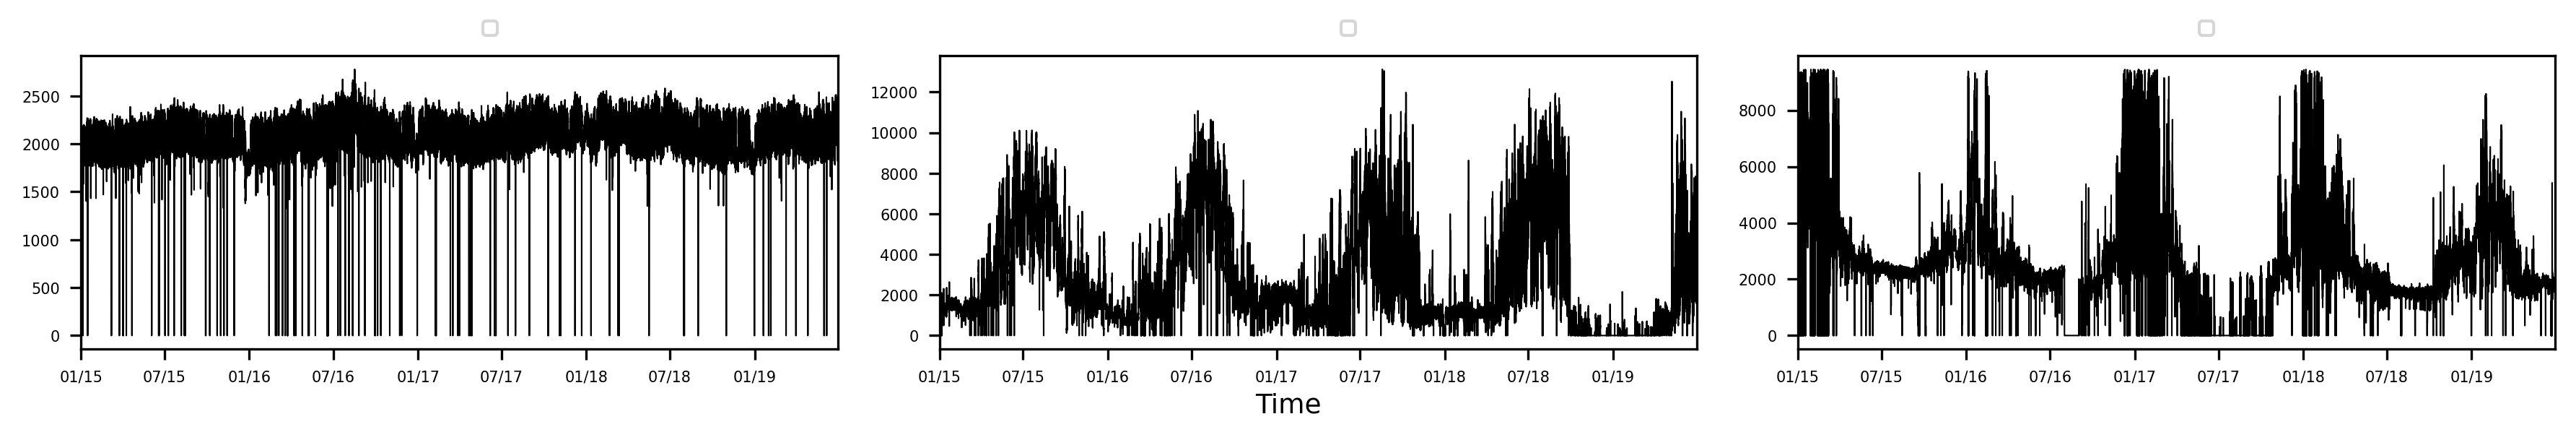

                       Time          ELC      CHW  ...  year_month  year month
0       2015-01-01 00:00:00  1691.296423     0.00  ...     2015 01  2015    01
1       2015-01-01 00:15:00  1706.070998     0.00  ...     2015 01  2015    01
2       2015-01-01 00:30:00  1648.064584     0.00  ...     2015 01  2015    01
3       2015-01-01 00:45:00  1716.307424     0.00  ...     2015 01  2015    01
4       2015-01-01 01:00:00  1709.483140     0.00  ...     2015 01  2015    01
...                     ...          ...      ...  ...         ...   ...   ...
157627  2019-06-30 22:45:00  1973.790000  2354.12  ...     2019 06  2019    06
157628  2019-06-30 23:00:00  2013.400000  1905.55  ...     2019 06  2019    06
157629  2019-06-30 23:15:00  1939.170000  1778.89  ...     2019 06  2019    06
157630  2019-06-30 23:30:00  1914.500000  1641.20  ...     2019 06  2019    06
157631  2019-06-30 23:45:00  2000.650000  2925.39  ...     2019 06  2019    06

[157632 rows x 8 columns]
                       Ti

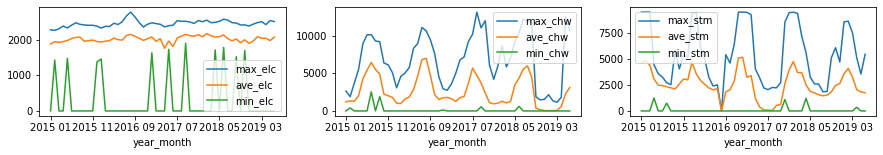

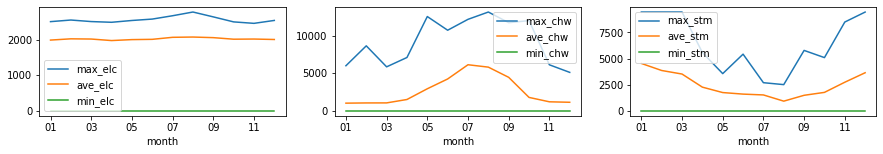

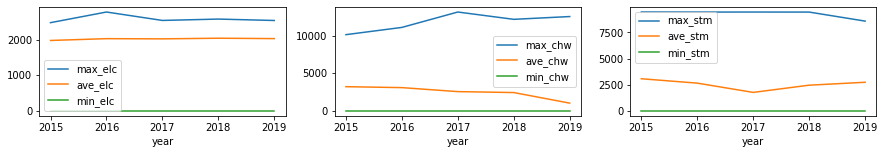

In [ ]:
display(Image('/content/gdrive/MyDrive/PennEnergyData/Figures/raw_data_outliers_removed/Vagelos Labs (IAST).png'))
displayEnergySummary('Vagelos Labs (IAST).csv')

Now lets explore the weather data a little bit

In [ ]:
def weatherDataSummary():
  building_df = pd.read_csv('/content/gdrive/MyDrive/PennEnergyData/Weather/weather.csv')
  building_df['time_valid_lcl'].astype('datetime64')
  building_df['date'] = building_df['time_valid_lcl'].map(lambda x: x.split(' ')[0])
  building_df['year_month'] = building_df['date'].map(lambda x: x.split('/')[2]+' '+x.split('/')[0])
  building_df['year'] = building_df['date'].map(lambda x: x.split('/')[2])
  building_df['month'] = building_df['date'].map(lambda x: x.split('/')[0])

  building_year_month_df = joinWeatherSummary(building_df, 'year_month')
  building_year_df = joinWeatherSummary(building_df, 'year')
  building_month_df = joinWeatherSummary(building_df, 'month')
  
  return building_year_month_df, building_year_df, building_month_df

In [ ]:
def joinWeatherSummary(df, joinon):
  print(df)
  mean_df = df[[joinon, 'temperature_air_2m_f', 'humidity_relative_2m_pct', 'wind_speed_10m_kts', 'precipitation_in']].groupby(joinon).mean()
  mean_df.columns = ['ave_temp', 'ave_rh', 'ave_wind', 'ave_rain']
  max_df = df[[joinon, 'temperature_air_2m_f', 'humidity_relative_2m_pct', 'wind_speed_10m_kts', 'precipitation_in']].groupby(joinon).max()
  max_df.columns = ['max_temp', 'max_rh', 'max_wind', 'max_rain']
  min_df = df[[joinon, 'temperature_air_2m_f', 'humidity_relative_2m_pct', 'wind_speed_10m_kts', 'precipitation_in']].groupby(joinon).min()
  min_df.columns = ['min_temp', 'min_rh', 'min_wind', 'min_rain']
  ret_df = min_df.merge(mean_df, on=joinon, how='inner').merge(max_df, on=joinon, how='inner')
  return ret_df

In [ ]:
def displayWeatherSummary():
  weather_year_month_df, weather_year_df, weather_month_df = weatherDataSummary()

  fig, axes = plt.subplots(nrows=1, ncols=4)
  fig.set_size_inches(15,2)
  weather_year_month_df[['max_temp', 'ave_temp', 'min_temp']].plot(ax=axes[0])
  weather_year_month_df[['max_rh', 'ave_rh', 'min_rh']].plot(ax=axes[1])
  weather_year_month_df[['max_wind', 'ave_wind', 'min_wind']].plot(ax=axes[2])
  weather_year_month_df[['max_rain', 'ave_rain', 'min_rain']].plot(ax=axes[3])

  fig, axes = plt.subplots(nrows=1, ncols=4)
  fig.set_size_inches(15,2)
  weather_month_df[['max_temp', 'ave_temp', 'min_temp']].plot(ax=axes[0])
  weather_month_df[['max_rh', 'ave_rh', 'min_rh']].plot(ax=axes[1])
  weather_month_df[['max_wind', 'ave_wind', 'min_wind']].plot(ax=axes[2])
  weather_month_df[['max_rain', 'ave_rain', 'min_rain']].plot(ax=axes[3])

  fig, axes = plt.subplots(nrows=1, ncols=4)
  fig.set_size_inches(15,2)
  weather_year_df[['max_temp', 'ave_temp', 'min_temp']].plot(ax=axes[0])
  weather_year_df[['max_rh', 'ave_rh', 'min_rh']].plot(ax=axes[1])
  weather_year_df[['max_wind', 'ave_wind', 'min_wind']].plot(ax=axes[2])
  weather_year_df[['max_rain', 'ave_rain', 'min_rain']].plot(ax=axes[3])
  

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (22,24,25) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


           wsid   time_valid_utc  doy_utc  ...  year_month  year  month
0      10767136    1/1/2013 0:00        1  ...     2012 12  2012     12
1      10767136    1/1/2013 1:00        1  ...     2012 12  2012     12
2      10767136    1/1/2013 2:00        1  ...     2012 12  2012     12
3      10767136    1/1/2013 3:00        1  ...     2012 12  2012     12
4      10767136    1/1/2013 4:00        1  ...     2012 12  2012     12
...         ...              ...      ...  ...         ...   ...    ...
56921  10767136  6/30/2019 23:00      181  ...      2019 6  2019      6
56922  10767136    7/1/2019 0:00      182  ...      2019 6  2019      6
56923  10767136    7/1/2019 1:00      182  ...      2019 6  2019      6
56924  10767136    7/1/2019 2:00      182  ...      2019 6  2019      6
56925  10767136    7/1/2019 3:00      182  ...      2019 6  2019      6

[56926 rows x 35 columns]
           wsid   time_valid_utc  doy_utc  ...  year_month  year  month
0      10767136    1/1/2013 0:00     

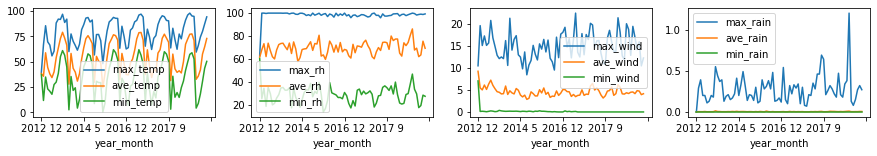

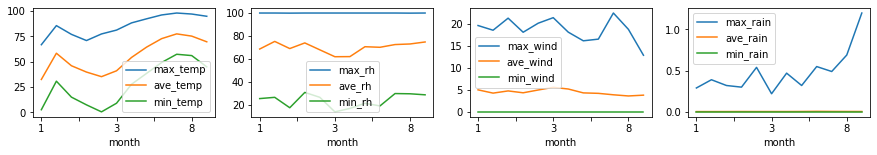

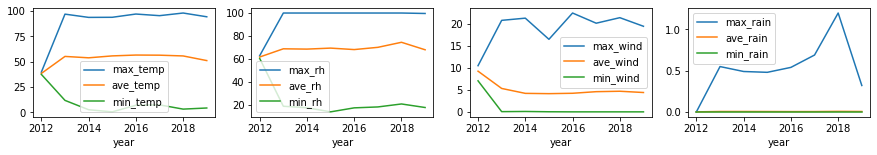

In [ ]:
displayWeatherSummary()

#On to Machine Learning!

### Our goal
First, we have to figure out what we want to do with this data in the first place. Looking at our training data, we can see there are features for the month and hour of the given date, the temperature and other weather data, and then electricity, chilled water, and steam energy outputs. Thus, we know we need to use the weather data to predict one of the three energy outputs.

We will run 60 models total for this project -- 6 for each of the 10 buildings we decided to work on to cover the 3 outputs and the two types of models we want to run.

### Accounting for seasonality
As you can see from the plots above, the data is pretty seasonal, especially temperature. This makes sense, considering weather data is maybe the most seasonal thing out there (at least until global warming changes that). The first step in model-building is to account for that seasonality.

In [ ]:
#According to the class slides, I should remove an exponential weighted moving average to eliminate seasonality through differencing 
def remove_seasonality(df):
 result = df.copy()
 result[['temp','rh', 'wind', 'precipitation', 'cloud', 'irr', 'snow', 'ELC', 'CHW', 'STM']] = result[['temp','rh', 'wind', 'precipitation', 'cloud', 'irr', 'snow', 'ELC', 'CHW', 'STM']] - result[['temp','rh', 'wind', 'precipitation', 'cloud', 'irr', 'snow', 'ELC', 'CHW', 'STM']].ewm(com = .5).mean()
 return result


Here's what the temperature data looked like before deseasonalizing

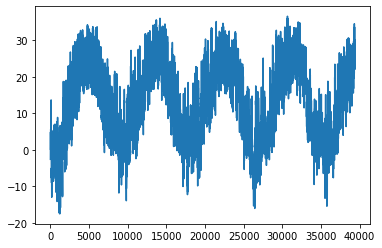

In [ ]:
pd.read_csv('/content/gdrive/MyDrive/PennEnergyData/Training Data/Annenberg Center_hourly_weather.csv')['temp'].plot()

Here's what the temperature data looks like after deseasonalizing:

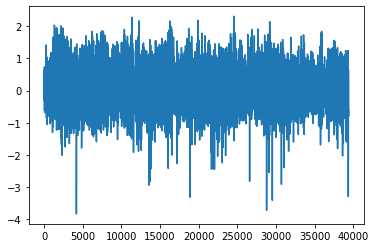

In [ ]:
annenberg_df = remove_seasonality(pd.read_csv('/content/gdrive/MyDrive/PennEnergyData/Training Data/Annenberg Center_hourly_weather.csv'))
blockley_df = remove_seasonality(pd.read_csv('/content/gdrive/MyDrive/PennEnergyData/Training Data/Blockley Hall_hourly_weather.csv'))
brb1_df = remove_seasonality(pd.read_csv('/content/gdrive/MyDrive/PennEnergyData/Training Data/BRB I Stellar Chance_hourly_weather.csv'))
addams_df = remove_seasonality(pd.read_csv('/content/gdrive/MyDrive/PennEnergyData/Training Data/Charles Addams_hourly_weather.csv'))
fisherfine_df = remove_seasonality(pd.read_csv('/content/gdrive/MyDrive/PennEnergyData/Training Data/Fisher and Duhring Wing_hourly_weather.csv'))
sansomwest_df = remove_seasonality(pd.read_csv('/content/gdrive/MyDrive/PennEnergyData/Training Data/Grad Towers B (West)_hourly_weather.csv'))
johnsonpavilion_df = remove_seasonality(pd.read_csv('/content/gdrive/MyDrive/PennEnergyData/Training Data/Johnson Pavilion_hourly_weather.csv'))
museum_df = remove_seasonality(pd.read_csv('/content/gdrive/MyDrive/PennEnergyData/Training Data/Museum_hourly_weather.csv'))
singh_df = remove_seasonality(pd.read_csv('/content/gdrive/MyDrive/PennEnergyData/Training Data/Singh Nano Bldg_hourly_weather.csv'))
vagelos_df = remove_seasonality(pd.read_csv('/content/gdrive/MyDrive/PennEnergyData/Training Data/Vagelos Labs (IAST)_hourly_weather.csv'))
annenberg_df['temp'].plot()

### Normalizing and scaling the data
First, we need to scale our data. We will need to use PCA (Primary Component Analysis) to select features, and we know that PCA is not scale-invariant. As a result, our features need to all be in the same range in order for PCA to tell us anything meaningful about which variables to select. This cell makes a scaler that will transform everything in the data to a 0-1 scale, where 0 is the min value and 1 is the max value.
Note that we don't scale the date columns, since that is not necessary.

In [ ]:
# pretty common min-max scaler from sklearn
# source: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
def normalize(df):
    result = df.copy()
    result[['temp','rh', 'wind', 'precipitation', 'cloud', 'irr', 'snow', 'ELC', 'CHW', 'STM']] = scaler.fit_transform(result[['temp','rh', 'wind', 'precipitation', 'cloud', 'irr', 'snow', 'ELC', 'CHW', 'STM']])
    return result

Normalizing for each building:

In [ ]:
annenberg_normalized = normalize(annenberg_df)
blockley_normalized = normalize(blockley_df)
brb1_normalized = normalize(brb1_df)
addams_normalized = normalize(addams_df)
fisherfine_normalized = normalize(fisherfine_df)
sansomwest_normalized = normalize(sansomwest_df)
johnsonpavilion_normalized = normalize(johnsonpavilion_df)
museum_normalized = normalize(museum_df)
singh_normalized = normalize(singh_df)
vagelos_normalized = normalize(vagelos_df)

Extra code (ignore)

In [ ]:
# annenberg_normalized = normalize(pd.read_csv('/content/gdrive/MyDrive/PennEnergyData/Training Data/Annenberg Center_hourly_weather.csv'))
# blockley_normalized = normalize(pd.read_csv('/content/gdrive/MyDrive/PennEnergyData/Training Data/Blockley Hall_hourly_weather.csv'))
# brb1_normalized = normalize(pd.read_csv('/content/gdrive/MyDrive/PennEnergyData/Training Data/BRB I Stellar Chance_hourly_weather.csv'))
# addams_normalized = normalize(pd.read_csv('/content/gdrive/MyDrive/PennEnergyData/Training Data/Charles Addams_hourly_weather.csv'))
# fisherfine_normalized = normalize(pd.read_csv('/content/gdrive/MyDrive/PennEnergyData/Training Data/Fisher and Duhring Wing_hourly_weather.csv'))
# sansomwest_normalized = normalize(pd.read_csv('/content/gdrive/MyDrive/PennEnergyData/Training Data/Grad Towers B (West)_hourly_weather.csv'))
# johnsonpavilion_normalized = normalize(pd.read_csv('/content/gdrive/MyDrive/PennEnergyData/Training Data/Johnson Pavilion_hourly_weather.csv'))
# museum_normalized = normalize(pd.read_csv('/content/gdrive/MyDrive/PennEnergyData/Training Data/Museum_hourly_weather.csv'))
# singh_normalized = normalize(pd.read_csv('/content/gdrive/MyDrive/PennEnergyData/Training Data/Singh Nano Bldg_hourly_weather.csv'))
# vagelos_normalized = normalize(pd.read_csv('/content/gdrive/MyDrive/PennEnergyData/Training Data/Vagelos Labs (IAST)_hourly_weather.csv'))
# display(annenberg_normalized)

### Regression Model
First, let's try to model our outputs using a multiple regression model. To be honest, it's unlikely that this model will be very accurate, but it's still a great baseline anyways. We'll make a function that will run a linear model for all 3 outputs and print the summaries for each.

First, we'll split our data into testing and training data before calling the function:


In [ ]:
from sklearn.model_selection import train_test_split
def split_data(passedDF):
  result = passedDF.copy()
  result_x = result[['temp','rh', 'wind', 'precipitation', 'cloud', 'irr', 'snow']]
  result_y = result[['ELC', 'CHW', 'STM']]
  result_x_train, result_x_test, result_y_train, result_y_test = train_test_split(result_x, result_y, test_size = .3, random_state = 23)
  return result_x_train, result_x_test, result_y_train, result_y_test

In [ ]:
annenberg_x_train, annenberg_x_test, annenberg_y_train, annenberg_y_test = split_data(annenberg_normalized)
blockley_x_train, blockley_x_test, blockley_y_train, blockley_y_test = split_data(blockley_normalized)
brb1_x_train, brb1_x_test, brb1_y_train, brb1_y_test = split_data(brb1_normalized)
addams_x_train, addams_x_test, addams_y_train, addams_y_test = split_data(addams_normalized)
fisherfine_x_train, fisherfine_x_test, fisherfine_y_train, fisherfine_y_test = split_data(fisherfine_normalized)
sansomwest_x_train, sansomwest_x_test, sansomwest_y_train, sansomwest_y_test = split_data(sansomwest_normalized)
johnsonpavilion_x_train, johnsonpavilion_x_test, johnsonpavilion_y_train, johnsonpavilion_y_test = split_data(johnsonpavilion_normalized)
museum_x_train, museum_x_test, museum_y_train, museum_y_test = split_data(museum_normalized)
singh_x_train, singh_x_test, singh_y_train, singh_y_test = split_data(singh_normalized)
vagelos_x_train, vagelos_x_test, vagelos_y_train, vagelos_y_test = split_data(vagelos_normalized)

In [ ]:
# Regression metrics idea ripped from: https://stackoverflow.com/questions/26319259/how-to-get-a-regression-summary-in-python-scikit-like-r-does
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
def threeRegressionModels(x_train, x_test, y_train, y_test):
  regr1 = LinearRegression()
  regr1.fit(x_train, y_train['ELC'])
  y_pred1 = regr1.predict(x_test)

  explained_variance=metrics.explained_variance_score(y_test['ELC'], y_pred1)
  mean_absolute_error=metrics.mean_absolute_error(y_test['ELC'], y_pred1) 
  mse=metrics.mean_squared_error(y_test['ELC'], y_pred1)
  median_absolute_error=metrics.median_absolute_error(y_test['ELC'], y_pred1)
  r2=metrics.r2_score(y_test['ELC'], y_pred1)
  print("ELECTRICITY MODEL:\n")
  print('explained_variance: ', round(explained_variance,4))    
  print('r2: ', round(r2,4))
  print('MAE: ', round(mean_absolute_error,4))
  print('MSE: ', round(mse,4))
  print('RMSE: ', round(np.sqrt(mse),4))


  regr2 = LinearRegression()
  regr2.fit(x_train, y_train['CHW'])
  y_pred2 = regr2.predict(x_test)

  explained_variance=metrics.explained_variance_score(y_test['CHW'], y_pred2)
  mean_absolute_error=metrics.mean_absolute_error(y_test['CHW'], y_pred2) 
  mse=metrics.mean_squared_error(y_test['CHW'], y_pred2)
  median_absolute_error=metrics.median_absolute_error(y_test['CHW'], y_pred2)
  r2=metrics.r2_score(y_test['CHW'], y_pred2)
  print("\n\nCHILLED WATER MODEL:\n")
  print('explained_variance: ', round(explained_variance,4))    
  print('r2: ', round(r2,4))
  print('MAE: ', round(mean_absolute_error,4))
  print('MSE: ', round(mse,4))
  print('RMSE: ', round(np.sqrt(mse),4))


  regr3 = LinearRegression()
  regr3.fit(x_train, y_train['STM'])
  y_pred3 = regr3.predict(x_test)

  explained_variance=metrics.explained_variance_score(y_test['STM'], y_pred3)
  mean_absolute_error=metrics.mean_absolute_error(y_test['STM'], y_pred3) 
  mse=metrics.mean_squared_error(y_test['STM'], y_pred3)
  median_absolute_error=metrics.median_absolute_error(y_test['STM'], y_pred3)
  r2=metrics.r2_score(y_test['STM'], y_pred3)
  print("\n\nSTEAM MODEL:\n")
  print('explained_variance: ', round(explained_variance,4))    
  print('r2: ', round(r2,4))
  print('MAE: ', round(mean_absolute_error,4))
  print('MSE: ', round(mse,4))
  print('RMSE: ', round(np.sqrt(mse),4))


In [ ]:
threeRegressionModels(annenberg_x_train, annenberg_x_test, annenberg_y_train, annenberg_y_test)

ELECTRICITY MODEL:

explained_variance:  0.054
r2:  0.0538
MAE:  0.0152
MSE:  0.0008
RMSE:  0.0289


CHILLED WATER MODEL:

explained_variance:  0.0141
r2:  0.0141
MAE:  0.0205
MSE:  0.0014
RMSE:  0.0377


STEAM MODEL:

explained_variance:  0.0094
r2:  0.0094
MAE:  0.0087
MSE:  0.0006
RMSE:  0.0239


In [ ]:
threeRegressionModels(blockley_x_train, blockley_x_test, blockley_y_train, blockley_y_test)

ELECTRICITY MODEL:

explained_variance:  0.2198
r2:  0.2198
MAE:  0.0146
MSE:  0.0006
RMSE:  0.0251


CHILLED WATER MODEL:

explained_variance:  0.1128
r2:  0.1127
MAE:  0.0135
MSE:  0.0007
RMSE:  0.0272


STEAM MODEL:

explained_variance:  0.001
r2:  0.0004
MAE:  0.0249
MSE:  0.0037
RMSE:  0.0607


In [ ]:
threeRegressionModels(brb1_x_train, brb1_x_test, brb1_y_train, brb1_y_test)

ELECTRICITY MODEL:

explained_variance:  0.027
r2:  0.027
MAE:  0.009
MSE:  0.0007
RMSE:  0.0264


CHILLED WATER MODEL:

explained_variance:  0.1557
r2:  0.1557
MAE:  0.0112
MSE:  0.0004
RMSE:  0.0193


STEAM MODEL:

explained_variance:  0.0781
r2:  0.0781
MAE:  0.0067
MSE:  0.0002
RMSE:  0.0153


In [ ]:
threeRegressionModels(addams_x_train, addams_x_test, addams_y_train, addams_y_test)

ELECTRICITY MODEL:

explained_variance:  0.0798
r2:  0.0798
MAE:  0.0123
MSE:  0.0005
RMSE:  0.0232


CHILLED WATER MODEL:

explained_variance:  0.0928
r2:  0.0928
MAE:  0.0143
MSE:  0.0008
RMSE:  0.0289


STEAM MODEL:

explained_variance:  0.062
r2:  0.0614
MAE:  0.0101
MSE:  0.0004
RMSE:  0.0207


In [ ]:
threeRegressionModels(fisherfine_x_train, fisherfine_x_test, fisherfine_y_train, fisherfine_y_test)

ELECTRICITY MODEL:

explained_variance:  0.1813
r2:  0.1809
MAE:  0.0252
MSE:  0.0017
RMSE:  0.0411


CHILLED WATER MODEL:

explained_variance:  0.0875
r2:  0.0873
MAE:  0.0119
MSE:  0.0006
RMSE:  0.0242


STEAM MODEL:

explained_variance:  0.0785
r2:  0.0778
MAE:  0.0171
MSE:  0.0006
RMSE:  0.0245


In [ ]:
threeRegressionModels(sansomwest_x_train, sansomwest_x_test, sansomwest_y_train, sansomwest_y_test)

ELECTRICITY MODEL:

explained_variance:  0.0093
r2:  0.0093
MAE:  0.0108
MSE:  0.0004
RMSE:  0.0206


CHILLED WATER MODEL:

explained_variance:  0.0561
r2:  0.056
MAE:  0.0067
MSE:  0.0003
RMSE:  0.0169


STEAM MODEL:

explained_variance:  0.1137
r2:  0.1136
MAE:  0.0087
MSE:  0.0002
RMSE:  0.0155


In [ ]:
threeRegressionModels(johnsonpavilion_x_train, johnsonpavilion_x_test, johnsonpavilion_y_train, johnsonpavilion_y_test)

ELECTRICITY MODEL:

explained_variance:  0.0546
r2:  0.0546
MAE:  0.0079
MSE:  0.0007
RMSE:  0.0257


CHILLED WATER MODEL:

explained_variance:  0.0859
r2:  0.0858
MAE:  0.0112
MSE:  0.0004
RMSE:  0.021


STEAM MODEL:

explained_variance:  0.1152
r2:  0.1151
MAE:  0.0101
MSE:  0.0004
RMSE:  0.0211


In [ ]:
threeRegressionModels(museum_x_train, museum_x_test, museum_y_train, museum_y_test)

ELECTRICITY MODEL:

explained_variance:  0.1724
r2:  0.1724
MAE:  0.0132
MSE:  0.0005
RMSE:  0.0232


CHILLED WATER MODEL:

explained_variance:  0.062
r2:  0.0618
MAE:  0.0073
MSE:  0.0002
RMSE:  0.0135


STEAM MODEL:

explained_variance:  0.0042
r2:  0.004
MAE:  0.0268
MSE:  0.0033
RMSE:  0.0577


In [ ]:
threeRegressionModels(singh_x_train, singh_x_test, singh_y_train, singh_y_test)

ELECTRICITY MODEL:

explained_variance:  0.0422
r2:  0.0422
MAE:  0.0093
MSE:  0.0005
RMSE:  0.0217


CHILLED WATER MODEL:

explained_variance:  0.2257
r2:  0.2257
MAE:  0.013
MSE:  0.0005
RMSE:  0.0216


STEAM MODEL:

explained_variance:  0.0738
r2:  0.0736
MAE:  0.0127
MSE:  0.0004
RMSE:  0.0207


In [ ]:
threeRegressionModels(vagelos_x_train, vagelos_x_test, vagelos_y_train, vagelos_y_test)

ELECTRICITY MODEL:

explained_variance:  0.1119
r2:  0.1119
MAE:  0.0088
MSE:  0.0005
RMSE:  0.0214


CHILLED WATER MODEL:

explained_variance:  0.1064
r2:  0.1064
MAE:  0.0142
MSE:  0.0007
RMSE:  0.0259


STEAM MODEL:

explained_variance:  0.0164
r2:  0.0164
MAE:  0.0137
MSE:  0.0009
RMSE:  0.0307


We can see the regression models are not very good, unfortunately.

A potential way to fix this problem is through PCA! PCA or principal component analysis, is a dimensionality-reduction method that allows us to limit multi-collinearity in our data and pick the features that explain the most variance. This might be really helpful to us if the weather data is highly correlated.

### PCA
From here, we want to figure out which features are best for us to use on our models. This can be done by using PCA, which analyzes our features and projects them in such a way that they can cover as much of the variance in the data as possible. This is great for limiting multi-collinearity and getting rid of variables that have no impact on the output. We will also plot the explained variance ratio vs. the number of components. From there, we can figure out which features will be used in our model.

First, we will define a quick function that'll perform PCA and plot the explained variance ratio:

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

In [ ]:
#Explained variance ratio plot
def modelPCA(trainx, trainy):
  pcaModel = PCA().fit(trainx, trainy)

  pc_vs_variance = np.cumsum(pcaModel.explained_variance_ratio_)

  pc_vs_variance
  plt.plot(pc_vs_variance)
  plt.plot([0, 6], [.95, .95])

  pca = PCA(n_components=3)
  pca.fit(trainx)
# and transform it
  return pca.transform(trainx)

Now, we will look at the covariance plots for our training data to see if PCA is really necessary. Since all of them use the same weather training data due to the buildings being in the same location, one correlation plot should be sufficient:

In [ ]:
annenberg_x_train.corr()

temp        rh      wind  ...     cloud       irr      snow
temp           1.000000 -0.795483  0.289523  ... -0.024998  0.577578 -0.012959
rh            -0.795483  1.000000 -0.298984  ...  0.077186 -0.510735  0.046584
wind           0.289523 -0.298984  1.000000  ...  0.013465  0.254938  0.001584
precipitation -0.061860  0.074493  0.036164  ...  0.034854 -0.031702  0.087084
cloud         -0.024998  0.077186  0.013465  ...  1.000000 -0.078140  0.010122
irr            0.577578 -0.510735  0.254938  ... -0.078140  1.000000 -0.004158
snow          -0.012959  0.046584  0.001584  ...  0.010122 -0.004158  1.000000

[7 rows x 7 columns]

In a peculiar twist of events, it seems like PCA actually isn't all that necessary! There isn't enough correlation between our features for it to be useful since most of them are <.3 (source: https://www.originlab.com/doc/Origin-Help/PrincipleComp-Analysis#:~:text=PCA%20should%20be%20used%20mainly,0.3%2C%20PCA%20will%20not%20help.), and it may actually end up hurting our model. A sample explained variance ratio graph is given below for comprehensiveness' sake:

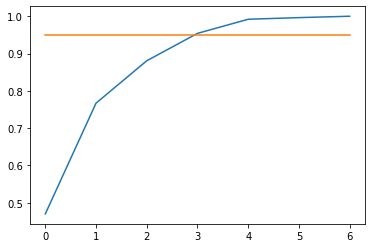

In [ ]:

annenberg_train_2 = modelPCA(annenberg_x_train, annenberg_y_train)

### Random Forest Model
Now that we've gotten our features set, we can try to do a more ML-esque model. A random forest should work well for this problem because there are a number of different features at play and a lot of different decision tree routes that the model could go down, so averaging them out can give us a good answer.

First, we tune the forest parameters with gridSearchCV, and then write a function that will run a random forest for each output variable.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
#from tqdm import tqdm
def tunedForestParameters(x_train_2, y_train):
  param_grid = {
  'max_depth': [3, 4, 6, 7],
  'n_estimators': [20, 30, 50, 80, 100]
  }
  base_estimator = RandomForestRegressor(random_state=0)
  GS_object1 = GridSearchCV(base_estimator, param_grid).fit(x_train_2, y_train['ELC'])
  GS_object2 = GridSearchCV(base_estimator, param_grid).fit(x_train_2, y_train['CHW'])
  GS_object3 = GridSearchCV(base_estimator, param_grid).fit(x_train_2, y_train['STM'])
  return GS_object1, GS_object2, GS_object3


In [ ]:
# feature importance chart code from: https://stackoverflow.com/questions/44101458/random-forest-feature-importance-chart-using-python
def threeRandomForests(GS_object1, GS_object2, GS_object3, x_test, y_test):

  depth = list(GS_object1.best_params_.values())[0]
  estimators = list(GS_object1.best_params_.values())[1]
  rfModel1 = RandomForestRegressor(n_estimators = estimators, max_depth = depth, random_state = 23)
  rfModel1.fit(x_test, y_test['ELC'])
  y_pred = rfModel1.predict(x_test)
  error = abs(y_pred - y_test['ELC'])
  mse_test = metrics.mean_squared_error(y_test['ELC'], y_pred)
  print("ELECTRICITY MODEL MSE: ", round(mse_test, 4))
  print("ELECTRICITY MODEL RMSE: ", round(np.sqrt(mse_test), 4))
  print("ELECTRICITY MODEL MAPE: ", round(np.mean(error), 4),)
  print("ELECTRICITY MODEL R^2: ", round(rfModel1.score(x_test, y_test['ELC']), 4), "\n\n")
  elc_importances = pd.Series(rfModel1.feature_importances_, index=x_test.columns)
  elc_importances.plot(kind='barh')
  plt.show()

  depth = list(GS_object2.best_params_.values())[0]
  estimators = list(GS_object2.best_params_.values())[1]
  rfModel2 = RandomForestRegressor(n_estimators = estimators, max_depth = depth, random_state = 23)
  rfModel2.fit(x_test, y_test['CHW'])
  y_pred = rfModel2.predict(x_test)
  error = abs(y_pred - y_test['CHW'])
  mse_test = metrics.mean_squared_error(y_test['CHW'], y_pred)
  print("\n\nCHILLED WATER MODEL MSE: ", round(mse_test, 4))
  print("CHILLED WATER MODEL RMSE: ", round(np.sqrt(mse_test), 4))
  print("CHILLED WATER MODEL MAPE: ", round(np.mean(error), 4),)
  print("CHILLED WATER MODEL R^2: ", round(rfModel2.score(x_test, y_test['CHW']), 4), "\n\n")
  chw_importances = pd.Series(rfModel2.feature_importances_, index=x_test.columns)
  chw_importances.plot(kind='barh')
  plt.show()

  depth = list(GS_object3.best_params_.values())[0]
  estimators = list(GS_object3.best_params_.values())[1]
  rfModel3 = RandomForestRegressor(n_estimators = estimators, max_depth = depth, random_state = 23)
  rfModel3.fit(x_test, y_test['STM'])
  y_pred = rfModel3.predict(x_test)
  error = abs(y_pred - y_test['STM'])
  mse_test = metrics.mean_squared_error(y_test['STM'], y_pred)
  print("STEAM MODEL MSE: ", round(mse_test, 4))
  print("STEAM MODEL RMSE: ", round(np.sqrt(mse_test), 4))
  print("STEAM MODEL MAPE: ", round(np.mean(error), 4),)
  print("STEAM MODEL R^2: ", round(rfModel3.score(x_test, y_test['STM']), 4))
  stm_importances = pd.Series(rfModel3.feature_importances_, index=x_test.columns)
  stm_importances.plot(kind='barh')
  plt.show()
  return rfModel1, rfModel2, rfModel3

Since random forests are scale-invariant and we aren't using PCA, it would be best practice to use the unscaled data that only has the deseasonalization transformation applied. Thus, we can actually interpret the Mean Absolute Percentage Error as how far off the model is on average in its predictions.

In [ ]:
annenberg_x_train, annenberg_x_test, annenberg_y_train, annenberg_y_test = split_data(annenberg_df)
blockley_x_train, blockley_x_test, blockley_y_train, blockley_y_test = split_data(blockley_df)
brb1_x_train, brb1_x_test, brb1_y_train, brb1_y_test = split_data(brb1_df)
addams_x_train, addams_x_test, addams_y_train, addams_y_test = split_data(addams_df)
fisherfine_x_train, fisherfine_x_test, fisherfine_y_train, fisherfine_y_test = split_data(fisherfine_df)
sansomwest_x_train, sansomwest_x_test, sansomwest_y_train, sansomwest_y_test = split_data(sansomwest_df)
johnsonpavilion_x_train, johnsonpavilion_x_test, johnsonpavilion_y_train, johnsonpavilion_y_test = split_data(johnsonpavilion_df)
museum_x_train, museum_x_test, museum_y_train, museum_y_test = split_data(museum_df)
singh_x_train, singh_x_test, singh_y_train, singh_y_test = split_data(singh_df)
vagelos_x_train, vagelos_x_test, vagelos_y_train, vagelos_y_test = split_data(vagelos_df)

In [ ]:
import time

ELECTRICITY MODEL MSE:  26.8316
ELECTRICITY MODEL RMSE:  5.1799
ELECTRICITY MODEL MAPE:  2.9711
ELECTRICITY MODEL R^2:  0.863 




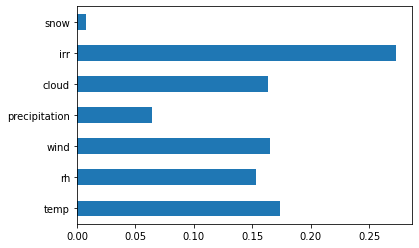



CHILLED WATER MODEL MSE:  424.374
CHILLED WATER MODEL RMSE:  20.6003
CHILLED WATER MODEL MAPE:  11.9355
CHILLED WATER MODEL R^2:  0.8538 




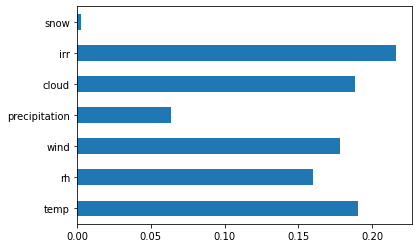

STEAM MODEL MSE:  129.5735
STEAM MODEL RMSE:  11.383
STEAM MODEL MAPE:  4.7449
STEAM MODEL R^2:  0.8537


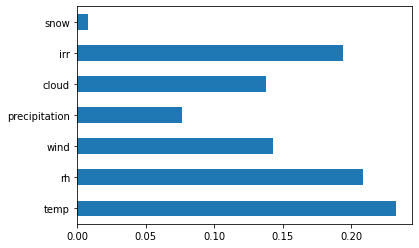

In [ ]:
gs1, gs2, gs3 = tunedForestParameters(annenberg_x_train, annenberg_y_train)
annenberg_rf_1, annenberg_rf_2, annenberg_rf_3 = threeRandomForests(gs1, gs2, gs3, annenberg_x_test, annenberg_y_test)

ELECTRICITY MODEL MSE:  55.722
ELECTRICITY MODEL RMSE:  7.4647
ELECTRICITY MODEL MAPE:  4.4446
ELECTRICITY MODEL R^2:  0.8905 




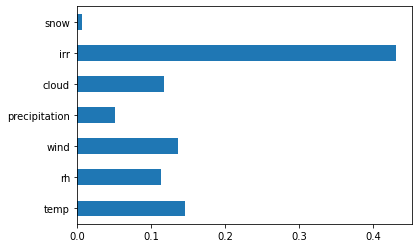



CHILLED WATER MODEL MSE:  65.5454
CHILLED WATER MODEL RMSE:  8.096
CHILLED WATER MODEL MAPE:  4.2643
CHILLED WATER MODEL R^2:  0.8751 




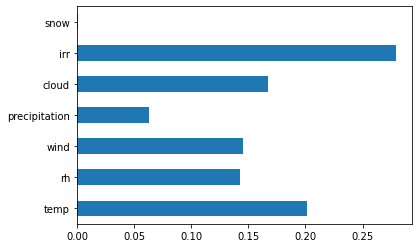

STEAM MODEL MSE:  945.8081
STEAM MODEL RMSE:  30.754
STEAM MODEL MAPE:  15.1907
STEAM MODEL R^2:  0.8544


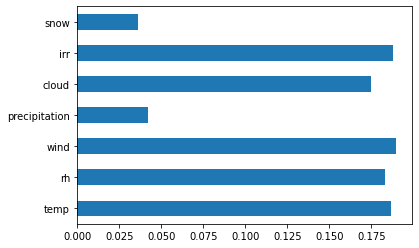

In [ ]:
gs1, gs2, gs3 = tunedForestParameters(blockley_x_train, blockley_y_train)
blockley_rf_1, blockley_rf_2, blockley_rf_3 =  threeRandomForests(gs1, gs2, gs3, blockley_x_test, blockley_y_test)

ELECTRICITY MODEL MSE:  1149.8534
ELECTRICITY MODEL RMSE:  33.9095
ELECTRICITY MODEL MAPE:  12.545
ELECTRICITY MODEL R^2:  0.8439 




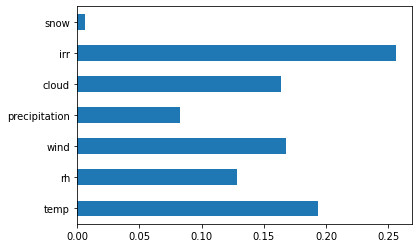



CHILLED WATER MODEL MSE:  3320.6611
CHILLED WATER MODEL RMSE:  57.6252
CHILLED WATER MODEL MAPE:  34.2441
CHILLED WATER MODEL R^2:  0.8811 




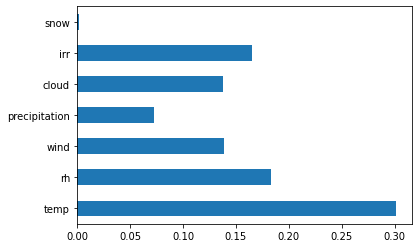

STEAM MODEL MSE:  5024.5549
STEAM MODEL RMSE:  70.8841
STEAM MODEL MAPE:  32.4885
STEAM MODEL R^2:  0.8579


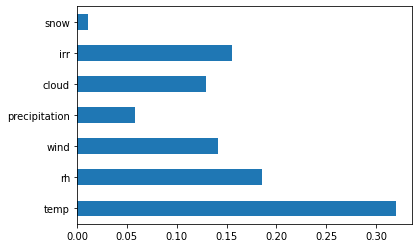

In [ ]:
gs1, gs2, gs3 = tunedForestParameters(brb1_x_train, brb1_y_train)
brb1_rf_1, brb1_rf_2, brb1_rf_3 =  threeRandomForests(gs1, gs2, gs3, brb1_x_test, brb1_y_test)

ELECTRICITY MODEL MSE:  6.8159
ELECTRICITY MODEL RMSE:  2.6107
ELECTRICITY MODEL MAPE:  1.4488
ELECTRICITY MODEL R^2:  0.8672 




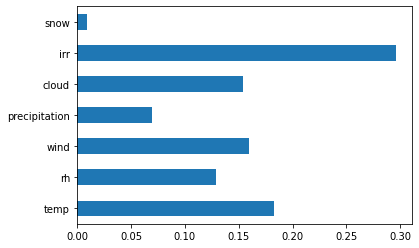



CHILLED WATER MODEL MSE:  177.3052
CHILLED WATER MODEL RMSE:  13.3156
CHILLED WATER MODEL MAPE:  7.1233
CHILLED WATER MODEL R^2:  0.8645 




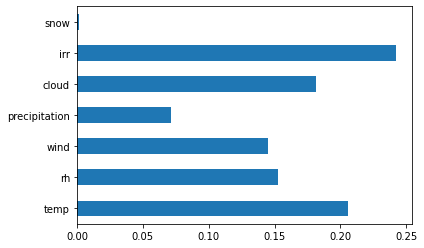

STEAM MODEL MSE:  72.399
STEAM MODEL RMSE:  8.5088
STEAM MODEL MAPE:  4.3706
STEAM MODEL R^2:  0.8549


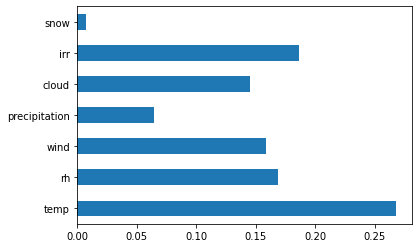

In [ ]:
gs1, gs2, gs3 = tunedForestParameters(addams_x_train, addams_y_train)
addams_rf_1, addams_rf_2, addams_rf_3 =  threeRandomForests(gs1, gs2, gs3, addams_x_test, addams_y_test)

ELECTRICITY MODEL MSE:  17.7827
ELECTRICITY MODEL RMSE:  4.2169
ELECTRICITY MODEL MAPE:  2.8535
ELECTRICITY MODEL R^2:  0.894 




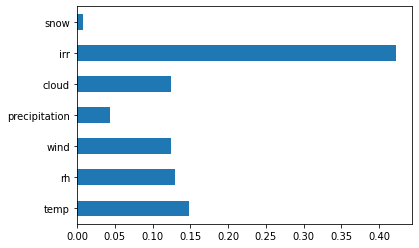



CHILLED WATER MODEL MSE:  19.2302
CHILLED WATER MODEL RMSE:  4.3852
CHILLED WATER MODEL MAPE:  2.2751
CHILLED WATER MODEL R^2:  0.8655 




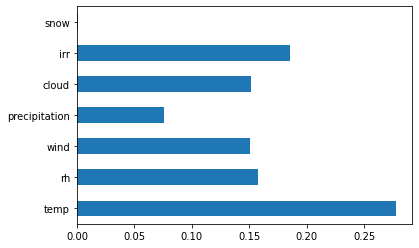

STEAM MODEL MSE:  27.6253
STEAM MODEL RMSE:  5.256
STEAM MODEL MAPE:  3.6602
STEAM MODEL R^2:  0.8618


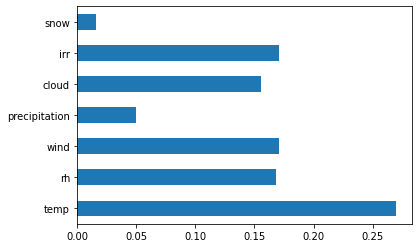

In [ ]:
gs1, gs2, gs3 = tunedForestParameters(fisherfine_x_train, fisherfine_y_train)
fisherfine_rf_1, fisherfine_rf_2, fisherfine_rf_3 =  threeRandomForests(gs1, gs2, gs3, fisherfine_x_test, fisherfine_y_test)

ELECTRICITY MODEL MSE:  6.3531
ELECTRICITY MODEL RMSE:  2.5205
ELECTRICITY MODEL MAPE:  1.297
ELECTRICITY MODEL R^2:  0.8641 




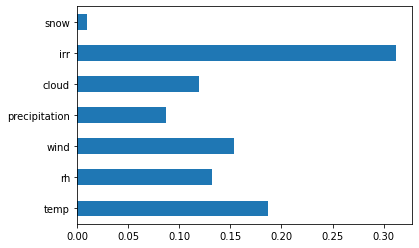



CHILLED WATER MODEL MSE:  68.7112
CHILLED WATER MODEL RMSE:  8.2892
CHILLED WATER MODEL MAPE:  3.5418
CHILLED WATER MODEL R^2:  0.8629 




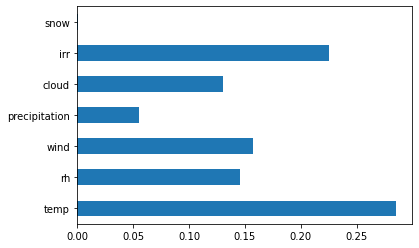

STEAM MODEL MSE:  367.5556
STEAM MODEL RMSE:  19.1717
STEAM MODEL MAPE:  10.9753
STEAM MODEL R^2:  0.8663


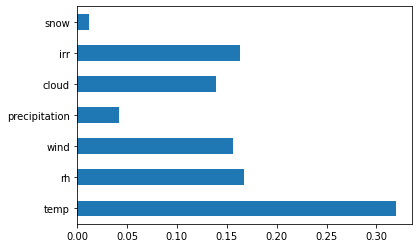

In [ ]:
gs1, gs2, gs3 = tunedForestParameters(sansomwest_x_train, sansomwest_y_train)
sansomwest_rf_1, sansomwest_rf_2, sansomwest_rf_3 =  threeRandomForests(gs1, gs2, gs3, sansomwest_x_test, sansomwest_y_test)

ELECTRICITY MODEL MSE:  500.2844
ELECTRICITY MODEL RMSE:  22.367
ELECTRICITY MODEL MAPE:  7.7057
ELECTRICITY MODEL R^2:  0.8549 




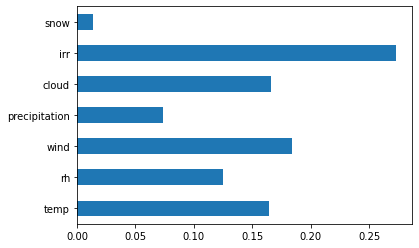



CHILLED WATER MODEL MSE:  2398.1878
CHILLED WATER MODEL RMSE:  48.9713
CHILLED WATER MODEL MAPE:  27.2258
CHILLED WATER MODEL R^2:  0.8638 




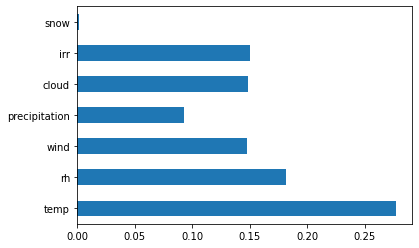

STEAM MODEL MSE:  3477.0025
STEAM MODEL RMSE:  58.9661
STEAM MODEL MAPE:  29.7389
STEAM MODEL R^2:  0.866


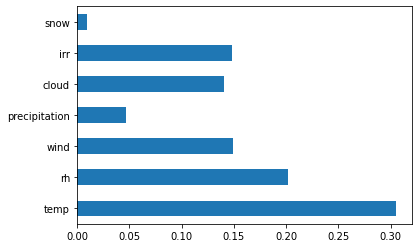

In [ ]:
gs1, gs2, gs3 = tunedForestParameters(johnsonpavilion_x_train, johnsonpavilion_y_train)
johnsonpavilion_rf_1, johnsonpavilion_rf_2, johnsonpavilion_rf_3 =  threeRandomForests(gs1, gs2, gs3, johnsonpavilion_x_test, johnsonpavilion_y_test)

ELECTRICITY MODEL MSE:  139.5577
ELECTRICITY MODEL RMSE:  11.8135
ELECTRICITY MODEL MAPE:  6.8611
ELECTRICITY MODEL R^2:  0.8877 




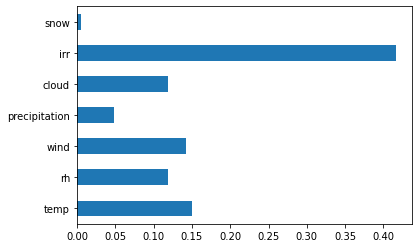



CHILLED WATER MODEL MSE:  273.101
CHILLED WATER MODEL RMSE:  16.5258
CHILLED WATER MODEL MAPE:  9.3545
CHILLED WATER MODEL R^2:  0.8593 




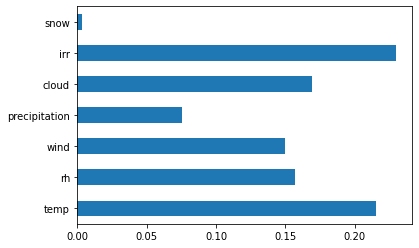

STEAM MODEL MSE:  8172.2229
STEAM MODEL RMSE:  90.4003
STEAM MODEL MAPE:  47.8073
STEAM MODEL R^2:  0.8545


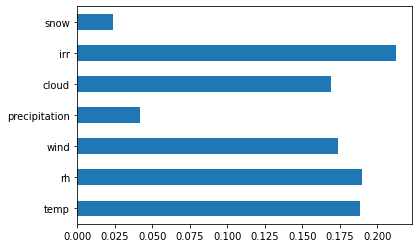

In [ ]:
gs1, gs2, gs3 = tunedForestParameters(museum_x_train, museum_y_train)
museum_rf_1, museum_rf_2, museum_rf_3 =  threeRandomForests(gs1, gs2, gs3, museum_x_test, museum_y_test)

ELECTRICITY MODEL MSE:  90.4838
ELECTRICITY MODEL RMSE:  9.5123
ELECTRICITY MODEL MAPE:  4.2649
ELECTRICITY MODEL R^2:  0.8562 




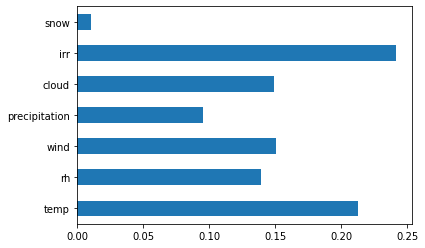



CHILLED WATER MODEL MSE:  71.1528
CHILLED WATER MODEL RMSE:  8.4352
CHILLED WATER MODEL MAPE:  5.147
CHILLED WATER MODEL R^2:  0.8904 




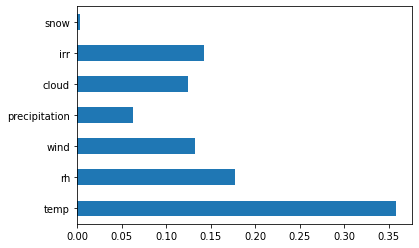

STEAM MODEL MSE:  1218.9881
STEAM MODEL RMSE:  34.914
STEAM MODEL MAPE:  22.0246
STEAM MODEL R^2:  0.864


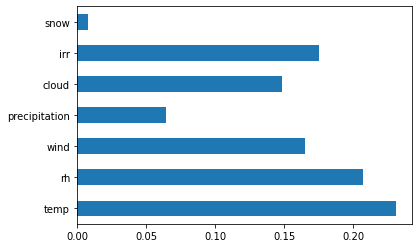

In [ ]:
gs1, gs2, gs3 = tunedForestParameters(singh_x_train, singh_y_train)
singh_rf_1, singh_rf_2, singh_rf_3 = threeRandomForests(gs1, gs2, gs3, singh_x_test, singh_y_test)

ELECTRICITY MODEL MSE:  156.7775
ELECTRICITY MODEL RMSE:  12.5211
ELECTRICITY MODEL MAPE:  5.1539
ELECTRICITY MODEL R^2:  0.8616 




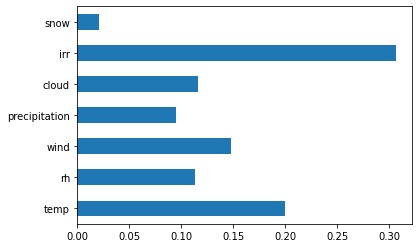



CHILLED WATER MODEL MSE:  2546.9369
CHILLED WATER MODEL RMSE:  50.4672
CHILLED WATER MODEL MAPE:  28.9454
CHILLED WATER MODEL R^2:  0.8691 




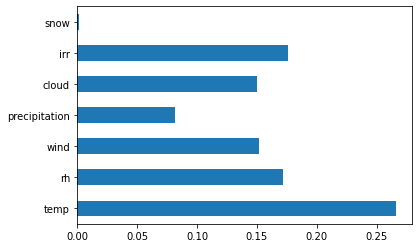

STEAM MODEL MSE:  3284.6921
STEAM MODEL RMSE:  57.3122
STEAM MODEL MAPE:  28.5173
STEAM MODEL R^2:  0.8545


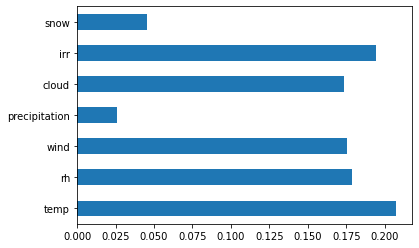

In [ ]:
gs1, gs2, gs3 = tunedForestParameters(vagelos_x_train, vagelos_y_train)
vagelos_rf_1, vagelos_rf_2, vagelos_rf_3 = threeRandomForests(gs1, gs2, gs3, vagelos_x_test, vagelos_y_test)

### Comparing the models and some conclusions

First, we can see that the R^2 and accuracy for the random forests are high. While random forests are a bit more black-boxed than a decision tree, we can still see the predictive power. Since this was not captured in the regression models, I believe that maybe energy usage should be modeled as a set of conditions, rather than directly correlated variables. For example, electricity usage may only peak when the outside temperature is above/below a certain level, rather than a linear relationship. This matches with the intuition that heating/cooling systems may be tripped off by external weather monitors. The university only turns on heating/cooling for dorm buildings once the average temperature reaches a certain level, for example.

Also, the MAPE (mean absolute percentage error) and MSE for all of these models is fairly low, even though the outputs are not scaled down. This implies that these forests are able to model the outputs with decent. An additional thought is that some outliers are hurting the residual values predicted by the model and thus dropping the R^2 while not affecting the MAPE as much, and the deseasonalized graph does show some large outliers to support that idea.

From the data, we see that the Johnson Pavilion and Museum steam models have a particularly high RMSE value. One conclusion we can draw is that it may be useful to have the steam gauges checked and/or to recommision the steam valves in these buildings. It is possible they are inefficient, faulty, or too old to function properly, which is leading to such an error in the model!

Overall, we have learned a lot from this model-building process and have demonstrated that weather data is useful for predicting energy usage in buildings across campus.